# Approach 1: Counting Windows using SIFT Feature Matching & Outlier Rejection


In [4]:
import os
import sys
sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from imutils import paths
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random
import pickle
import csv

In [5]:
!export PATH=/Library/TeX/texbin:$PATH

'export' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\001\\images\\"
coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-1-shufflenet.csv'
windowCount = 0

In [51]:
# Displaying the contents of the text file

# del list

with open(coordFilePath, newline='') as f:
    csvread = csv.reader(f)
    print(csvread)
    batch_data = list(csvread)
print(len(batch_data))

print(batch_data[0])


batch_data_int = []
for inner_list in batch_data:
    innet_out_list = []
    for string in inner_list:
        innet_out_list.append(int(float(string)))
    batch_data_int.append(innet_out_list)

print("bATCH_Data_int:", batch_data_int)
print(len(batch_data_int))
print(batch_data_int[1][0])
FinalList = []
for i in range(len(batch_data_int)):
    el = batch_data_int[i]
    elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
    print("elChunks:", elChunks)
    newElChunks = elChunks.copy()
    for i in range(len(elChunks)):
#         newChunk = newElChunks[i]        
        chunk = elChunks[i]
        newChunk = chunk.copy()
        print("newChunk", newChunk)
        print("chunk", chunk)
        newChunk.insert(2, chunk[0])
        newChunk.insert(3, chunk[3])
        newChunk.insert(6, chunk[2])
        newChunk.insert(7, chunk[1])
        print("newModifiedChunk", newChunk)
        newElChunks[i] = newChunk
    print(newElChunks)
    perImageCoords = np.array(newElChunks)
    perImageCoords = perImageCoords.reshape(-1,4,2)
    FinalList.append(perImageCoords)

print("Final list:", FinalList)
print("Final list size:", len(FinalList))
print("Final list:", FinalList[0].shape)
print("Final list:", FinalList[0])

23
['1.900000000000000000e+02', '0.000000000000000000e+00', '3.880000000000000000e+02', '1.420000000000000000e+02', '5.990000000000000000e+02', '0.000000000000000000e+00', '7.920000000000000000e+02', '1.400000000000000000e+02']
bATCH_Data_int: [[190, 0, 388, 142, 599, 0, 792, 140], [215, 45, 408, 222, 607, 45, 797, 220], [226, 195, 413, 357, 604, 195, 789, 352], [243, 315, 428, 457, 619, 307, 796, 455], [637, 392, 782, 497, 272, 382, 415, 485, 655, 0, 817, 105], [647, 452, 790, 555, 285, 442, 425, 542, 0, 430, 70, 530, 250, 7, 453, 182, 665, 22, 822, 167], [647, 480, 790, 577, 290, 472, 430, 565, 0, 462, 77, 552, 252, 35, 450, 215, 647, 35, 840, 212], [615, 500, 752, 590, 255, 492, 395, 582, 627, 75, 780, 220, 237, 75, 387, 217], [642, 560, 782, 647, 290, 552, 427, 635, 660, 140, 812, 280, 267, 140, 415, 277], [652, 577, 792, 662, 300, 562, 437, 647, 670, 160, 825, 297, 342, 142, 424, 297, 0, 157, 67, 280], [670, 620, 807, 700, 320, 602, 455, 682, 692, 207, 845, 340, 305, 202, 452, 335

In [35]:
## Here input is in form of list of sX, sY, eX, eY
## Eg: input = [[[s1,s2, e1,e2], [s1, s2, e1, e2]],   [[s3,s4,e3,e4],[s3,s4,e3,e4]]]
def mapToAll4Coords(input):
    inputInListOfLists = [arr.tolist() for arr in input]
    finalListMappedWithAll4Coords = []
    for image in inputInListOfLists:
        finalSubList = []
        imageClone = image.copy()
        for i in range(len(image)):
            window = image[i]
            windowClone = window.copy()
            windowClone.insert(2, window[0])
            windowClone.insert(3, window[3])
            windowClone.insert(6, window[2])
            windowClone.insert(7, window[1])
            imageClone[i] = windowClone
        perImageCoords = np.array(imageClone)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        finalListMappedWithAll4Coords.append(perImageCoords)
    
    return finalListMappedWithAll4Coords

In [36]:
input = [np.array([[107, 225, 255, 332]]), np.array([[100, 295, 255, 407]]), np.array([[125, 455, 275, 550], [92, 17, 255, 165]])]

input_Arr = np.array(input)
print(input_Arr)
mapped4Coords = mapToAll4Coords(input)
print(mapped4Coords)
print(mapped4Coords[0].shape)

[array([[107, 225, 255, 332]]) array([[100, 295, 255, 407]])
 array([[125, 455, 275, 550],
        [ 92,  17, 255, 165]])]
[array([[[107, 225],
        [107, 332],
        [255, 332],
        [255, 225]]]), array([[[100, 295],
        [100, 407],
        [255, 407],
        [255, 295]]]), array([[[125, 455],
        [125, 550],
        [275, 550],
        [275, 455]],

       [[ 92,  17],
        [ 92, 165],
        [255, 165],
        [255,  17]]])]
(1, 4, 2)


<ipython-input-36-717a4988702e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_Arr = np.array(input)


In [8]:
def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(img_gray, coordinates, padding = 5):
    ret, binary_img = cv2.threshold(img_gray, 255, 255, cv2.THRESH_BINARY)
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

def mapToPick(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

def mapToPickv1(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
#         startX, startY = coordinates[i][0]
#         endX, endY = coordinates[i][2]
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick
    

In [9]:
print(FinalList[10])
ans = mapToPickv1(FinalList[10])
print(ans)

[[[ 75 322]
  [ 75 442]
  [240 442]
  [240 322]]]
[[70, 317, 245, 447]]








# SIFT Feature Matching on Bounding Box Descriptors(Window masks):




In [10]:
def detectAndDescribe(image, mask, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, mask)
#     kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    print(rawMatches)
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        print('m: ' + str(m) + ' n: ' + str(n))
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches







## Homography Calculation and Outlier Rejection





In [8]:
#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):
#     print("H: ", h)
#     print("correspondence: ", correspondence)
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
#     print("estimatep2: ", estimatep2)
#     print(estimatep2.item(2))
    if estimatep2.item(2) == 0:
        return None
    estimatep2 = (1/estimatep2.item(2))*estimatep2
    
#     print("TRANSFORMED estimatep2: ", estimatep2)
    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        continueFlag = False 
        
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            
            ## set the flag if divide by zero error
            if d == None:
                continueFlag = True
                break
            if d < 5:
                inliers.append(corr[i])
        
        ## Skip the set if divide by zero error
        if(continueFlag == True):
            continue
            
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
#         print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

# This draws matches and optionally a set of inliers in a different color
# Note: I lifted this drawing portion from stackoverflow and adjusted it to my needs because OpenCV 2.4.11 does not
# include the drawMatches function
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    print(img1.shape)
    print(img2.shape)
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    print(np.dstack([img1, img1, img1]).shape)
    out[:rows1,:cols1,:] = img1 #np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = img2 #np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)

    return out

In [9]:
## Calculating homography and rejecting outliers

def rejectOutliers(matches, img1, img2, kpsA, kpsB, estimation_thresh = 0.60):
    correspondenceList = []
    for match in matches:
        (x1, y1) = kpsA[match.queryIdx].pt
        (x2, y2) = kpsB[match.trainIdx].pt
        correspondenceList.append([x1, y1, x2, y2])

    corrs = np.matrix(correspondenceList)

    #run ransac algorithm
    finalH, inliers = ransac(corrs, estimation_thresh)
    print("Final homography: ", finalH)
    print("Final inliers count: ", len(inliers))
    print("Inliers: " +  str(inliers))

    img3 = drawMatches(img1,kpsA,img2,kpsB, matches, inliers)
    plt.figure(figsize=(15,15))
    plt.imshow(img3)
    plt.show()

    # for inlier in inliers:
    #     print(inlier[0][0])

    ## Converting to numpy array = INLIERS
    inliers_Arr = np.array(inliers)
    inliers = np.squeeze(inliers_Arr, axis = 1).tolist()
    print(inliers)
    
    return inliers





## Calculation of New Unmatched Windows from inliers in Current Frame:



In [10]:
## For calculation of new Windows in the current Frame
## Take care of many one correspondences even after outlier rejection!!!!

def isInsideBox(rectCoords, coords):
    sX, sY, eX, eY = rectCoords
    x, y = coords
    if x >= sX and x <= eX and y >= sY and y <= eY:
        return True
    return False

def calculateUnMatchedWindows(inliers, picksA, picksB):
    newWindowsCount = 0
    newWindows = []
    matchedWindowsInA = []
    
    insideBCounter = 0

    for box in picksB:
        newBox = True
        print("box2: ", box)

        for inlier in inliers:
            ptA = (round(inlier[0]), round(inlier[1]))
            ptB = (round(inlier[2]), round(inlier[3]))
            print("pointB: ", ptB)
            print("pointA: ", ptA)
            if isInsideBox(box, ptB) == True:
                print("Inside DEBUG LOOP")
                insideBCounter += 1
                print("insideBCounter: ", insideBCounter)
            ## Assign box from A to this inlier
            matchedWindowInA = None
            for box1 in picksA:
                if isInsideBox(box1, ptA) == True:
                    matchedWindowInA = box1
                    break
                    
            print("listA: ", matchedWindowsInA)
            print("ElementA: ", matchedWindowInA)
            print("count: ", matchedWindowsInA.count(matchedWindowInA))
            if isInsideBox(box, ptB) == True and (matchedWindowsInA.count(matchedWindowInA) == 0):
                print("##### OLD BOX #######")
                newBox = False
                matchedWindowsInA.append(matchedWindowInA)
                break
        
        print("fINAL insideBCounter: ", insideBCounter)
        if insideBCounter == 0:
            print("No inliers there in the window")
        
        insideBCounter = 0
        
        if newBox == True:
            print("##### NEW BOX #######")
            newWindowsCount += 1 
            newWindows.append(box)
        print("newCountInItr:", newWindowsCount)
    
    print("new Windows Count: ", newWindowsCount)
    return newWindows, newWindowsCount

def calculateUnMatchedWindowsv1(inliers, picksA, picksB):
    clusterInfoA = []
    clusterInfoB = []
    id1 = 1
    id2 = 1
    newWindowsCount = 0
    newWindows = []
    matchedWindowsInA = []
    
    for box in picksB:
        newBox = True
        print("box2: ", box)
        for inlier in inliers:
            ptA = (int(inlier[0]), int(inlier[1]))
            ptB = (int(inlier[2]), int(inlier[3]))
            print("pointB: ", ptB)
            
            if isInsideBox(box, ptB) == True:
                ## Assign box from A to this inlier
                matchedWindowInA = None
                for box1 in picksA:
                    if isInsideBox(box1, ptA) == True:
                        matchedWindowInA = box1
                        break

                print("listA: ", matchedWindowsInA)
                print("ElementA: ", matchedWindowInA)
                print("count: ", matchedWindowsInA.count(matchedWindowInA))
                if (matchedWindowsInA.count(matchedWindowInA) == 0):
                    print("oldBox")
                    newBox = False
                    matchedWindowsInA.append(matchedWindowInA)
                    break
                    
        if newBox == True:
            newWindowsCount += 1 
            newWindows.append(box)
        print("newCountInItr:", newWindowsCount)
    
    print("new Windows Count: ", newWindowsCount)
    return newWindows, newWindowsCount

In [ ]:

# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(imgPath)))
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
#     print(image.shape)
    images.append(image)
    print(imagePath)
    
print(images[0].shape)

windowCount = len(FinalList[0])
print("startWindowCount:", windowCount)
## MAIN LOOP ##
for i in range(len(images) - 1):
    img1 = images[i]
    img2 = images[i+1]
    
#     print(img1.shape)
    # read images and transform them to grayscale
    # Make sure that the train image is the image that will be transformed
    # Opencv defines the color channel in the order BGR 
    # Transform it to RGB to be compatible to matplotlib
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
    ax1.imshow(img1, cmap="gray")
    ax1.set_xlabel("img1", fontsize=14)
    ax2.imshow(img2, cmap="gray")
    ax2.set_xlabel("img2", fontsize=14)
    plt.show()
    
    ## Preparing Binary Mask and mapping bounding box coordinates
    ## COORDS1 and COORDS2 : WOULD COME FROM TEXT FILE
#     coords1 = batch_data_int[i]
#     coords1 = np.array(coords1)
#     print(coords1)
#     coords1 = coords1.reshape(-1, 2)
#     coords1 = np.reshape(coords1,(coords1.shape[0]//4 , 4, coords1.shape[1]))
    
#     coords2 = batch_data_int[i+1]
#     coords2 = np.array(coords2)
#     coords2 = coords2.reshape(-1,2)
#     coords2 = np.reshape(coords2,(coords2.shape[0]//4 , 4, coords2.shape[1]))
    
    coords1 = FinalList[i]
    coords2 = FinalList[i+1]
#     print(coords1)
    
    padding = 0
    img1_binary = prepareBinaryMask(img1_gray, coords1, padding)
    img2_binary = prepareBinaryMask(img2_gray, coords2, padding)
    plt.figure()
    plt.title('img1 Binary')
    plt.imshow(img1_binary)
    plt.show()
    plt.title('img2 Binary')
    plt.imshow(img2_binary)
    plt.show()

    ## Commented as the coords would come from recorded text File.
    ## LEFT TO DO
#     print("coords1:", coords1)
    pick1 = mapToPickv1(coords1, padding)
    pick2 = mapToPickv1(coords2, padding)
#     print("pick1:", pick1)
        
    kpsA, featuresA = detectAndDescribe(img1_gray, img1_binary, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(img2_gray, img2_binary, method=feature_extractor)
#     print('featuresA: ')
#     print(featuresA)
#     print('featuresB: ')
#     print(featuresB)
#     print((kpsA))
#     print(kpsB)
#     kpsA_dummy = np.float32([kp.pt for kp in kpsA])
#     print("kpsA: ", kpsA_dummy)
    
    # display the keypoints and features detected on both images
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    ax1.imshow(cv2.drawKeypoints(img1_gray,kpsA,None,color=(0,255,0)))
    ax1.set_xlabel("(a)", fontsize=14)
    ax2.imshow(cv2.drawKeypoints(img2_gray,kpsB,None,color=(0,255,0)))
    ax2.set_xlabel("(b)", fontsize=14)
    plt.show()
    
    # Match Feature Points
    print("Using: {} feature matcher".format(feature_matching))
    fig = plt.figure(figsize=(20,8))
    if feature_matching == 'bf':
        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches,
                               None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,np.random.choice(matches,100),
                               None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.show()
    
    ## Calculating homography and rejecting outliers
    correspondenceList = []
    estimation_thresh = 0.75
    for match in matches:
        (x1, y1) = kpsA[match.queryIdx].pt
        (x2, y2) = kpsB[match.trainIdx].pt
        correspondenceList.append([x1, y1, x2, y2])

    corrs = np.matrix(correspondenceList)
#     print("Correspondences:", corrs)
    #run ransac algorithm
    finalH, inliers = ransac(corrs, estimation_thresh)
    print("Final homography: ", finalH)
    print("Final inliers count: ", len(inliers))
#     print("Inliers: " +  str(inliers))
    img3 = drawMatches(img1,kpsA,img2,kpsB, matches, inliers)
    plt.figure(figsize=(15,15))
    plt.imshow(img3)
    plt.show()

    ## Converting to numpy array = INLIERS
    inliers_Arr = np.array(inliers)
    inliers = np.squeeze(inliers_Arr, axis = 1).tolist()
    print(inliers)
    
    print("pick1:", pick1)
    print("pick2:", pick2)
    newWindows, newWindowsCount = calculateUnMatchedWindows(inliers, pick1, pick2)
    windowCount += newWindowsCount

print('Total windows are:', windowCount)

# Approach 2: Counting Windows using an approximate 3D plane

## Pasting windows on an approximate 3D plane using Triangulation

In [29]:
# FOV = 82.6 degrees, imgDim = 720*960, FocalLength = 410 pixels

def mapToVerticalPlane(focalLength, depth, boundingBoxes, height, verticalPlane, img):
    mappedBoundingBoxes = []
    heightOfPlane = verticalPlane.shape[0]
    h, w, c = img.shape
    for box in boundingBoxes:
        sX, sY, eX, eY = box
        print(box)
        
        sY = h/2 - sY
        eY = h/2 - eY
        mappedSX, mappedSY, mappedEX, mappedEY = sX, int(heightOfPlane - ((sY*depth/focalLength) + height)), eX, int(heightOfPlane - ((eY*depth/focalLength) + height))
        
        print("mapped:" + str(mappedSX) + " " +  str(mappedSY)  + " " + str(mappedEX) + " " + str(mappedEY))
#         verticalPlane[mappedSY:mappedEY, mappedSX:mappedEX] = [255,255,255]
        cv2.rectangle(verticalPlane, (mappedSX, mappedSY), (mappedEX, mappedEY), (255, 255, 255), 4)
        
        mappedBoundingBoxes.append((mappedSX, mappedSY, mappedEX, mappedEY))
    return mappedBoundingBoxes
        

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
#         print("overlap: ", overlap)
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

############### Calculating storey #####################
def calculateStoreys(coords, heightOfPlane = 1500):
    yTop = coords[:,1]
    yBottom = coords[:,3]
    yAvg = (yTop + yBottom)/2
    storeyCount = 1 if len(coords) > 0 else 0
    index = 0
    storeyHeights = [heightOfPlane - yAvg[0]] if len(coords) > 0 else []
#     print('yTop:', yTop)
#     print('yAvg:', yAvg)
#     print('yBottom:', yBottom)    
    
    for i in range(len(coords)):
        if (((yAvg[index] > yTop[i]) and (yAvg[index] < yBottom[i])) or 
            ((yTop[index] > yTop[i]) and (yTop[index] < yBottom[i]))  or
            ((yBottom[index] > yTop[i]) and (yBottom[index] < yBottom[i]))):
            continue
        else:
            index = i
            storeyCounted = False
            for j in range(i):  
                if (((yAvg[index] > yTop[j]) and (yAvg[index] < yBottom[j])) or 
                    ((yTop[index] > yTop[j]) and (yTop[index] < yBottom[j])) or
                    ((yBottom[index] > yTop[j]) and (yBottom[index] < yBottom[j]))):
                    storeyCounted = True
                    break
            if(storeyCounted == False):
                storeyHeights.append(heightOfPlane - yAvg[index])
                storeyCount+=1
    print('StoreyCount after running post processing module: ', storeyCount)
    print("storeyHeights are:", storeyHeights)
    return storeyCount, storeyHeights

def plotBoxes(verticalPlane, boxes):
    for box in boxes:
        sX, sY, eX, eY = box
        cv2.rectangle(verticalPlane, (sX, sY), (eX, eY), (255, 255, 255), 4)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlane, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()

In [52]:
# height_info_5 = [170, 220, 350, 420, 500, 560, 640, 700, 740, 800, 860, 910, 960, 1000]
# height_info_4 = [90, 160, 210, 270, 330, 380, 400, 520, 580, 620, 650, 700, 760, 840, 890, 940, 980, 1000]
height_info = [60, 110, 230, 330, 380, 420, 450, 480, 510, 530, 560, 580, 590, 600, 610, 670, 750, 780, 800, 850, 910, 950, 1000]
# height_info_2 = [50, 90, 140, 200, 230, 310, 340, 360, 420, 450, 510, 590, 640, 670, 720, 750, 780, 810, 920, 950, 970, 990]
# height_info_3 = [70, 120, 150, 170, 200, 310, 330, 390, 430, 470, 500, 520, 550, 600, 630, 690, 720, 750, 800, 860]
print(len(height_info))

23


[INFO] loading images...
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000060.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000110.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000230.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000330.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000380.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000420.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000450.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000480.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000510.png
F:\IIIT-H Work\win_det_heatmaps\datasets\IIIT-H Dataset\Bakul-All\001\images\Bakul_001_000530

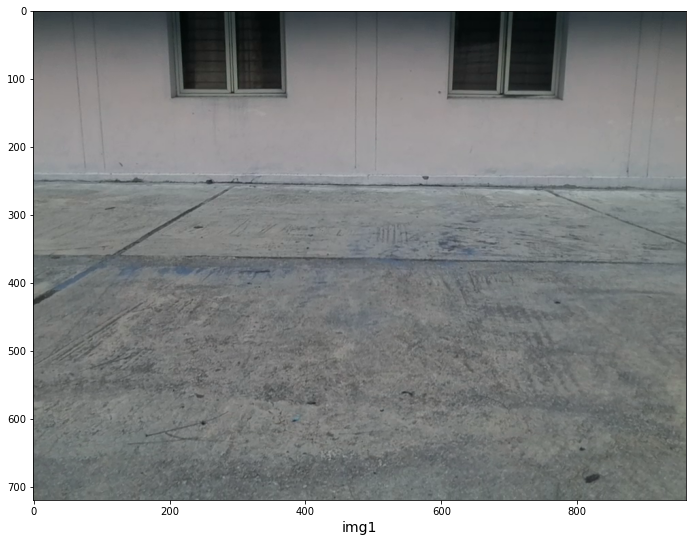

[190, 0, 388, 142]
mapped:190 1166 388 1274
[599, 0, 792, 140]
mapped:599 1166 792 1272


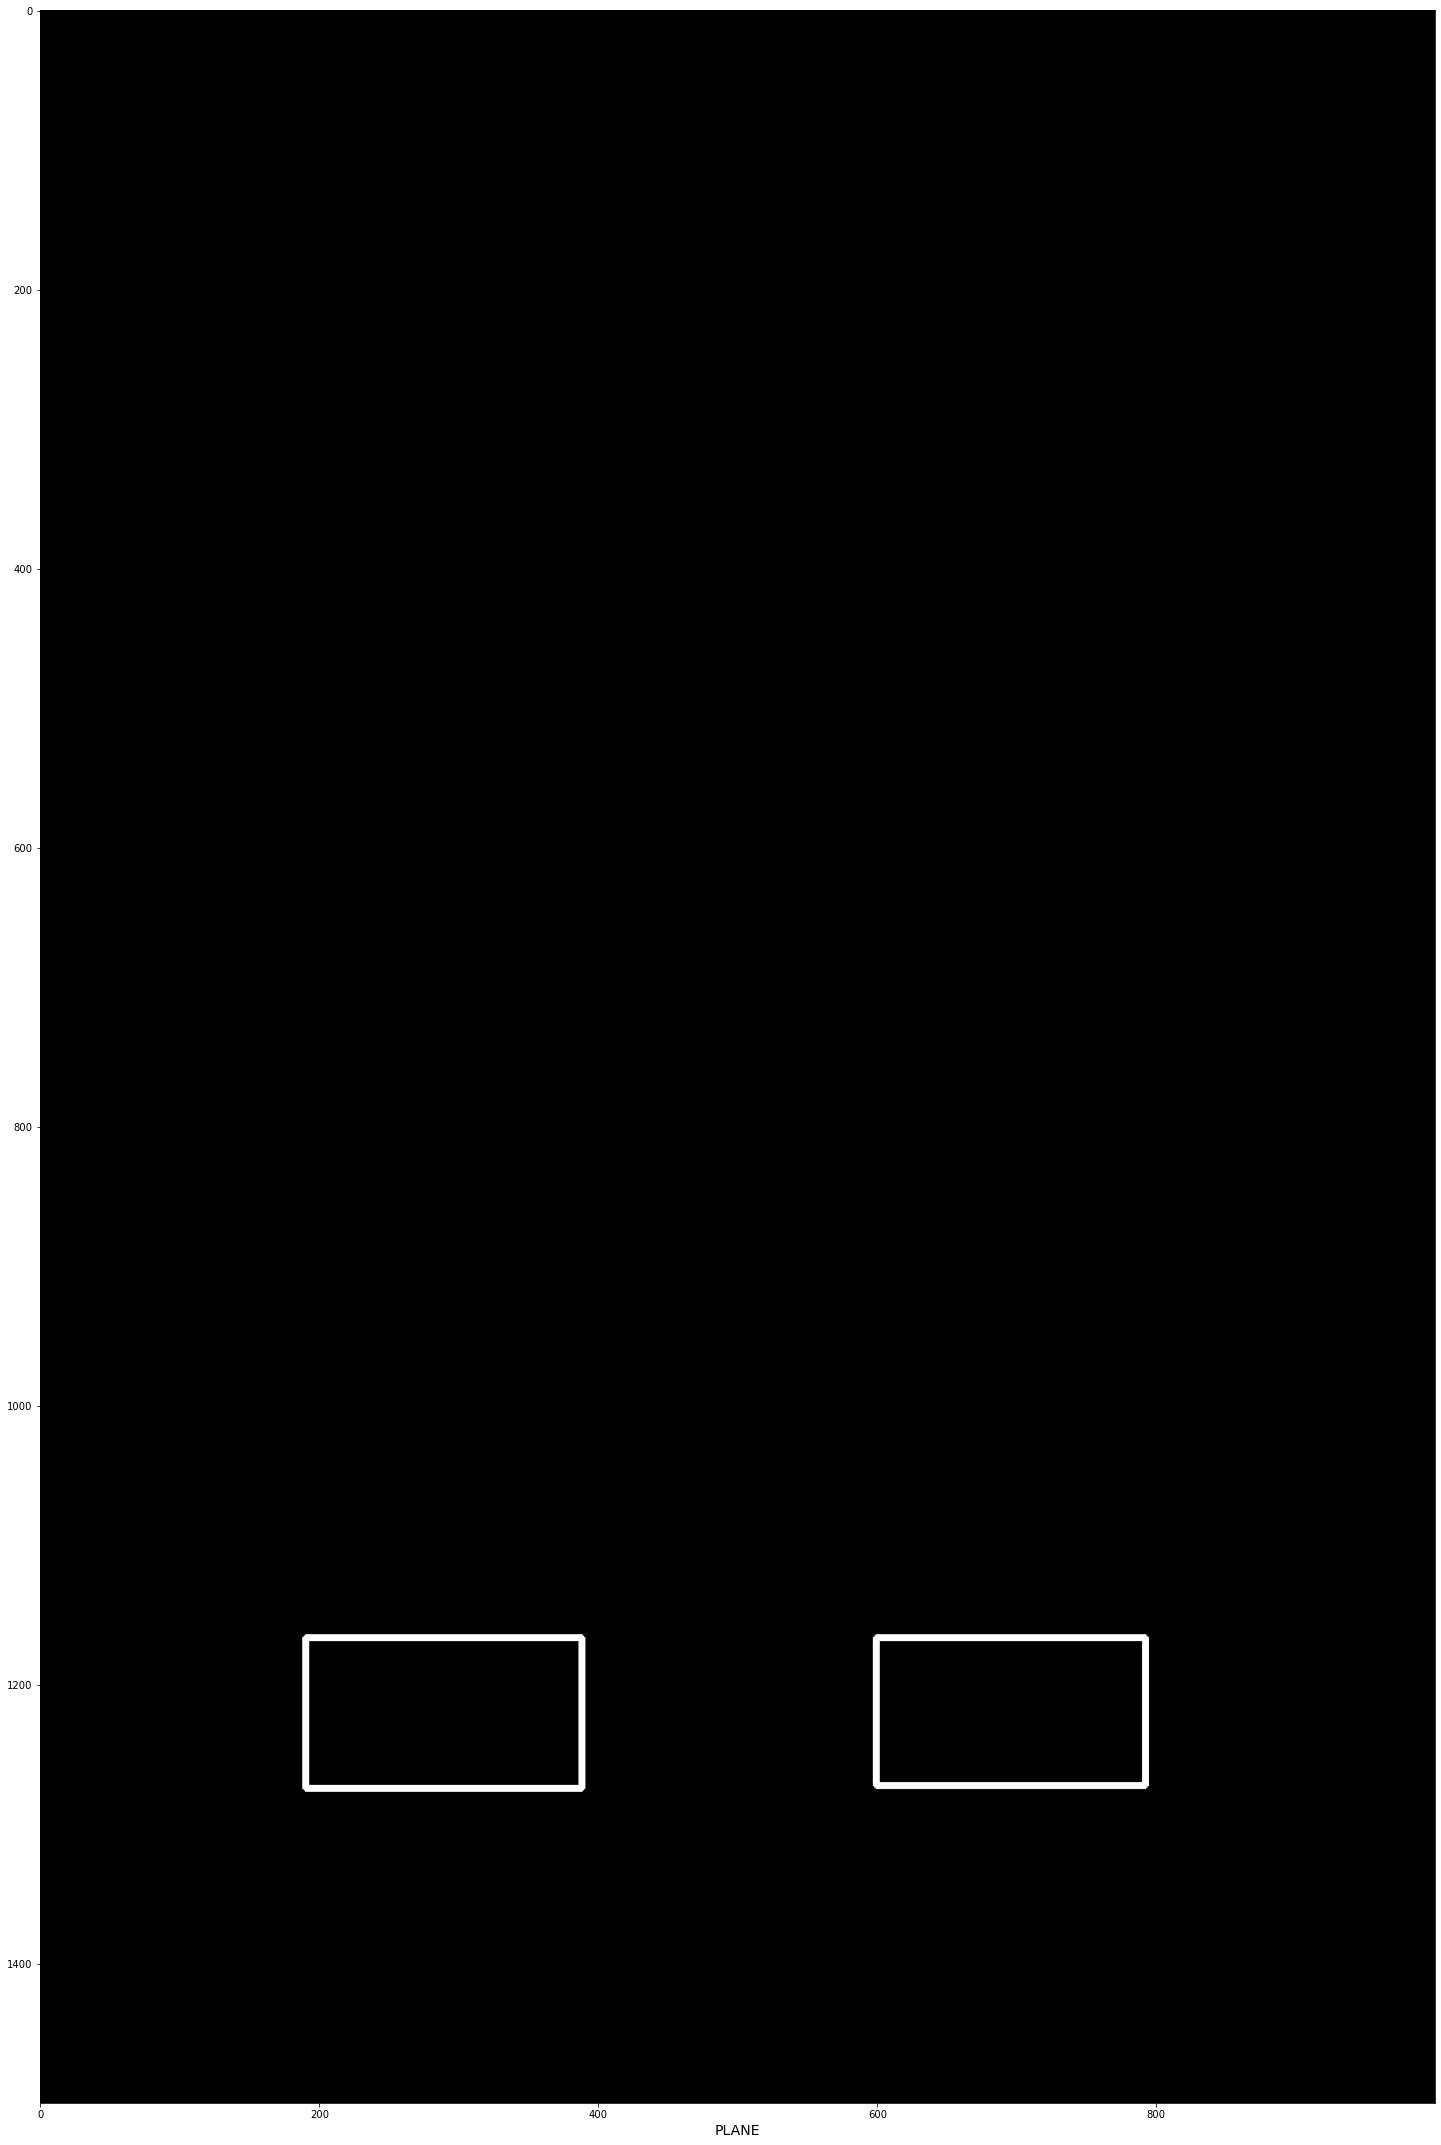

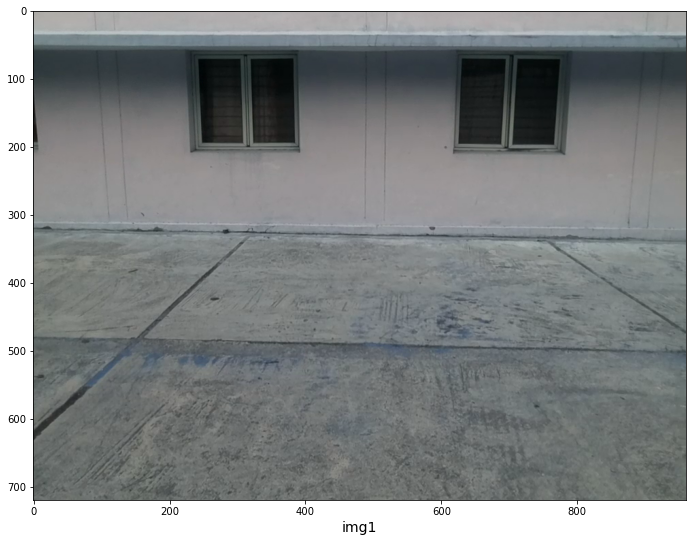

[215, 45, 408, 222]
mapped:215 1150 408 1285
[607, 45, 797, 220]
mapped:607 1150 797 1283


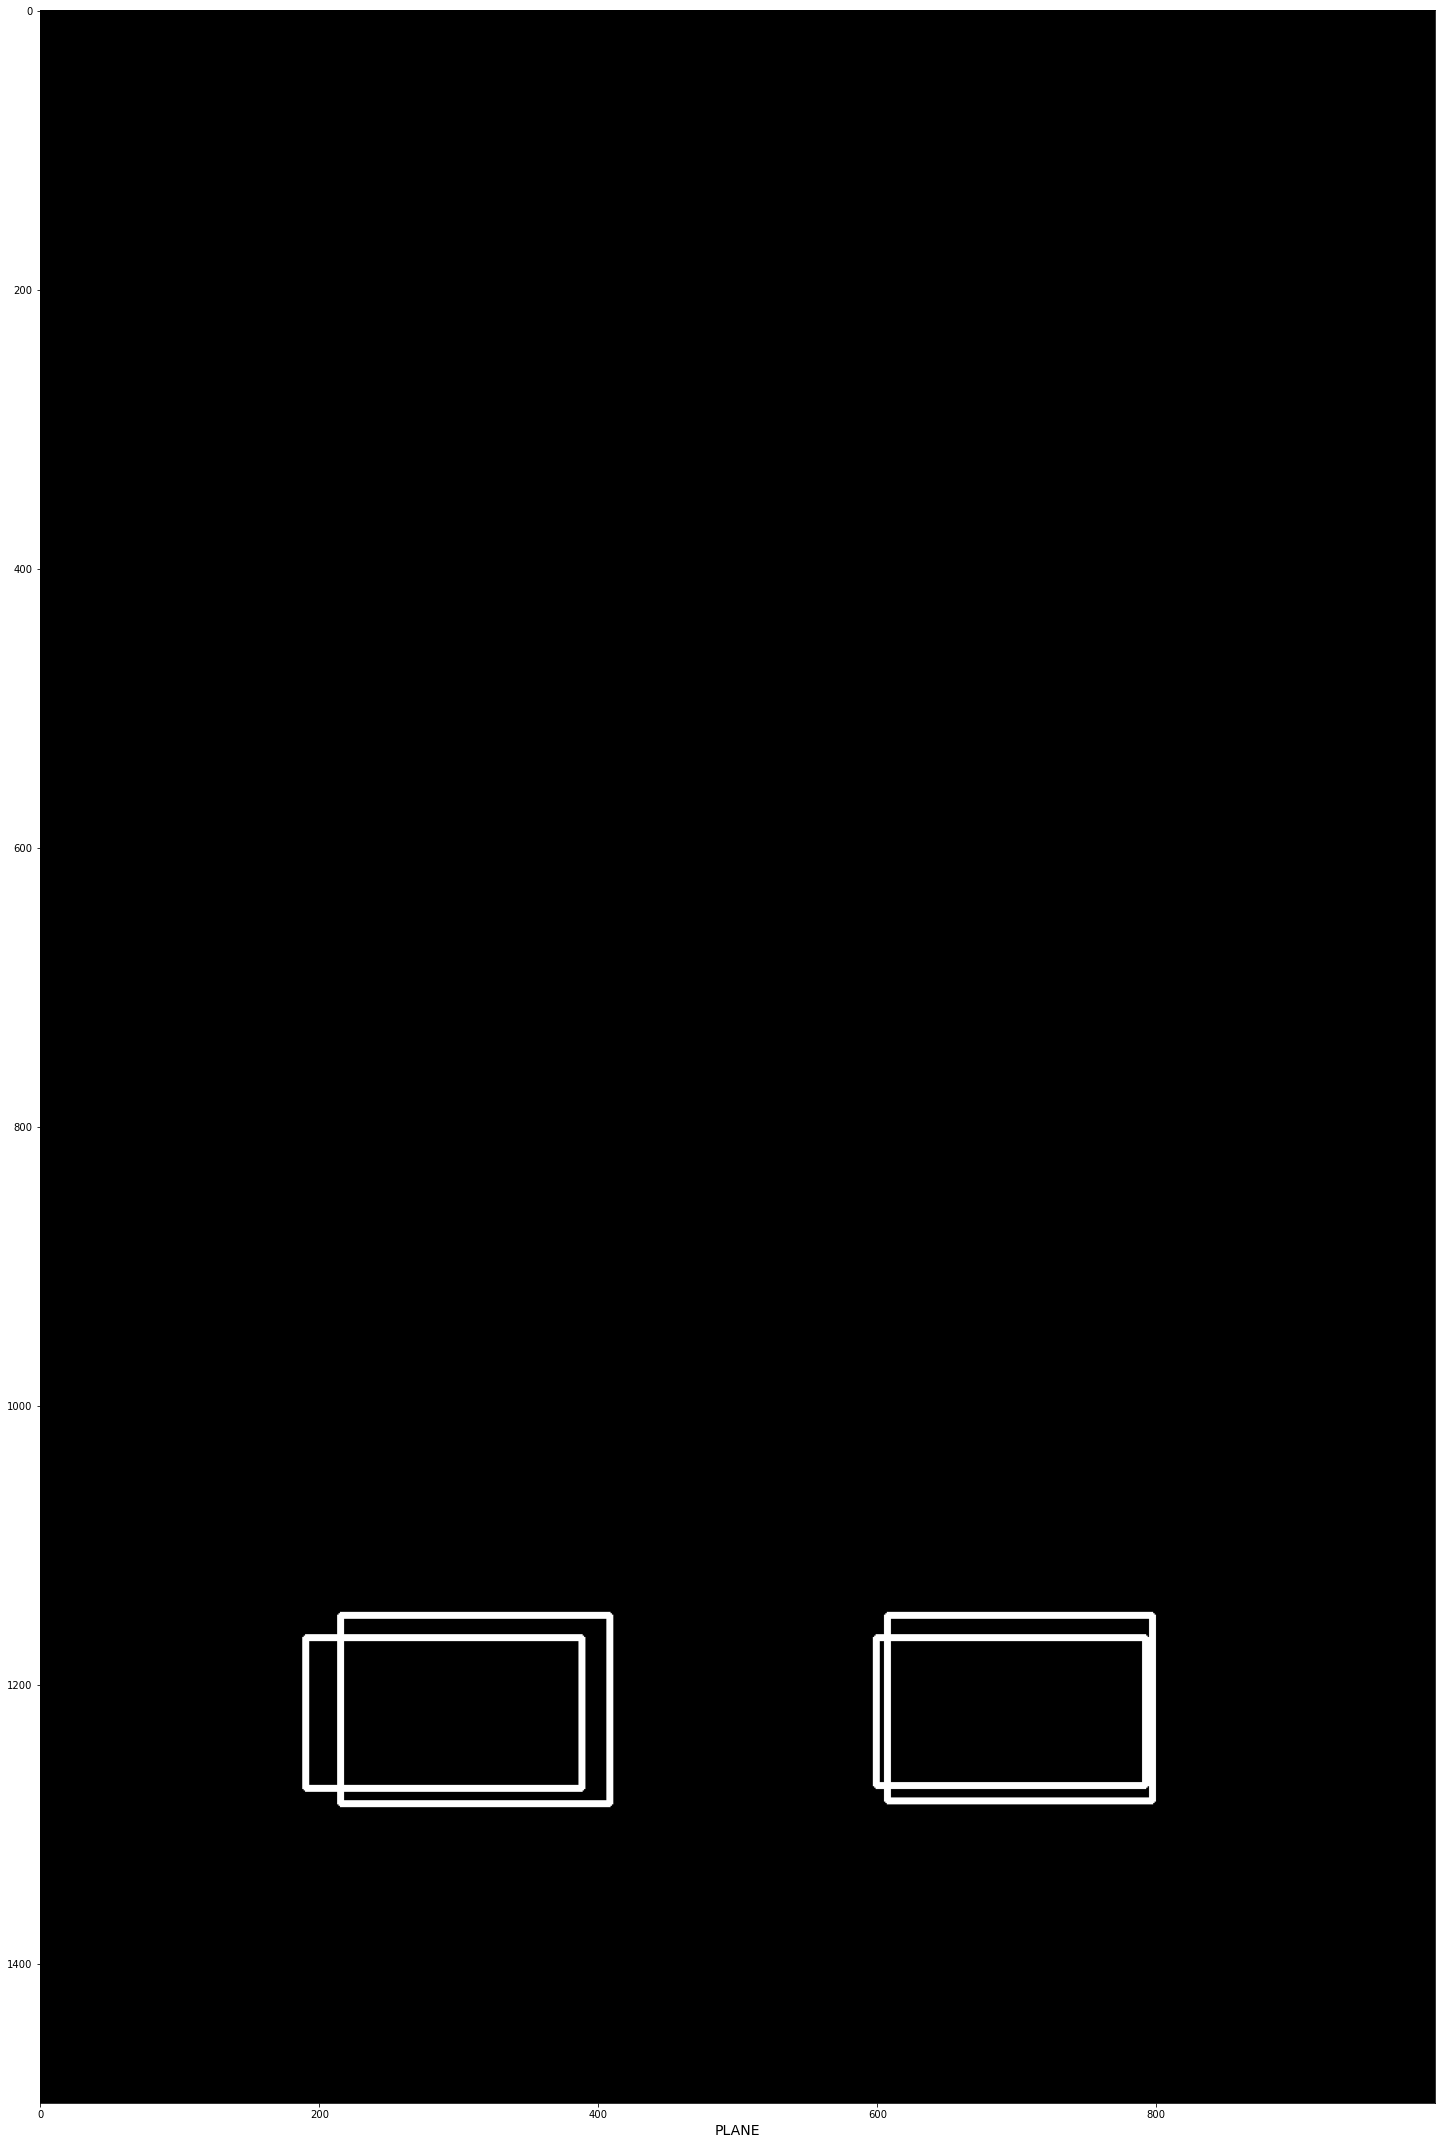

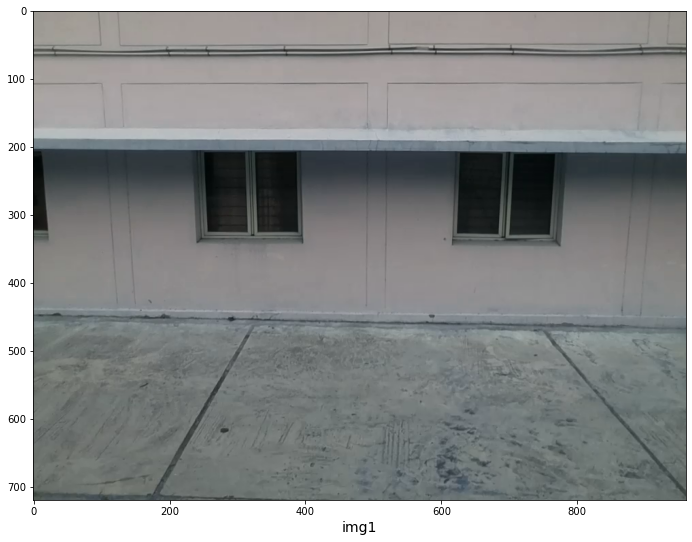

[226, 195, 413, 357]
mapped:226 1144 413 1267
[604, 195, 789, 352]
mapped:604 1144 789 1263


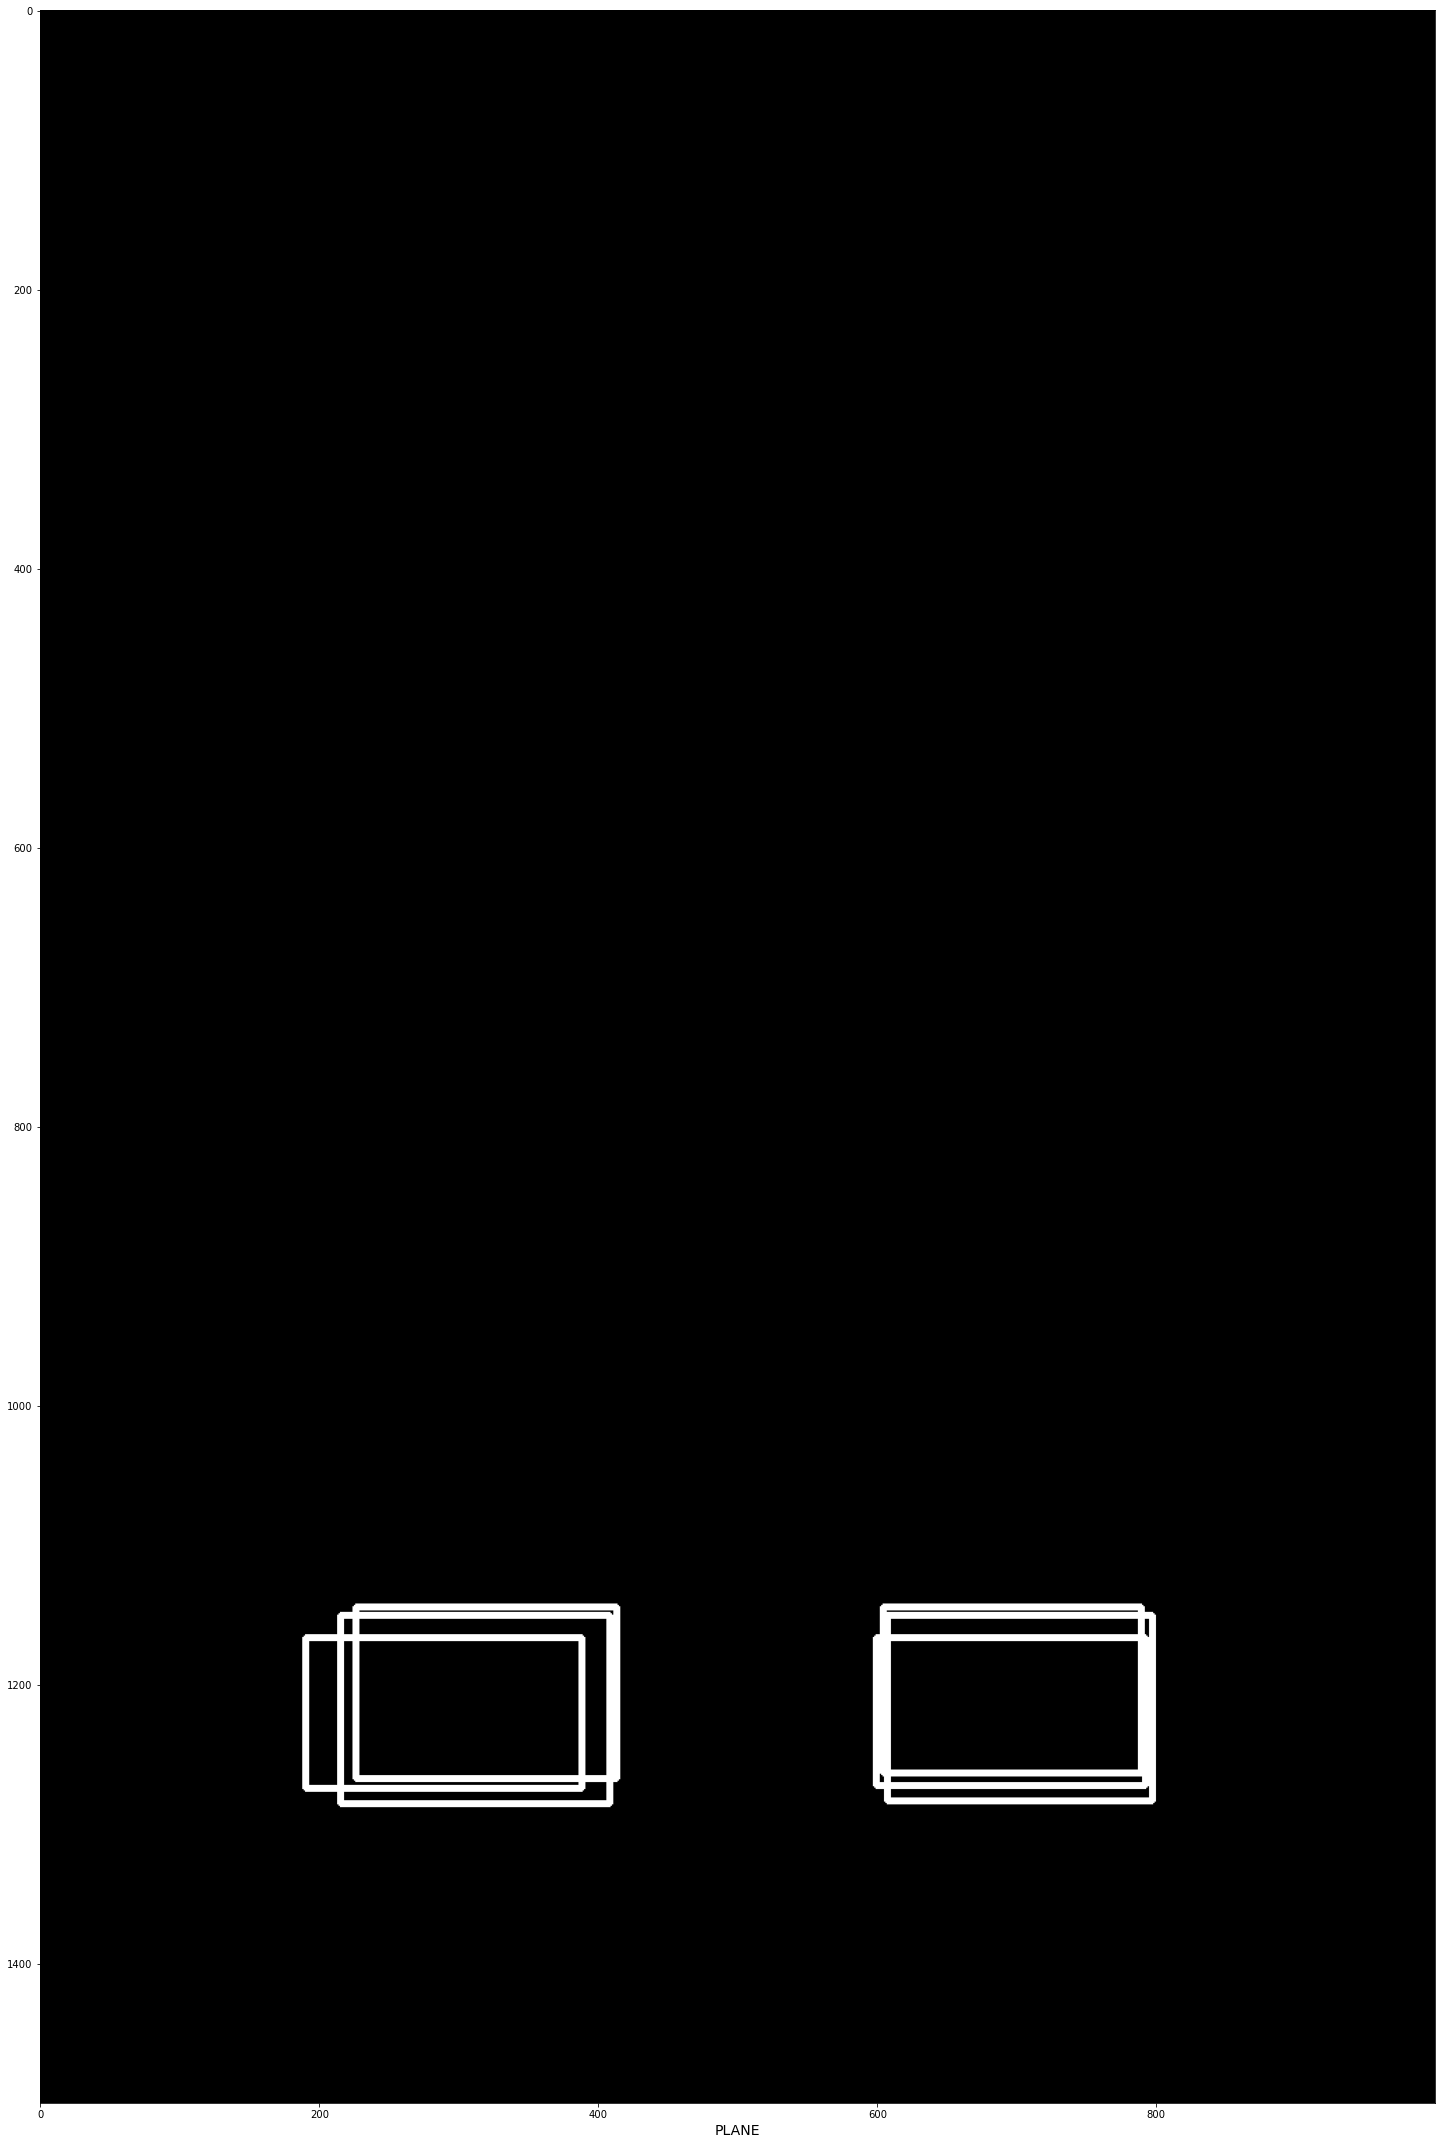

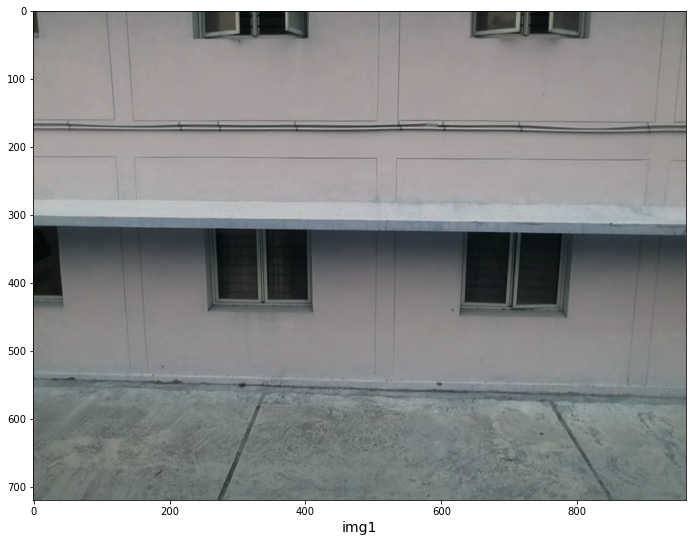

[243, 315, 428, 457]
mapped:243 1135 428 1243
[619, 307, 796, 455]
mapped:619 1129 796 1242


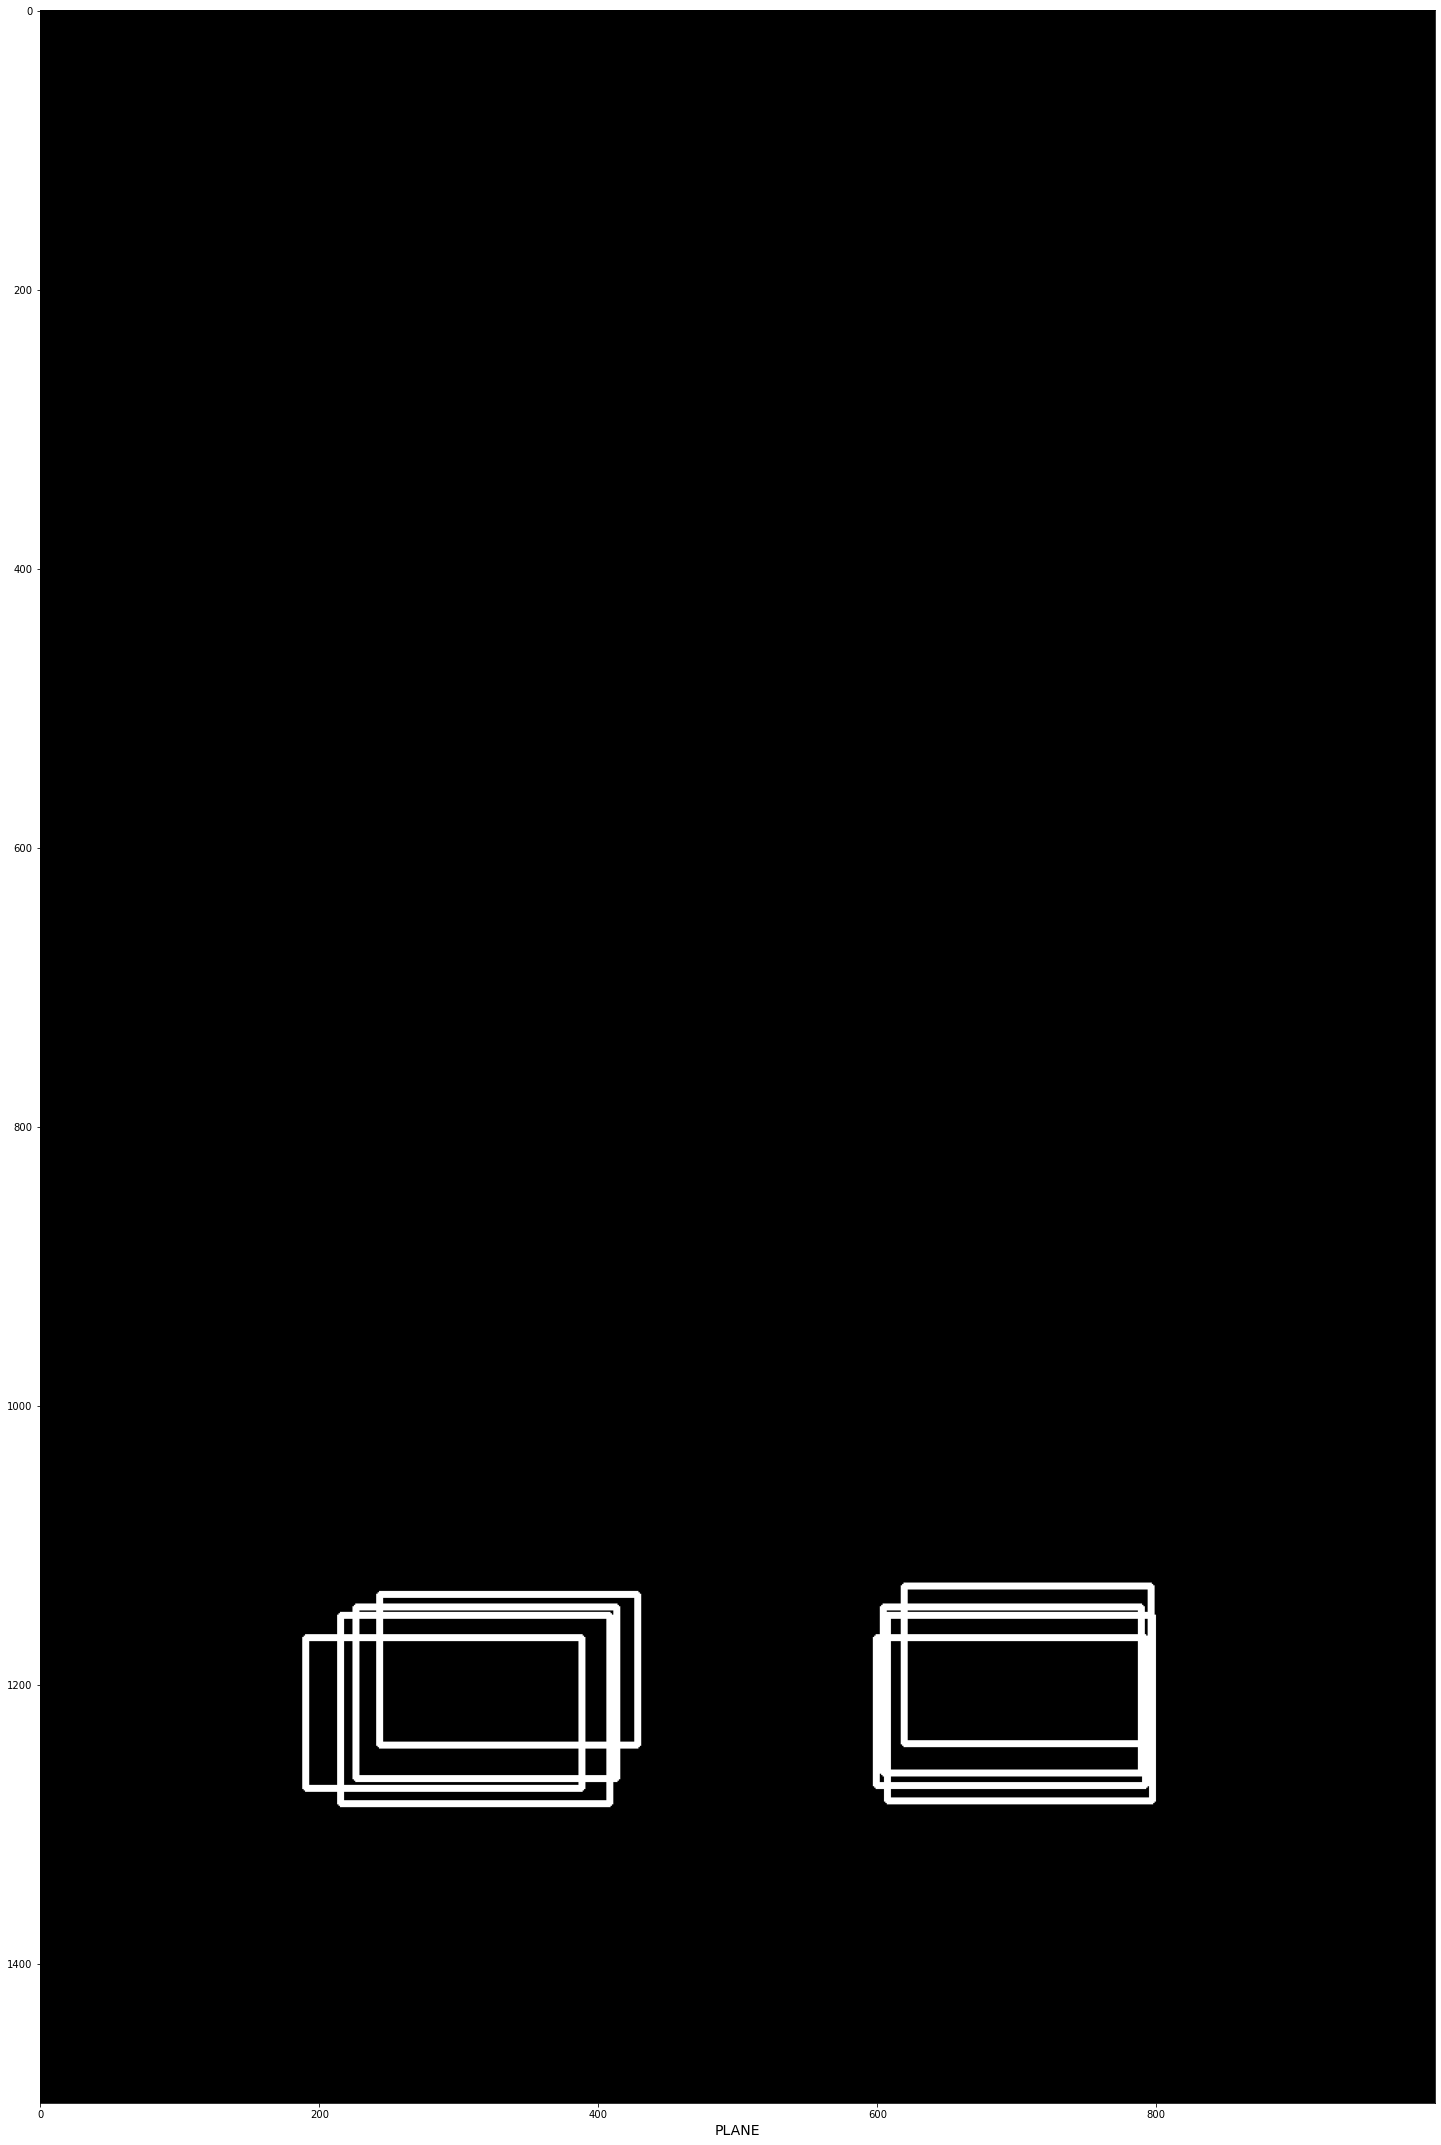

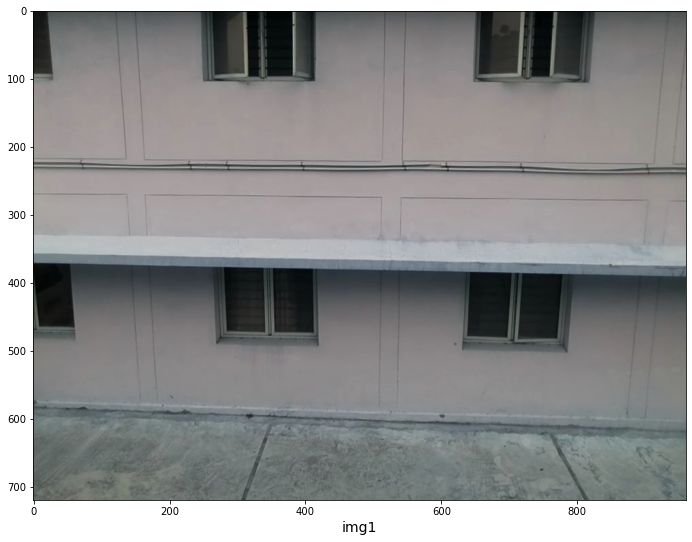

[637, 392, 782, 497]
mapped:637 1144 782 1224
[272, 382, 415, 485]
mapped:272 1136 415 1215
[655, 0, 817, 105]
mapped:655 846 817 925


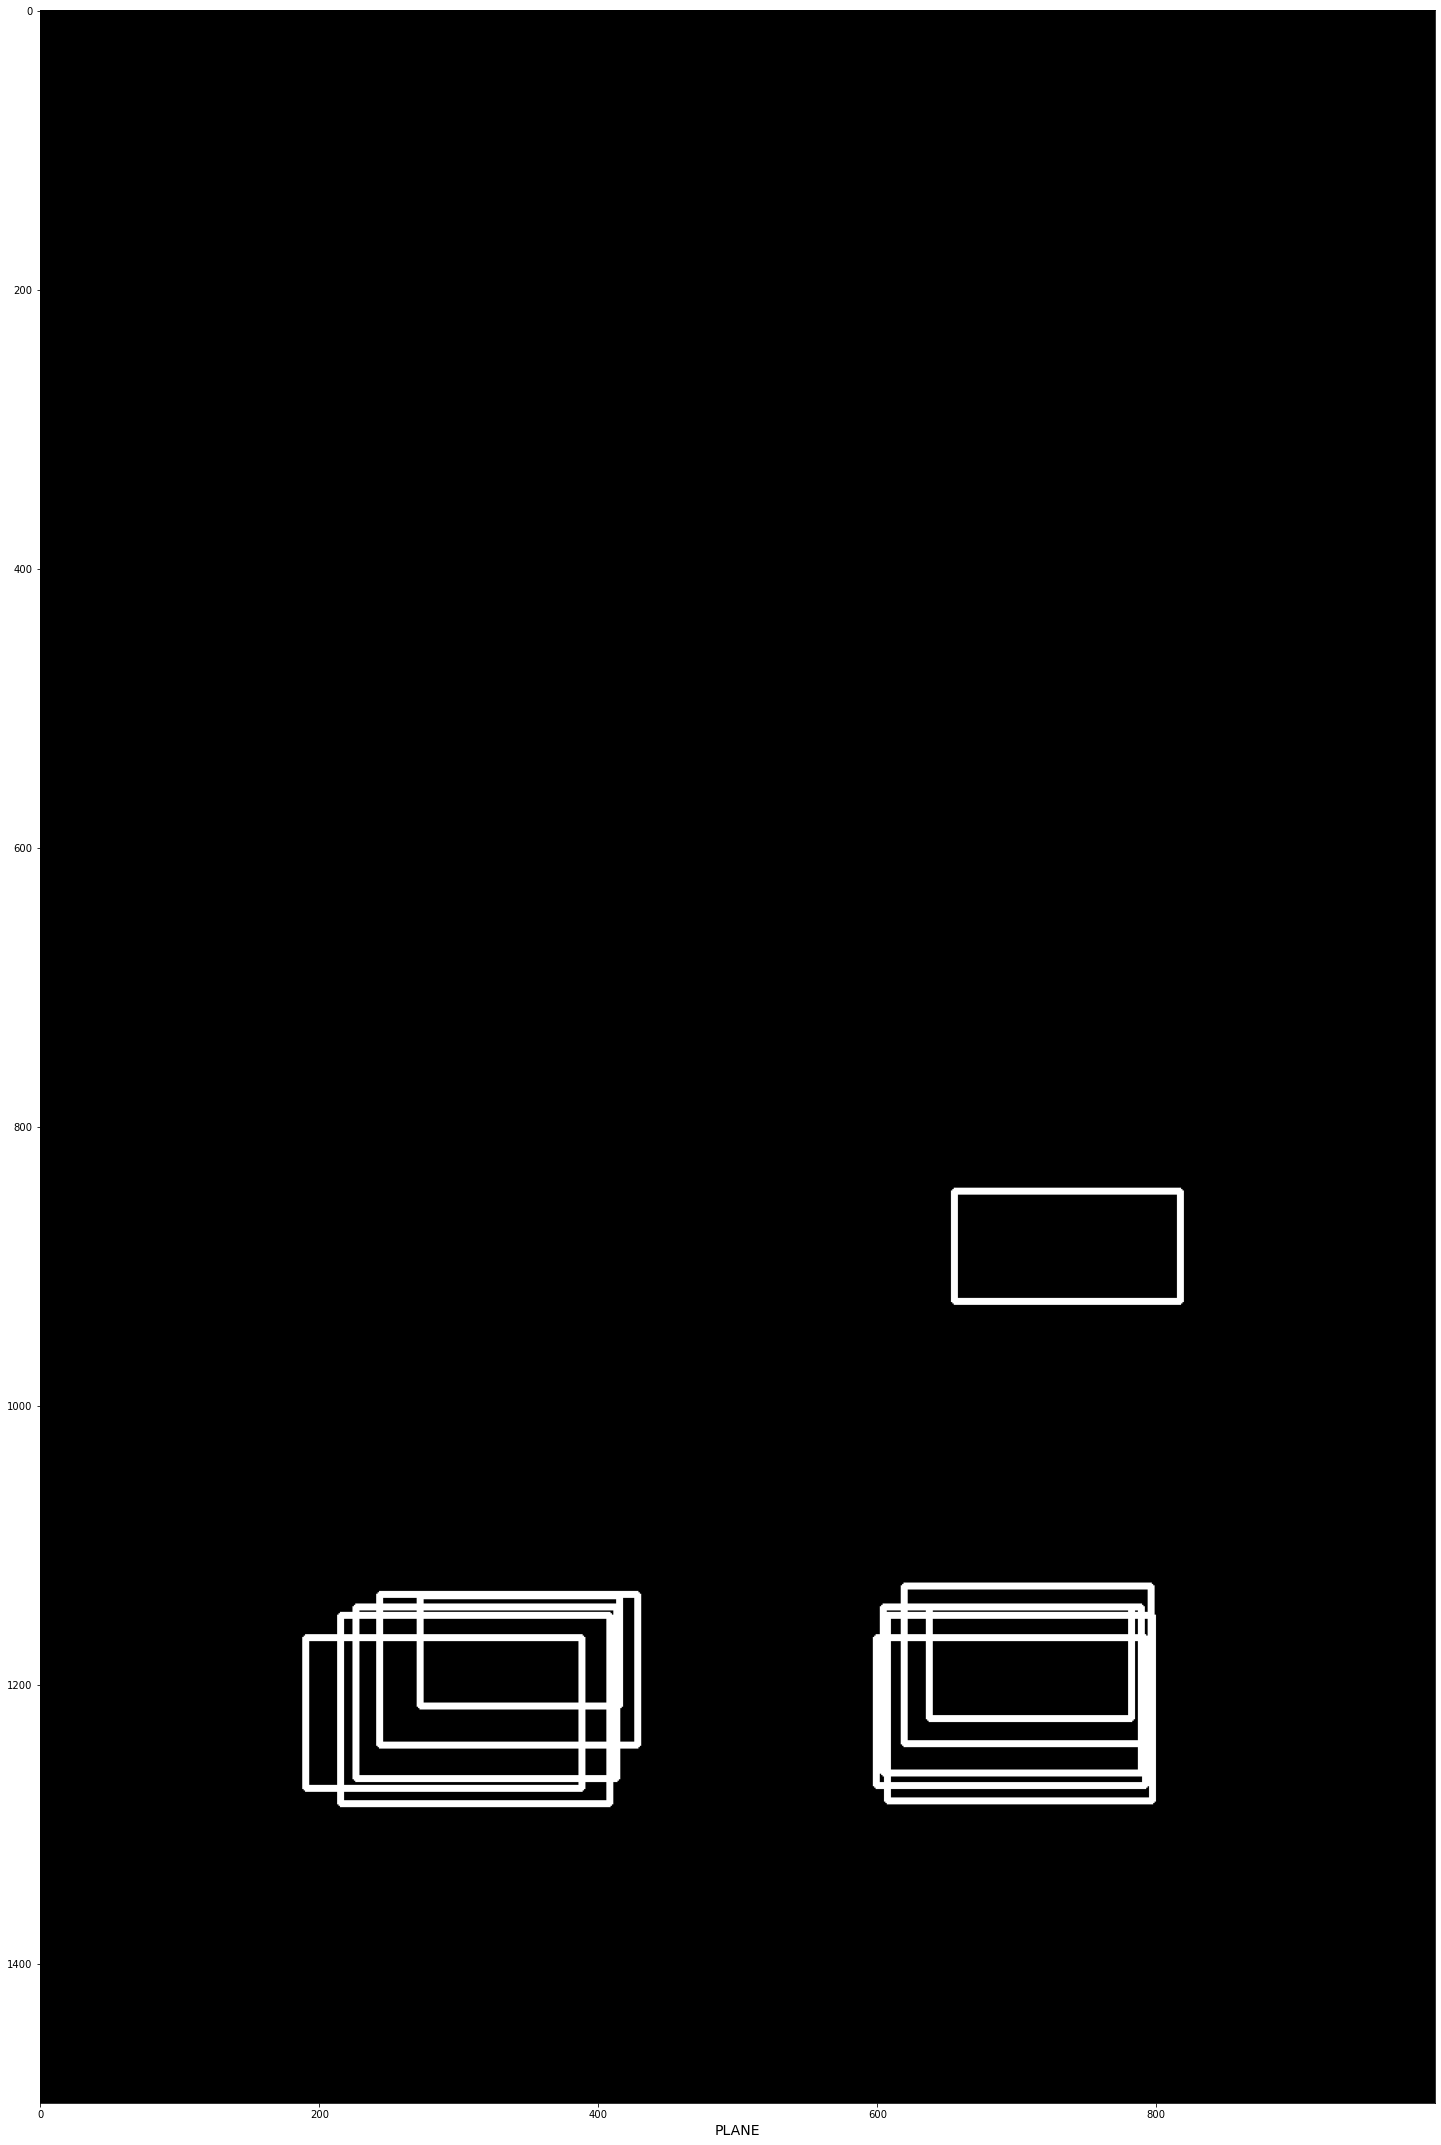

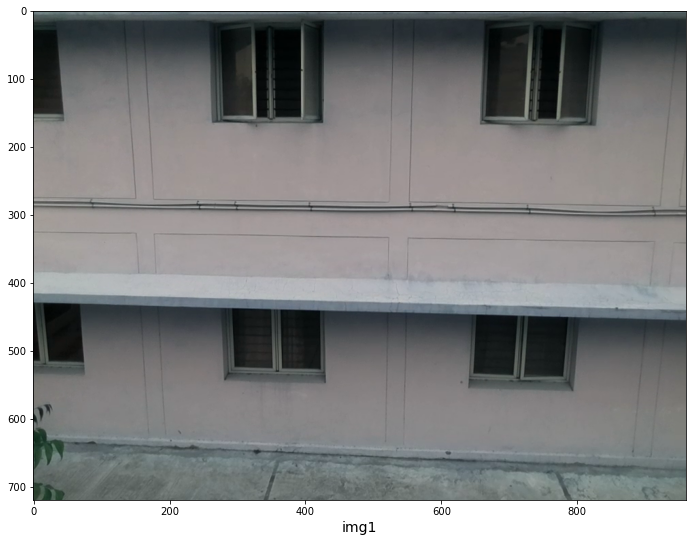

[647, 452, 790, 555]
mapped:647 1150 790 1228
[285, 442, 425, 542]
mapped:285 1142 425 1218
[0, 430, 70, 530]
mapped:0 1133 70 1209
[250, 7, 453, 182]
mapped:250 811 453 944
[665, 22, 822, 167]
mapped:665 822 822 933


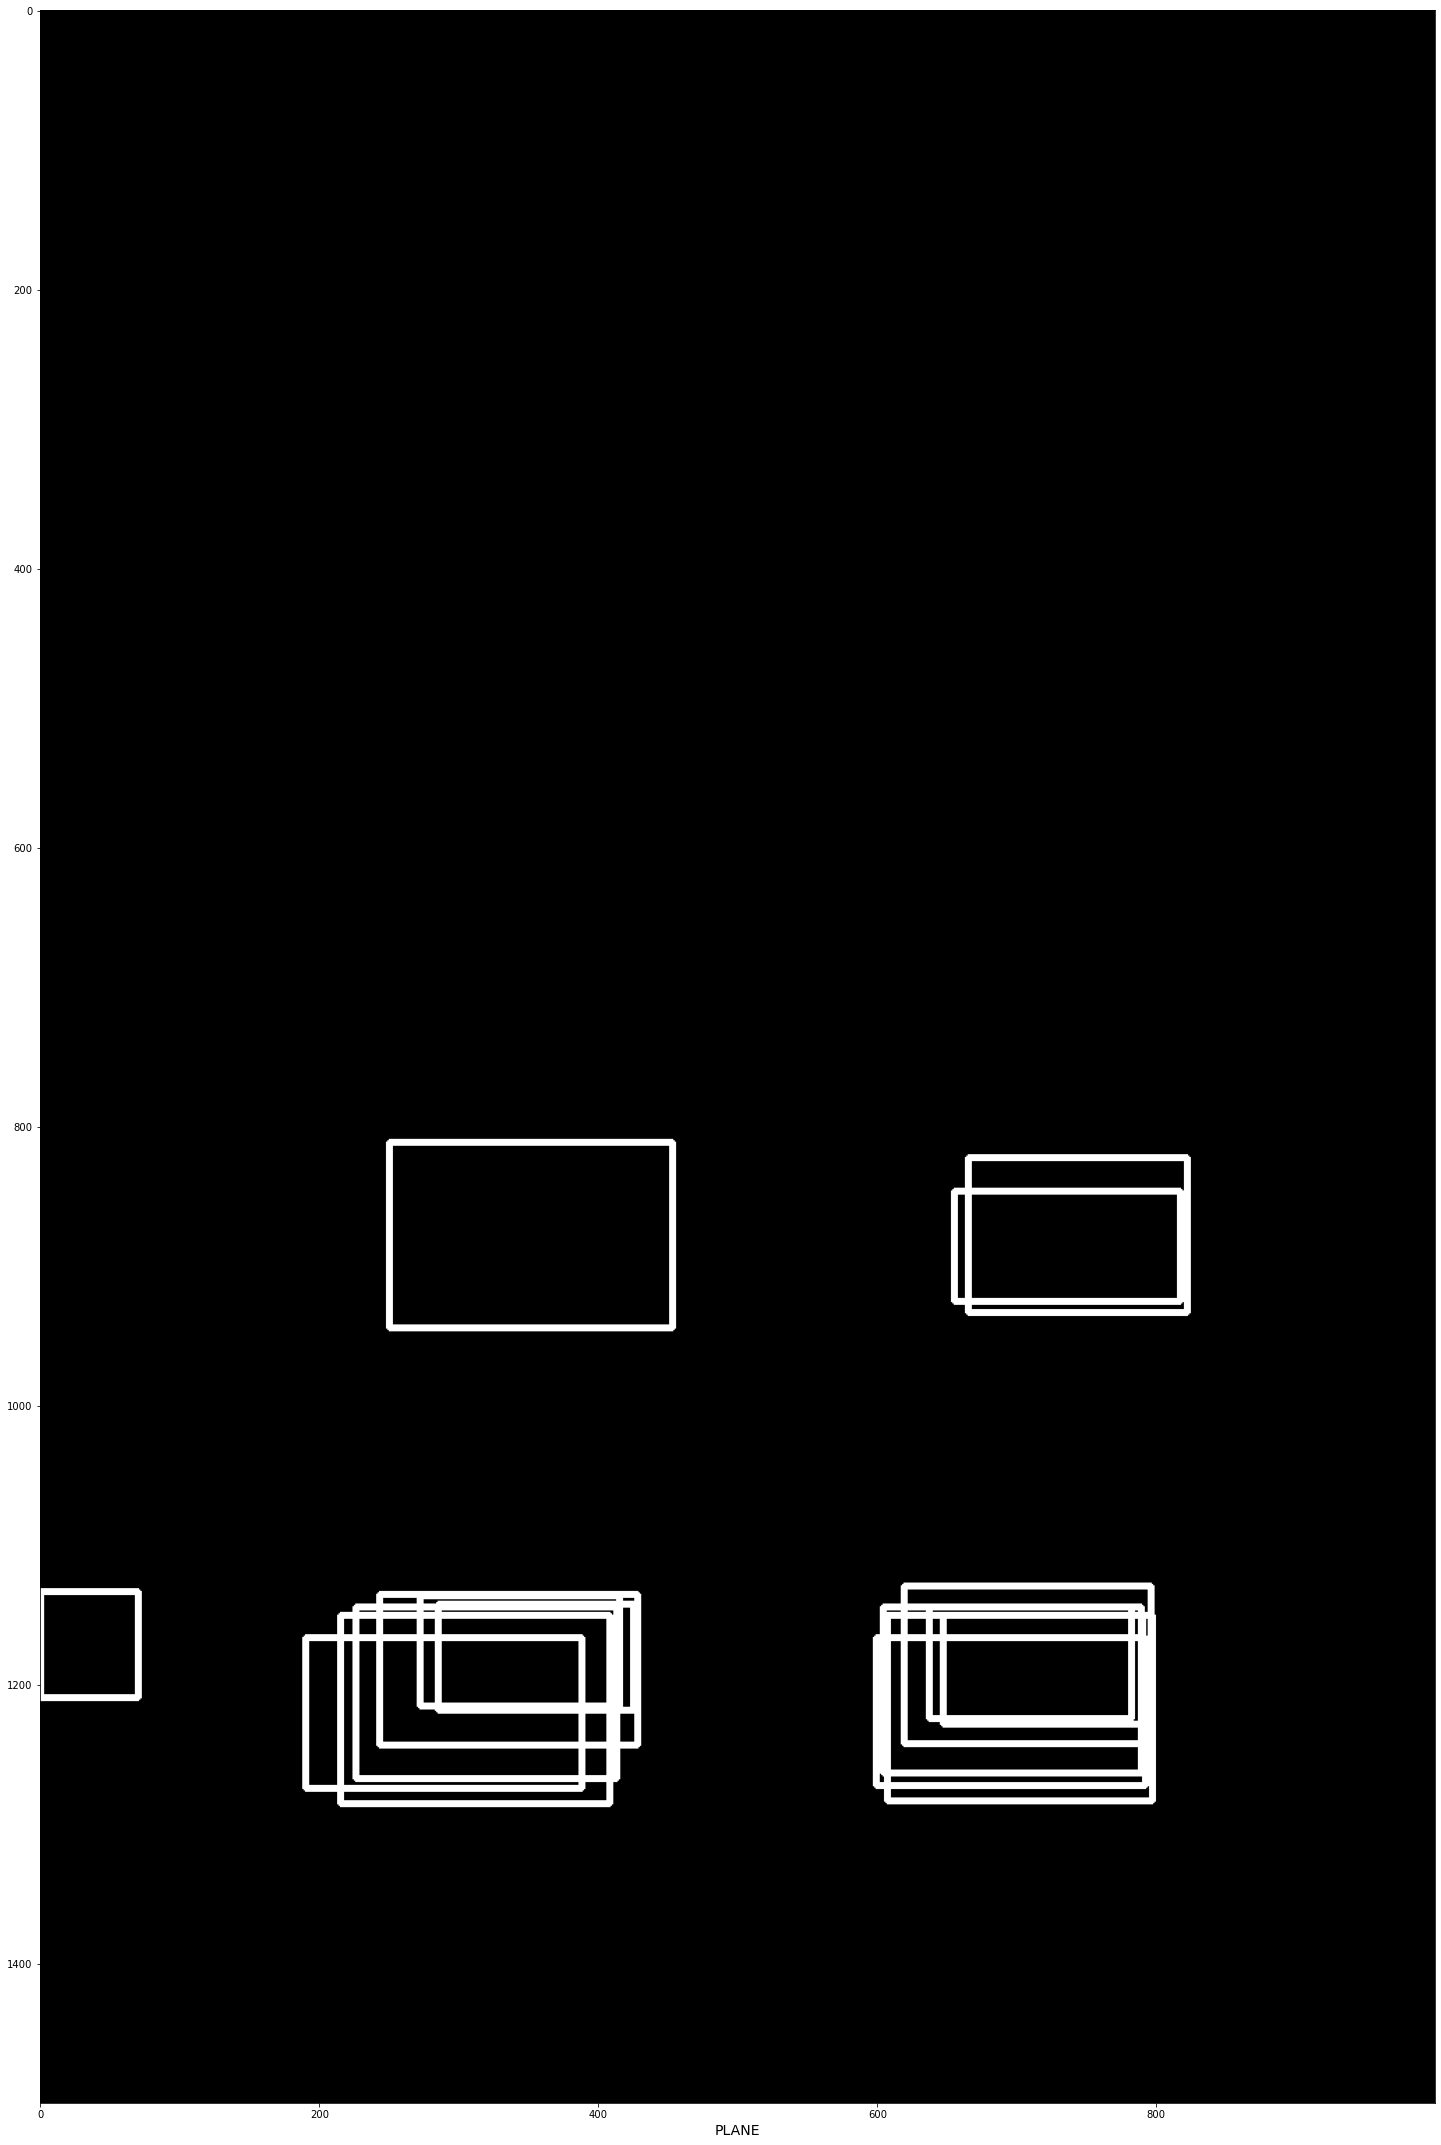

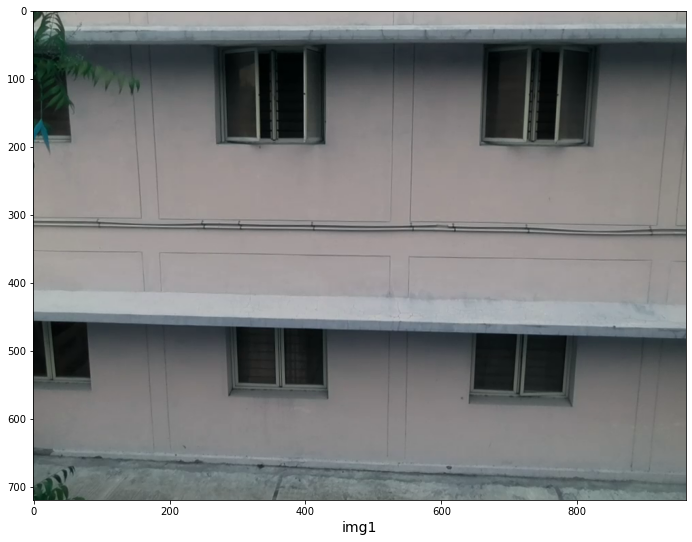

[647, 480, 790, 577]
mapped:647 1141 790 1215
[290, 472, 430, 565]
mapped:290 1135 430 1205
[0, 462, 77, 552]
mapped:0 1127 77 1196
[252, 35, 450, 215]
mapped:252 802 450 939
[647, 35, 840, 212]
mapped:647 802 840 937


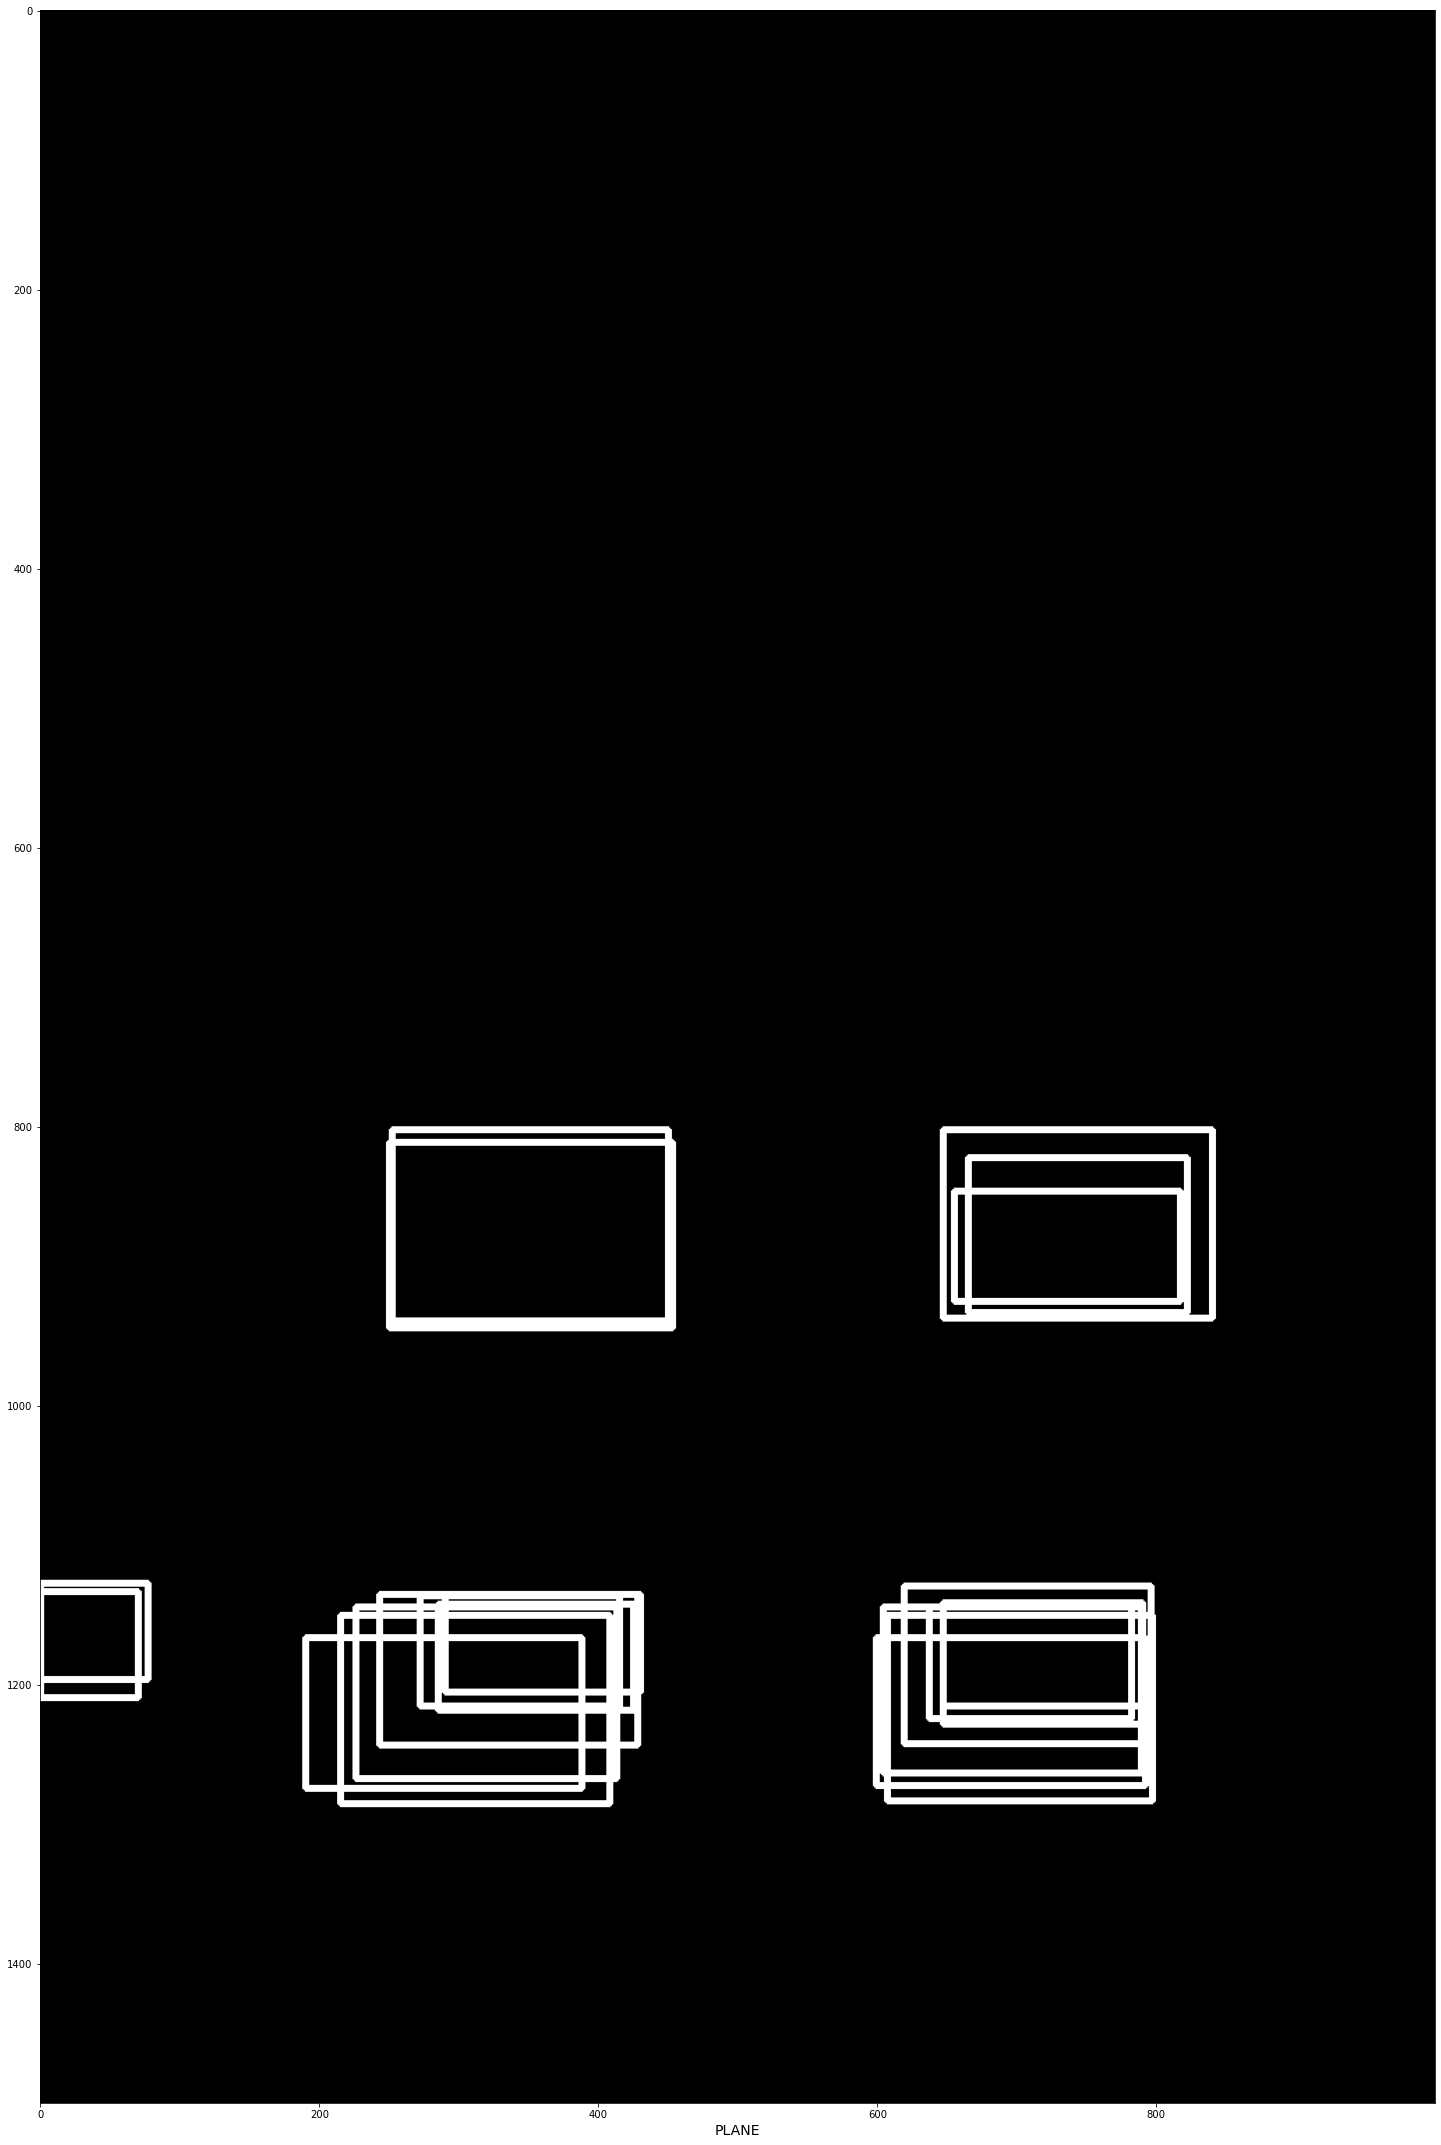

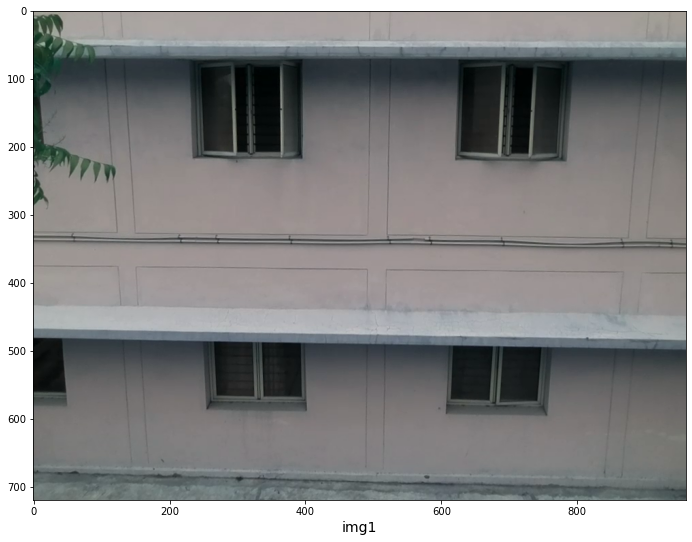

[615, 500, 752, 590]
mapped:615 1126 752 1195
[255, 492, 395, 582]
mapped:255 1120 395 1188
[627, 75, 780, 220]
mapped:627 803 780 913
[237, 75, 387, 217]
mapped:237 803 387 911


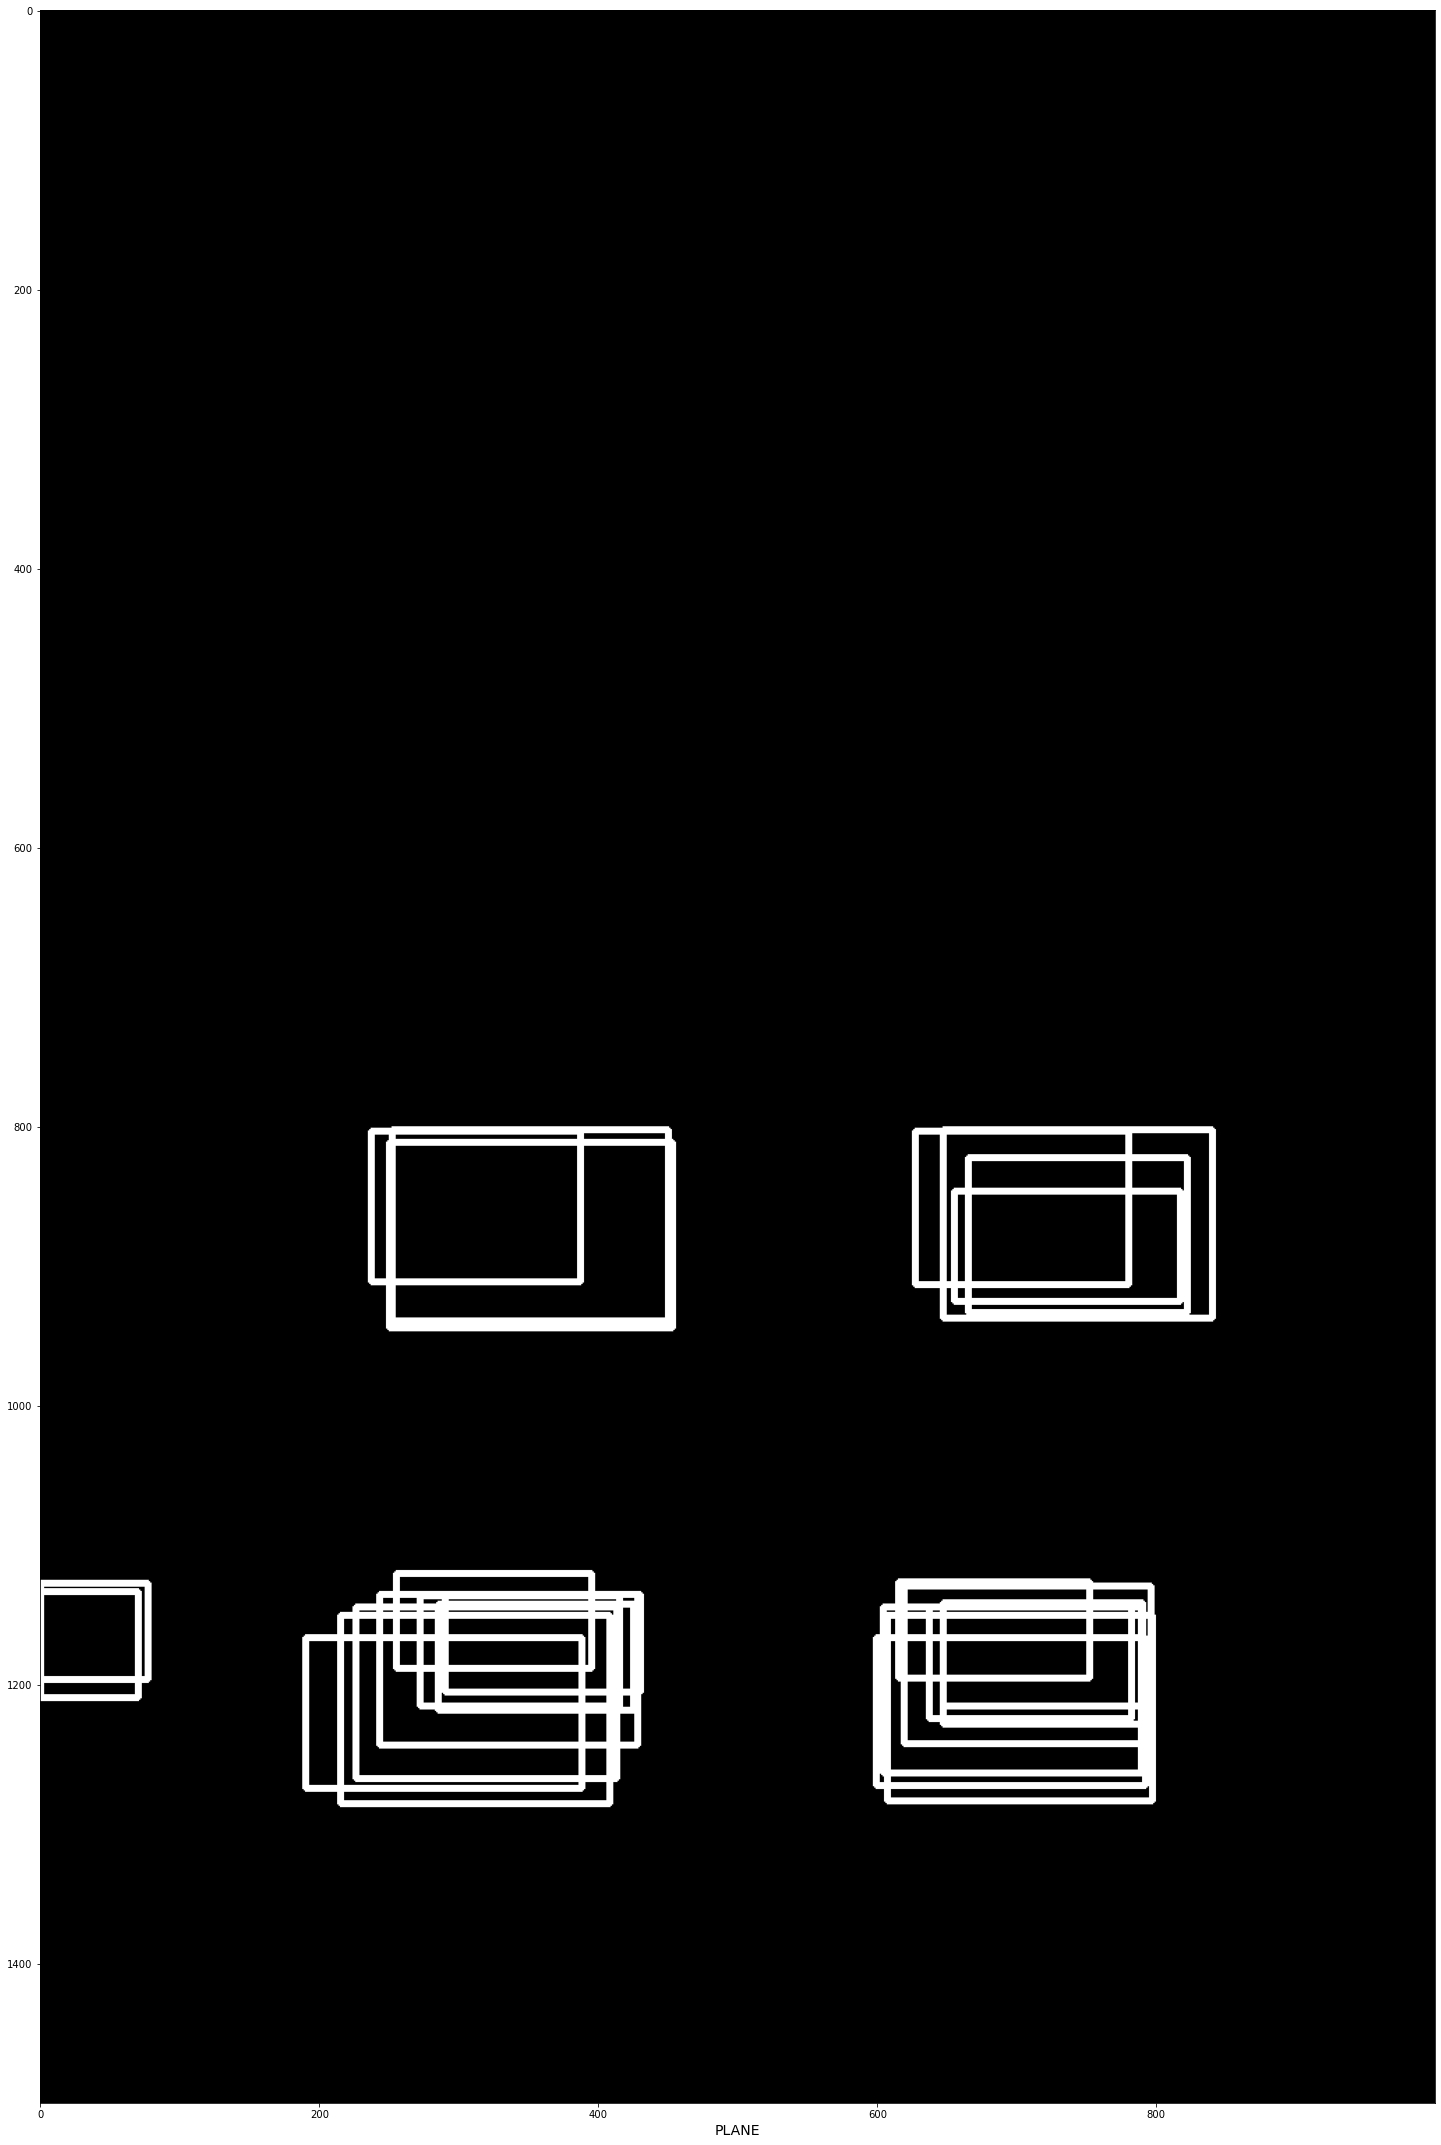

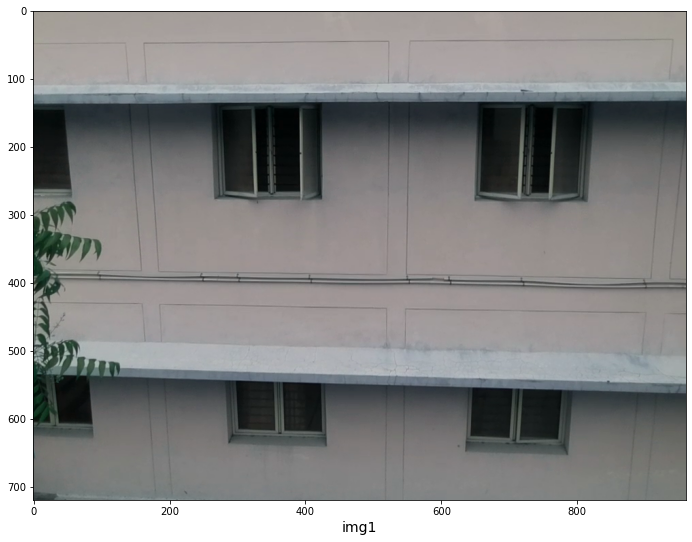

[642, 560, 782, 647]
mapped:642 1142 782 1208
[290, 552, 427, 635]
mapped:290 1136 427 1199
[660, 140, 812, 280]
mapped:660 822 812 929
[267, 140, 415, 277]
mapped:267 822 415 926


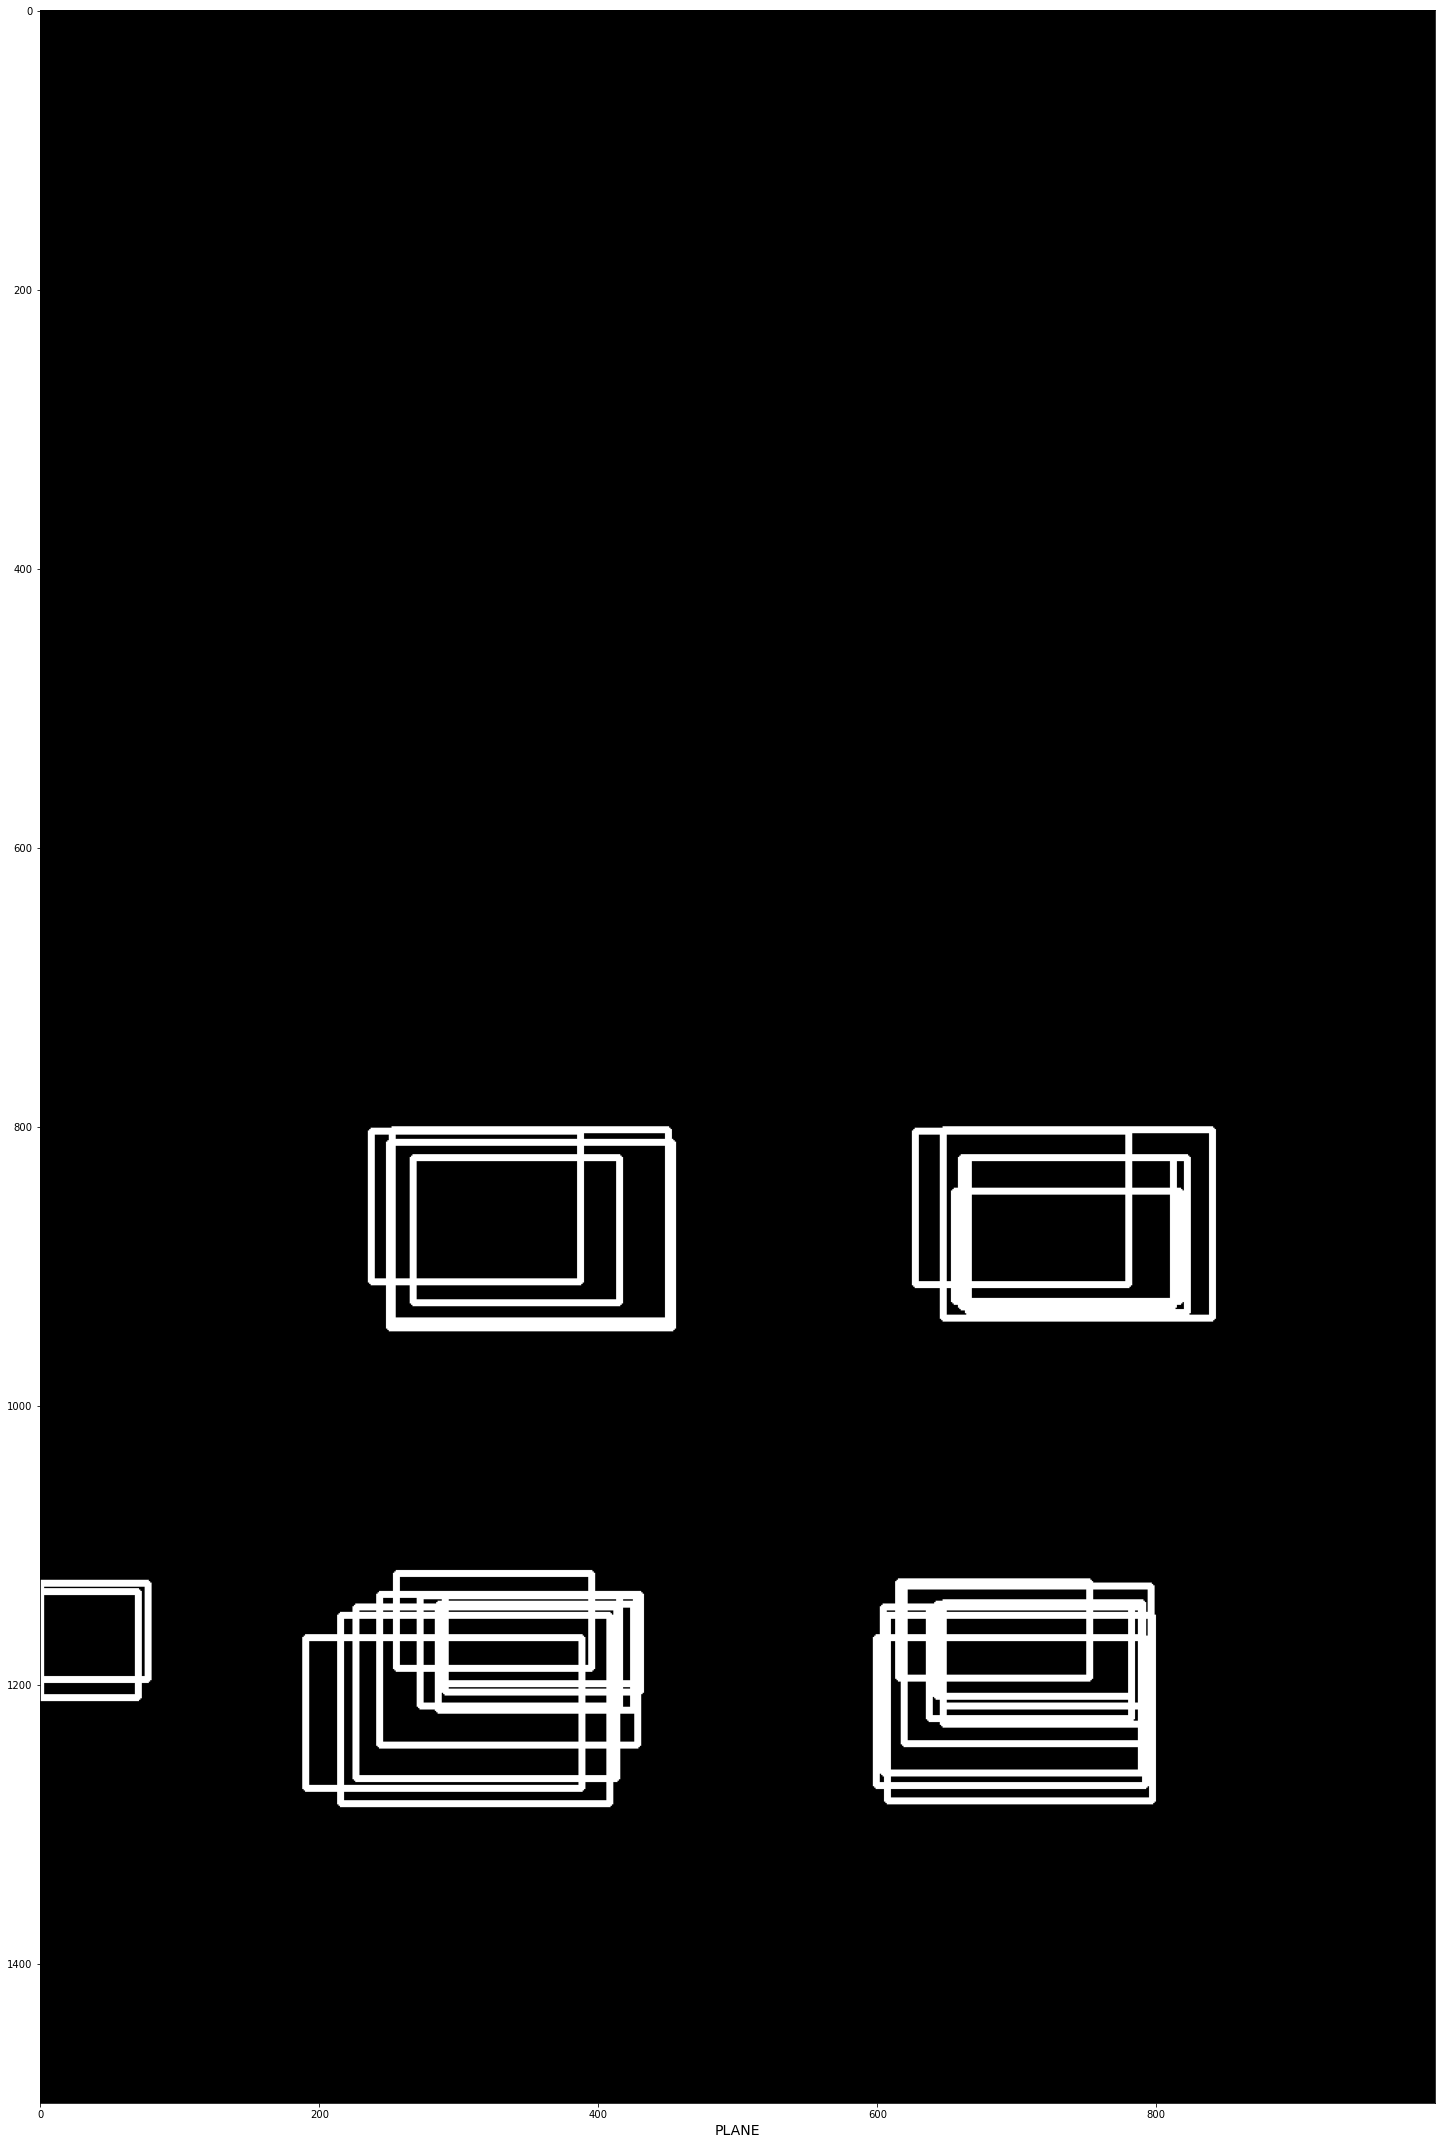

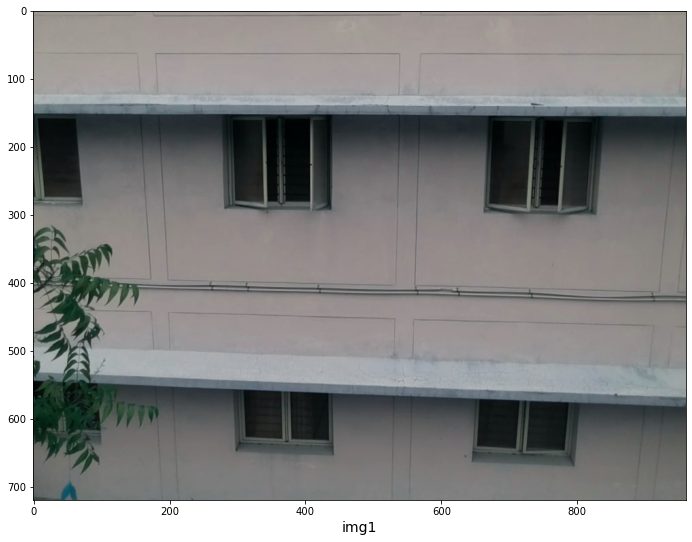

[652, 577, 792, 662]
mapped:652 1135 792 1199
[300, 562, 437, 647]
mapped:300 1123 437 1188
[670, 160, 825, 297]
mapped:670 817 825 922
[342, 142, 424, 297]
mapped:342 804 424 922
[0, 157, 67, 280]
mapped:0 815 67 909


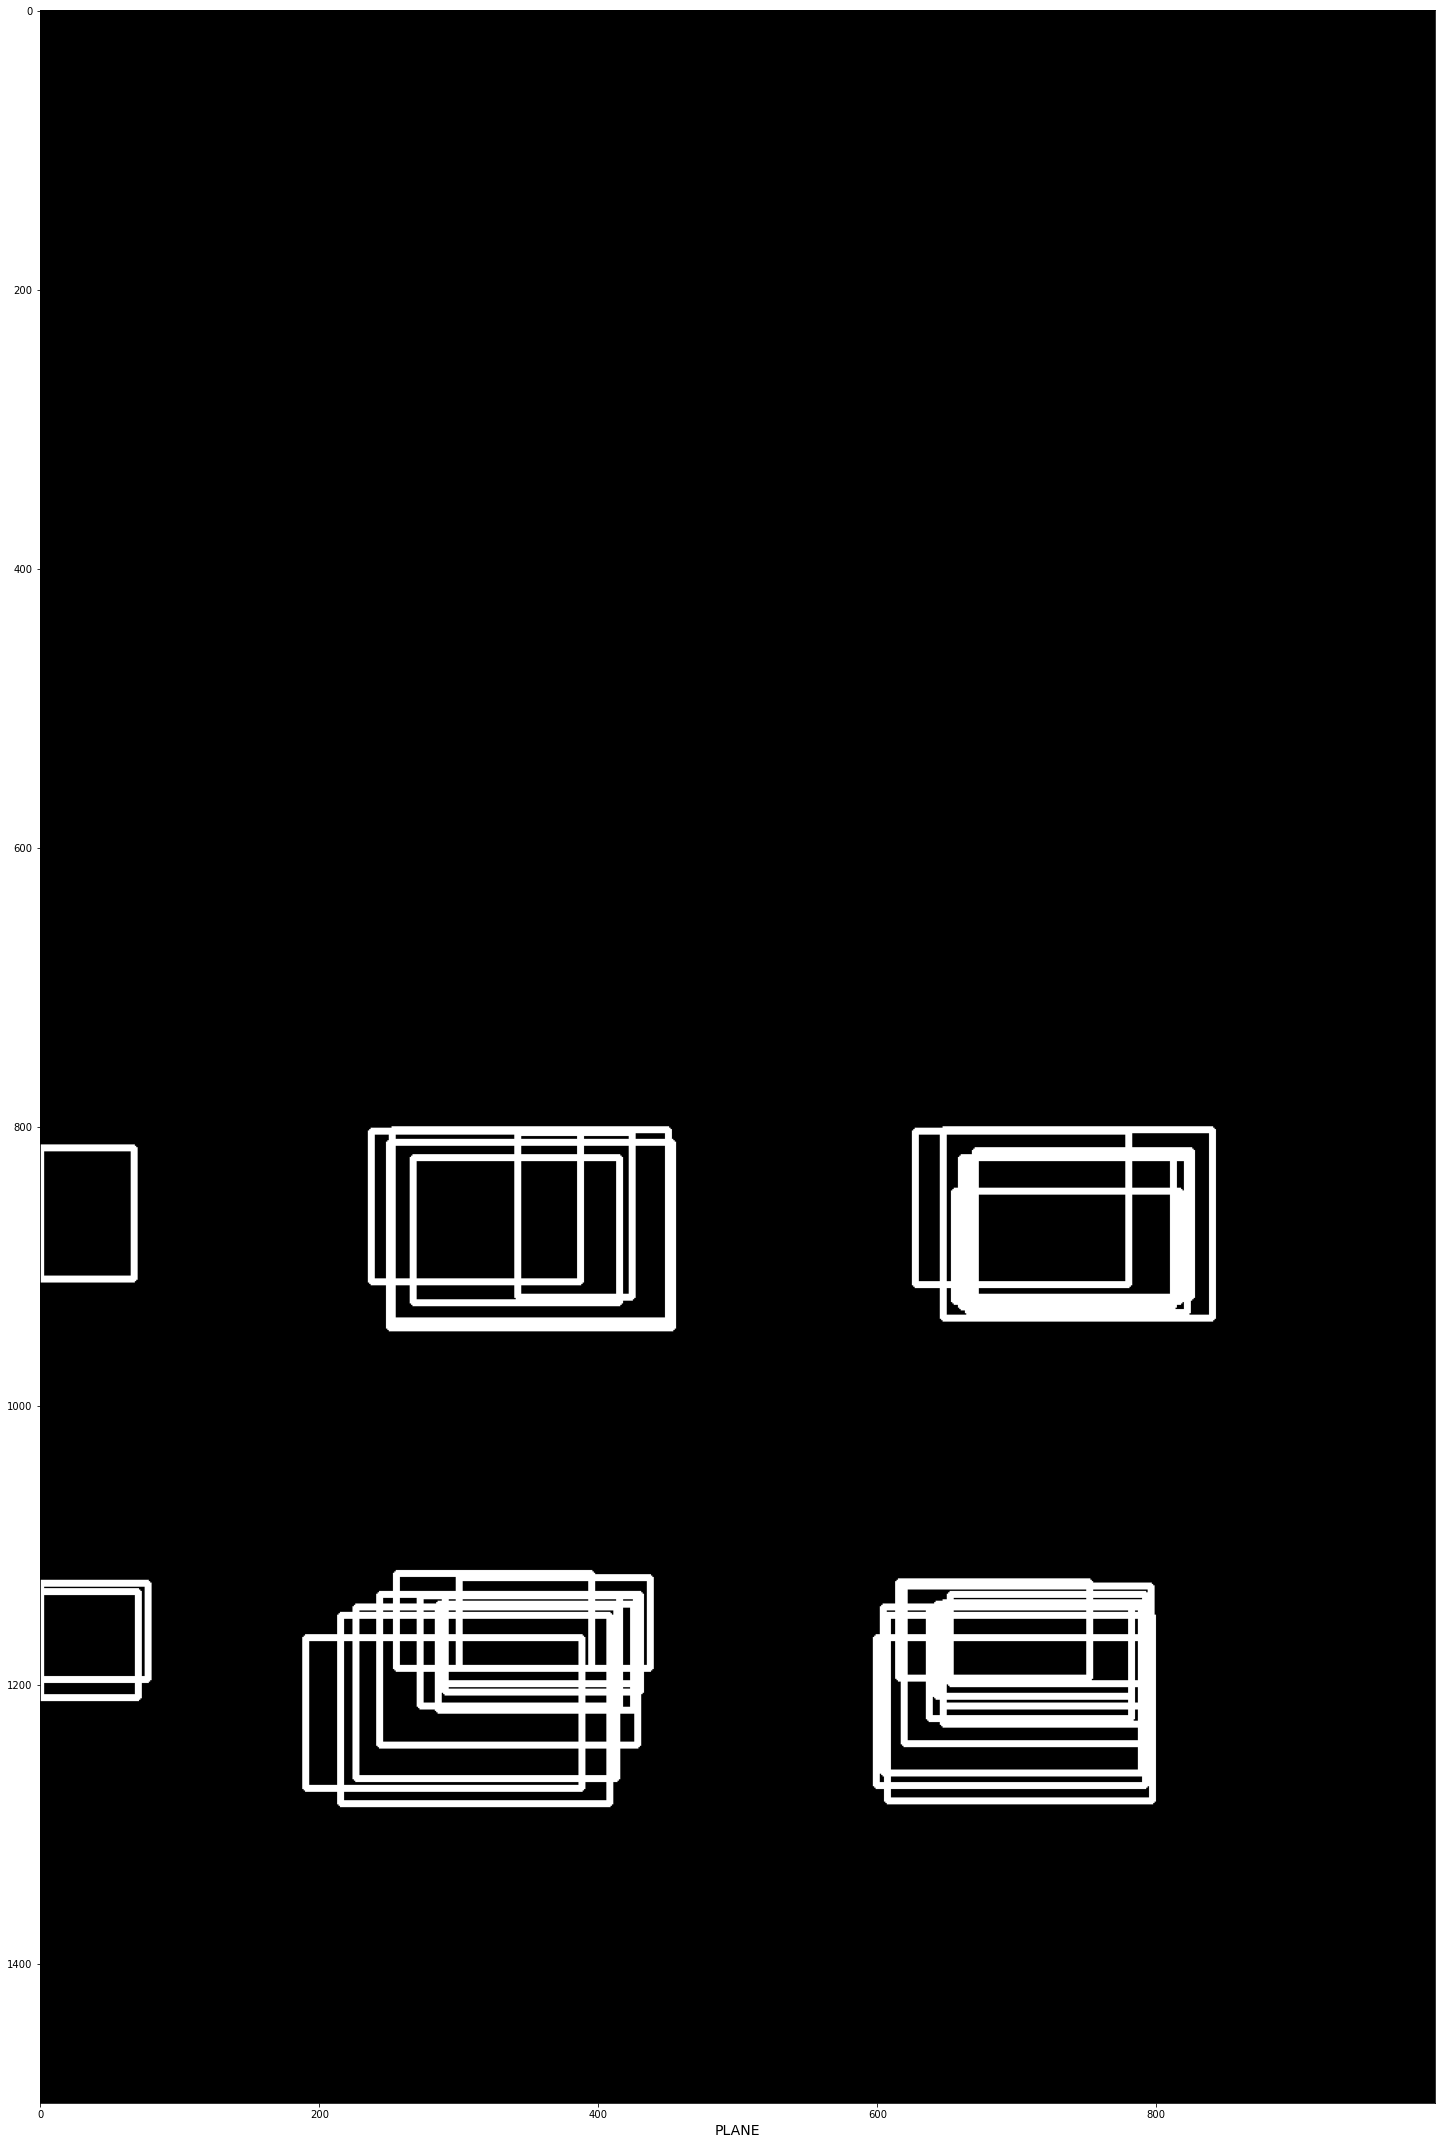

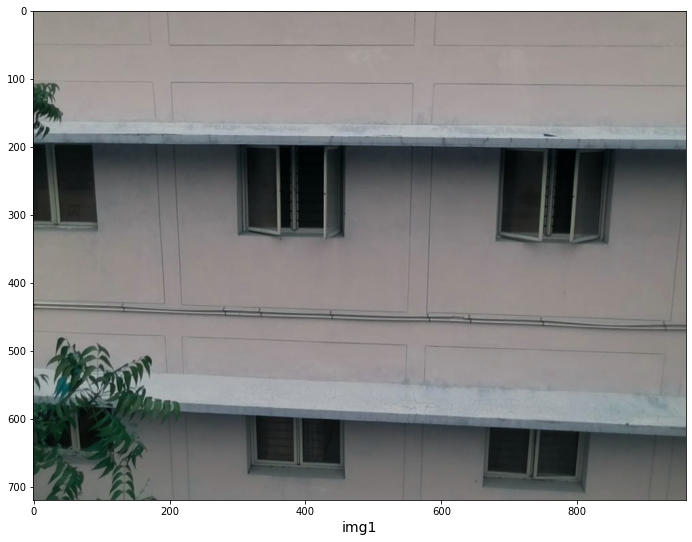

[670, 620, 807, 700]
mapped:670 1137 807 1198
[320, 602, 455, 682]
mapped:320 1124 455 1185
[692, 207, 845, 340]
mapped:692 823 845 924
[305, 202, 452, 335]
mapped:305 819 452 920
[0, 202, 90, 317]
mapped:0 819 90 907


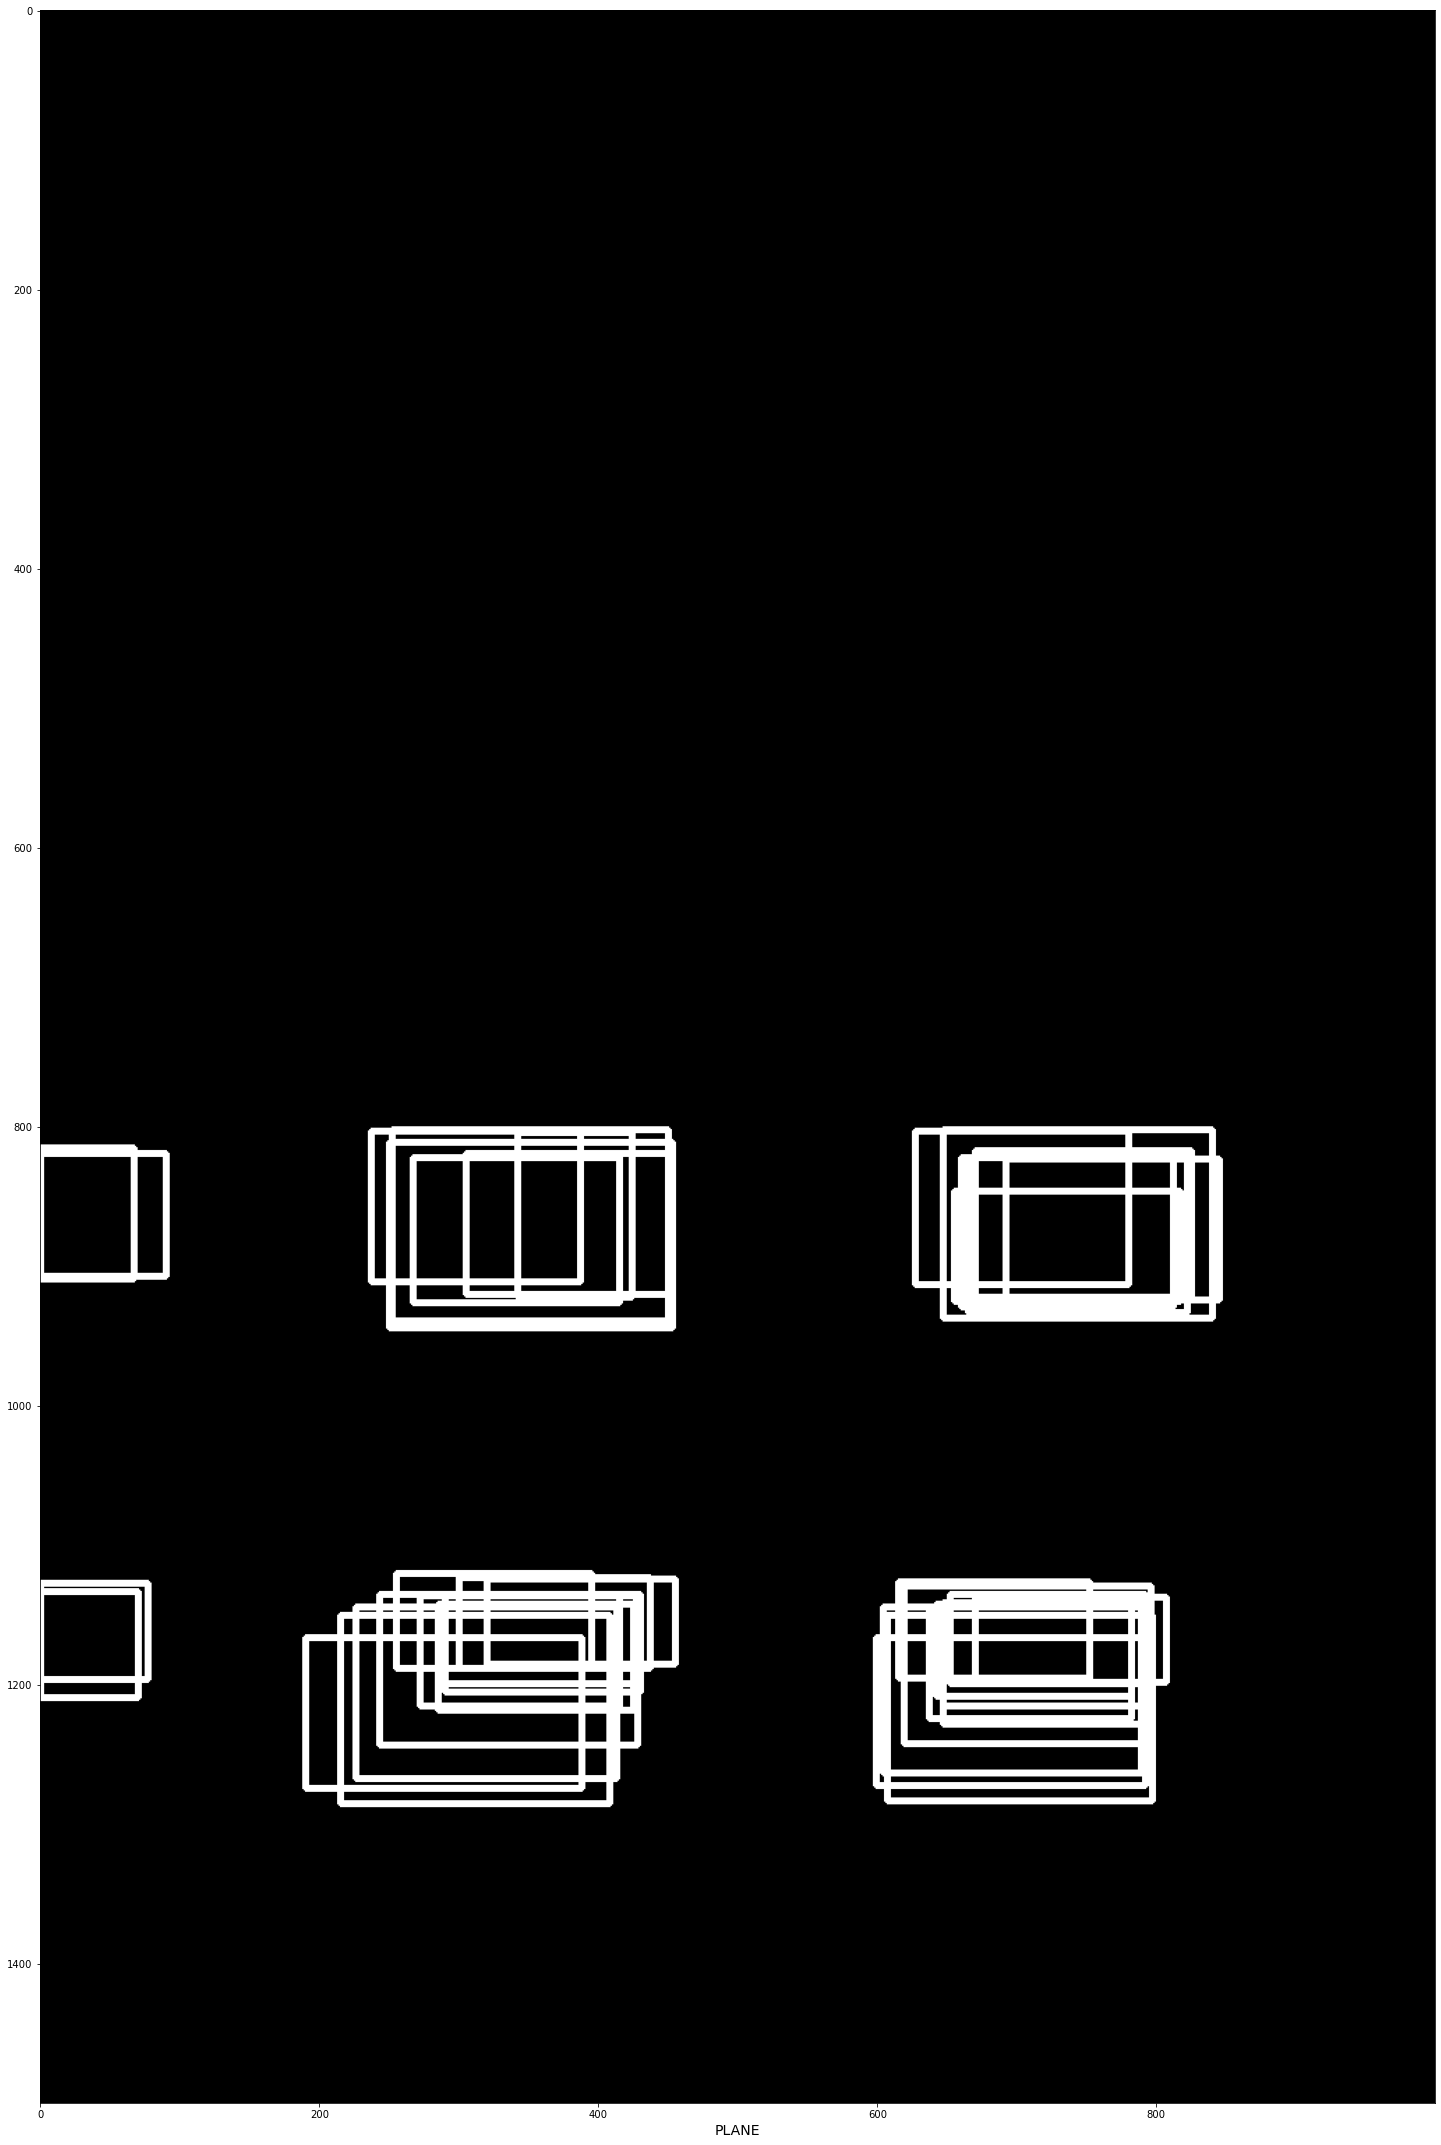

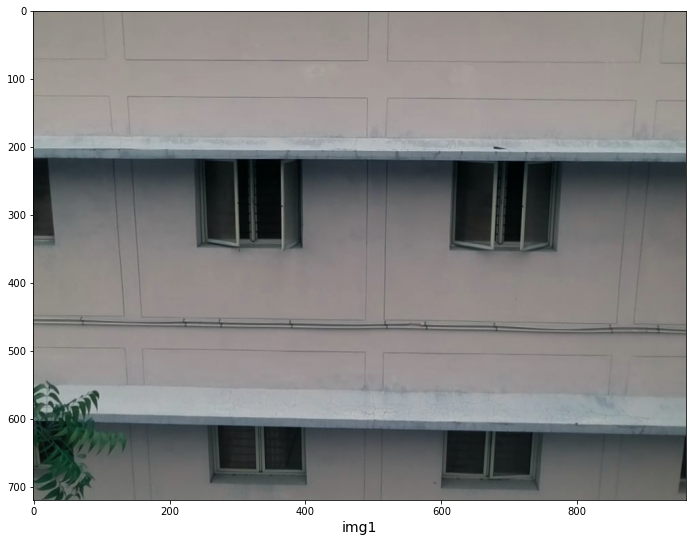

[605, 622, 737, 697]
mapped:605 1119 737 1176
[262, 615, 397, 690]
mapped:262 1114 397 1171
[223, 207, 413, 367]
mapped:223 803 413 925
[604, 207, 787, 365]
mapped:604 803 787 923


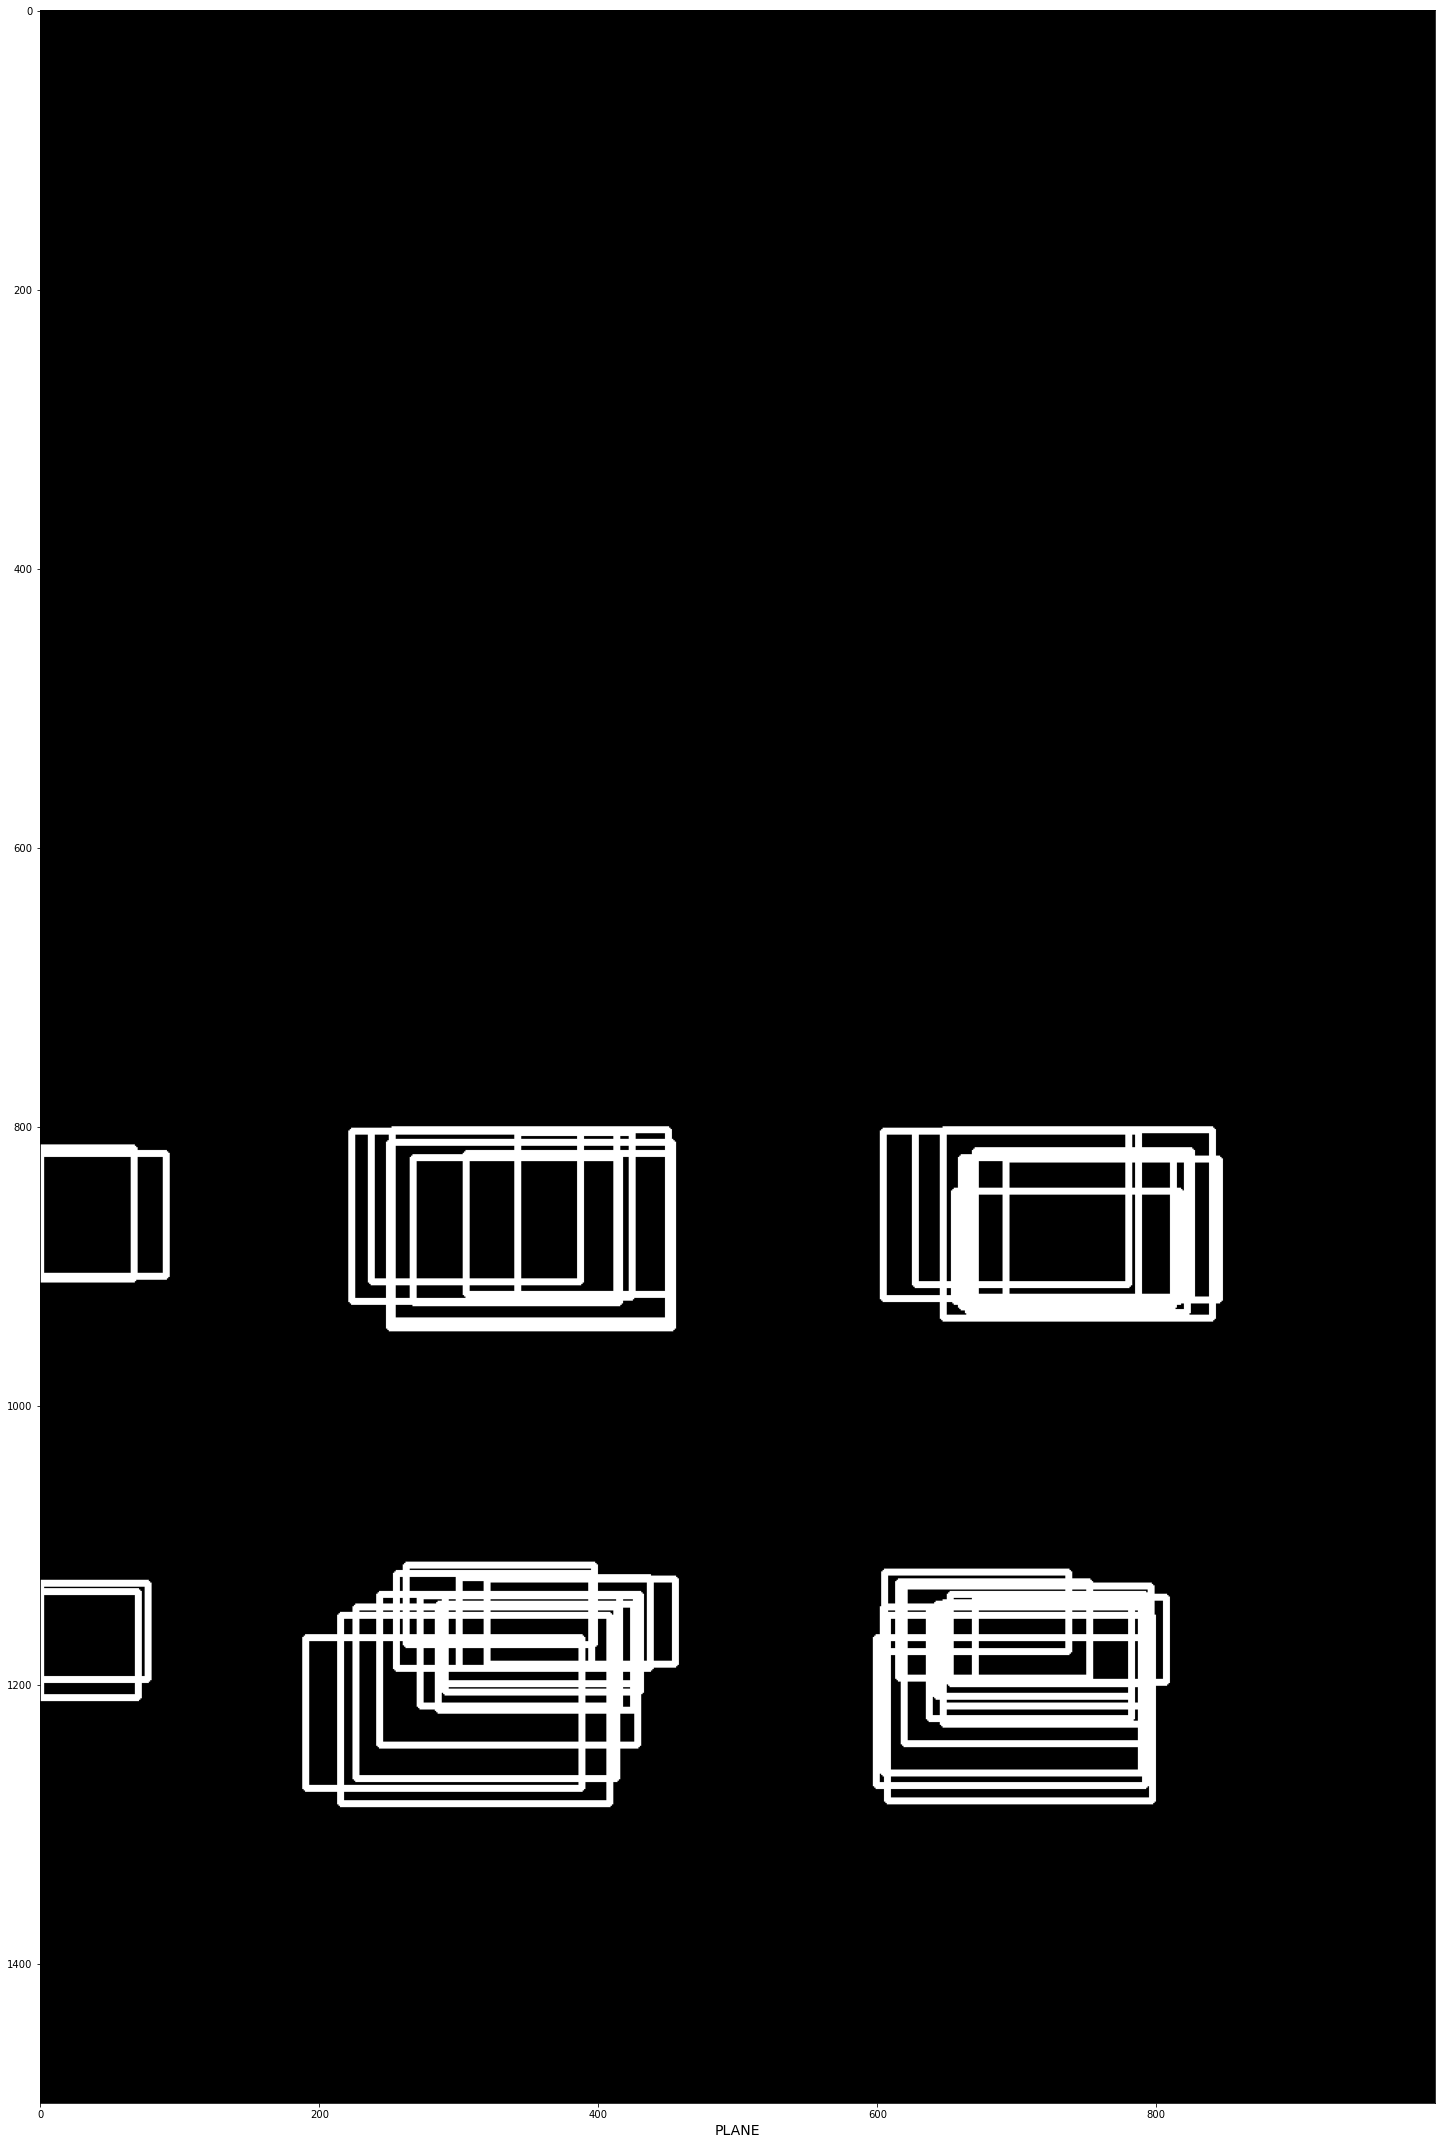

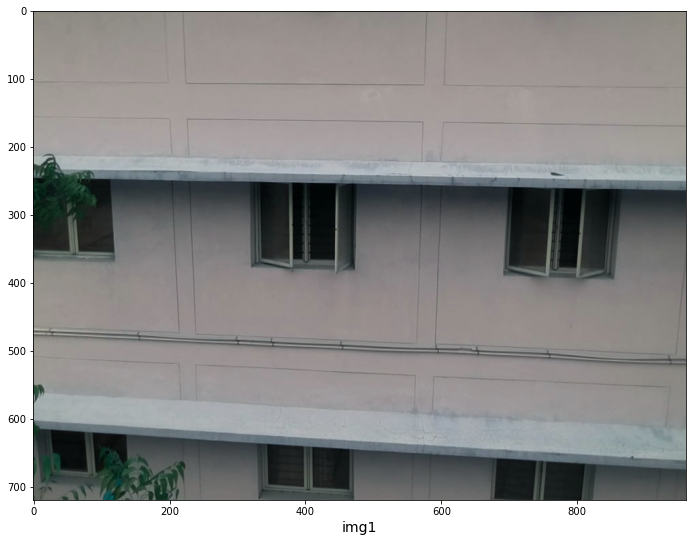

[337, 642, 465, 717]
mapped:337 1124 465 1181
[702, 265, 855, 392]
mapped:702 837 855 934
[325, 257, 467, 382]
mapped:325 831 467 926


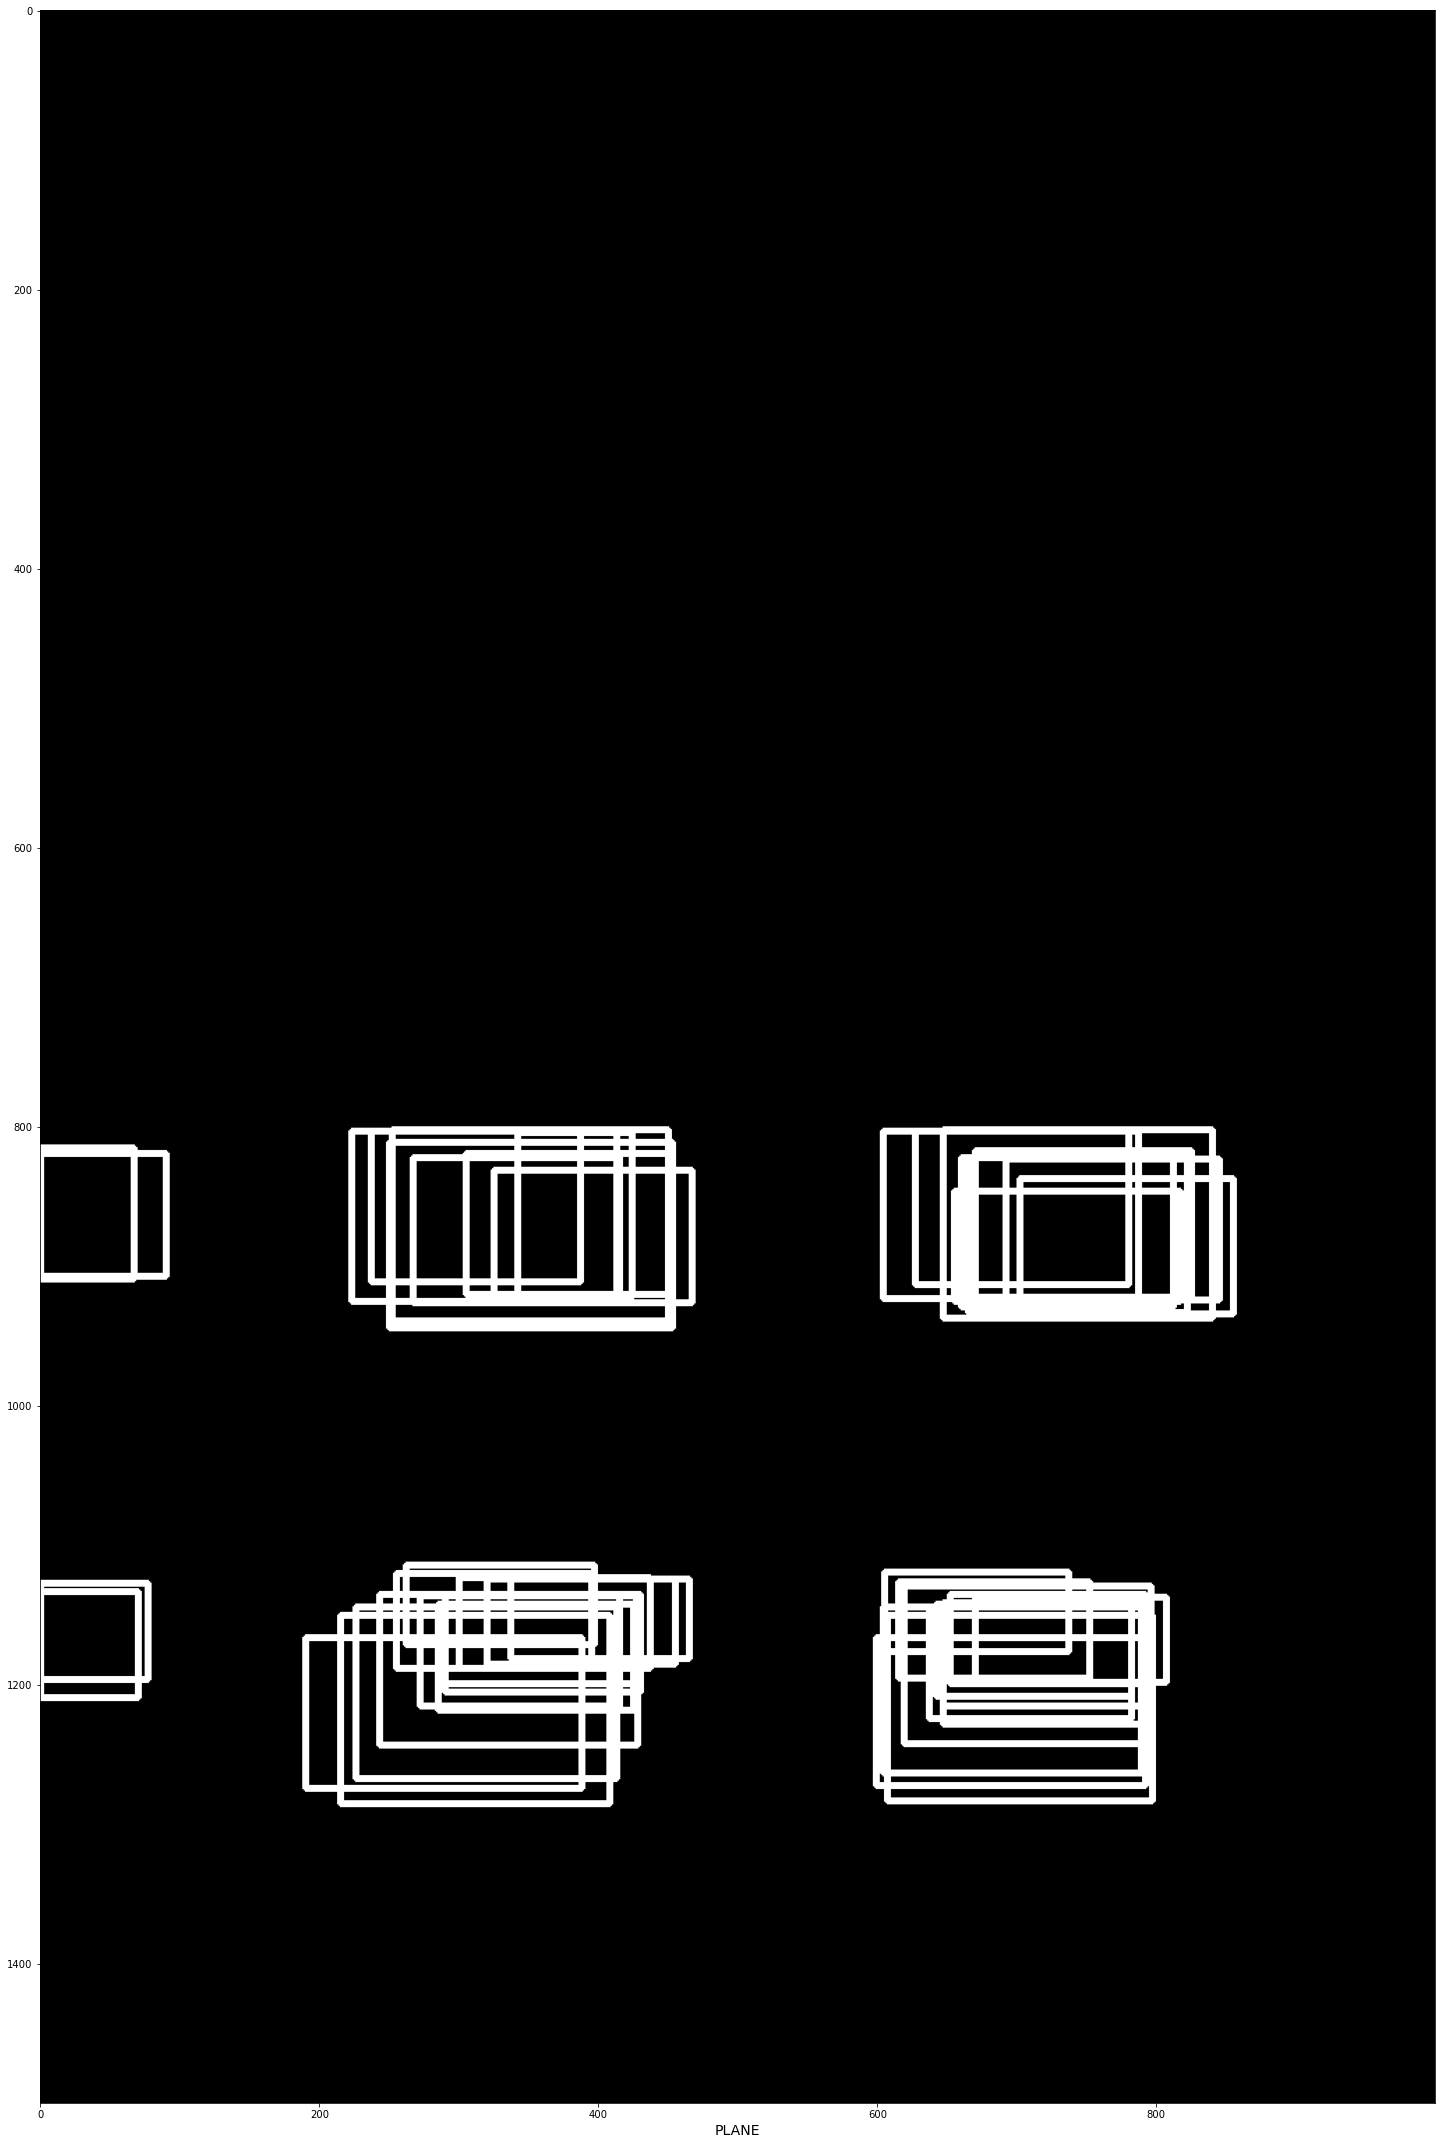

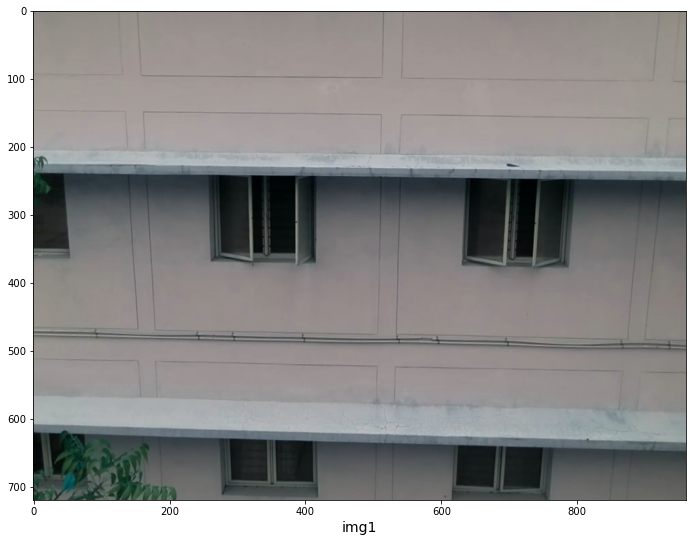

[625, 642, 757, 717]
mapped:625 1114 757 1171
[280, 637, 412, 705]
mapped:280 1110 412 1162
[637, 250, 785, 377]
mapped:637 816 785 912
[262, 242, 407, 370]
mapped:262 810 407 907


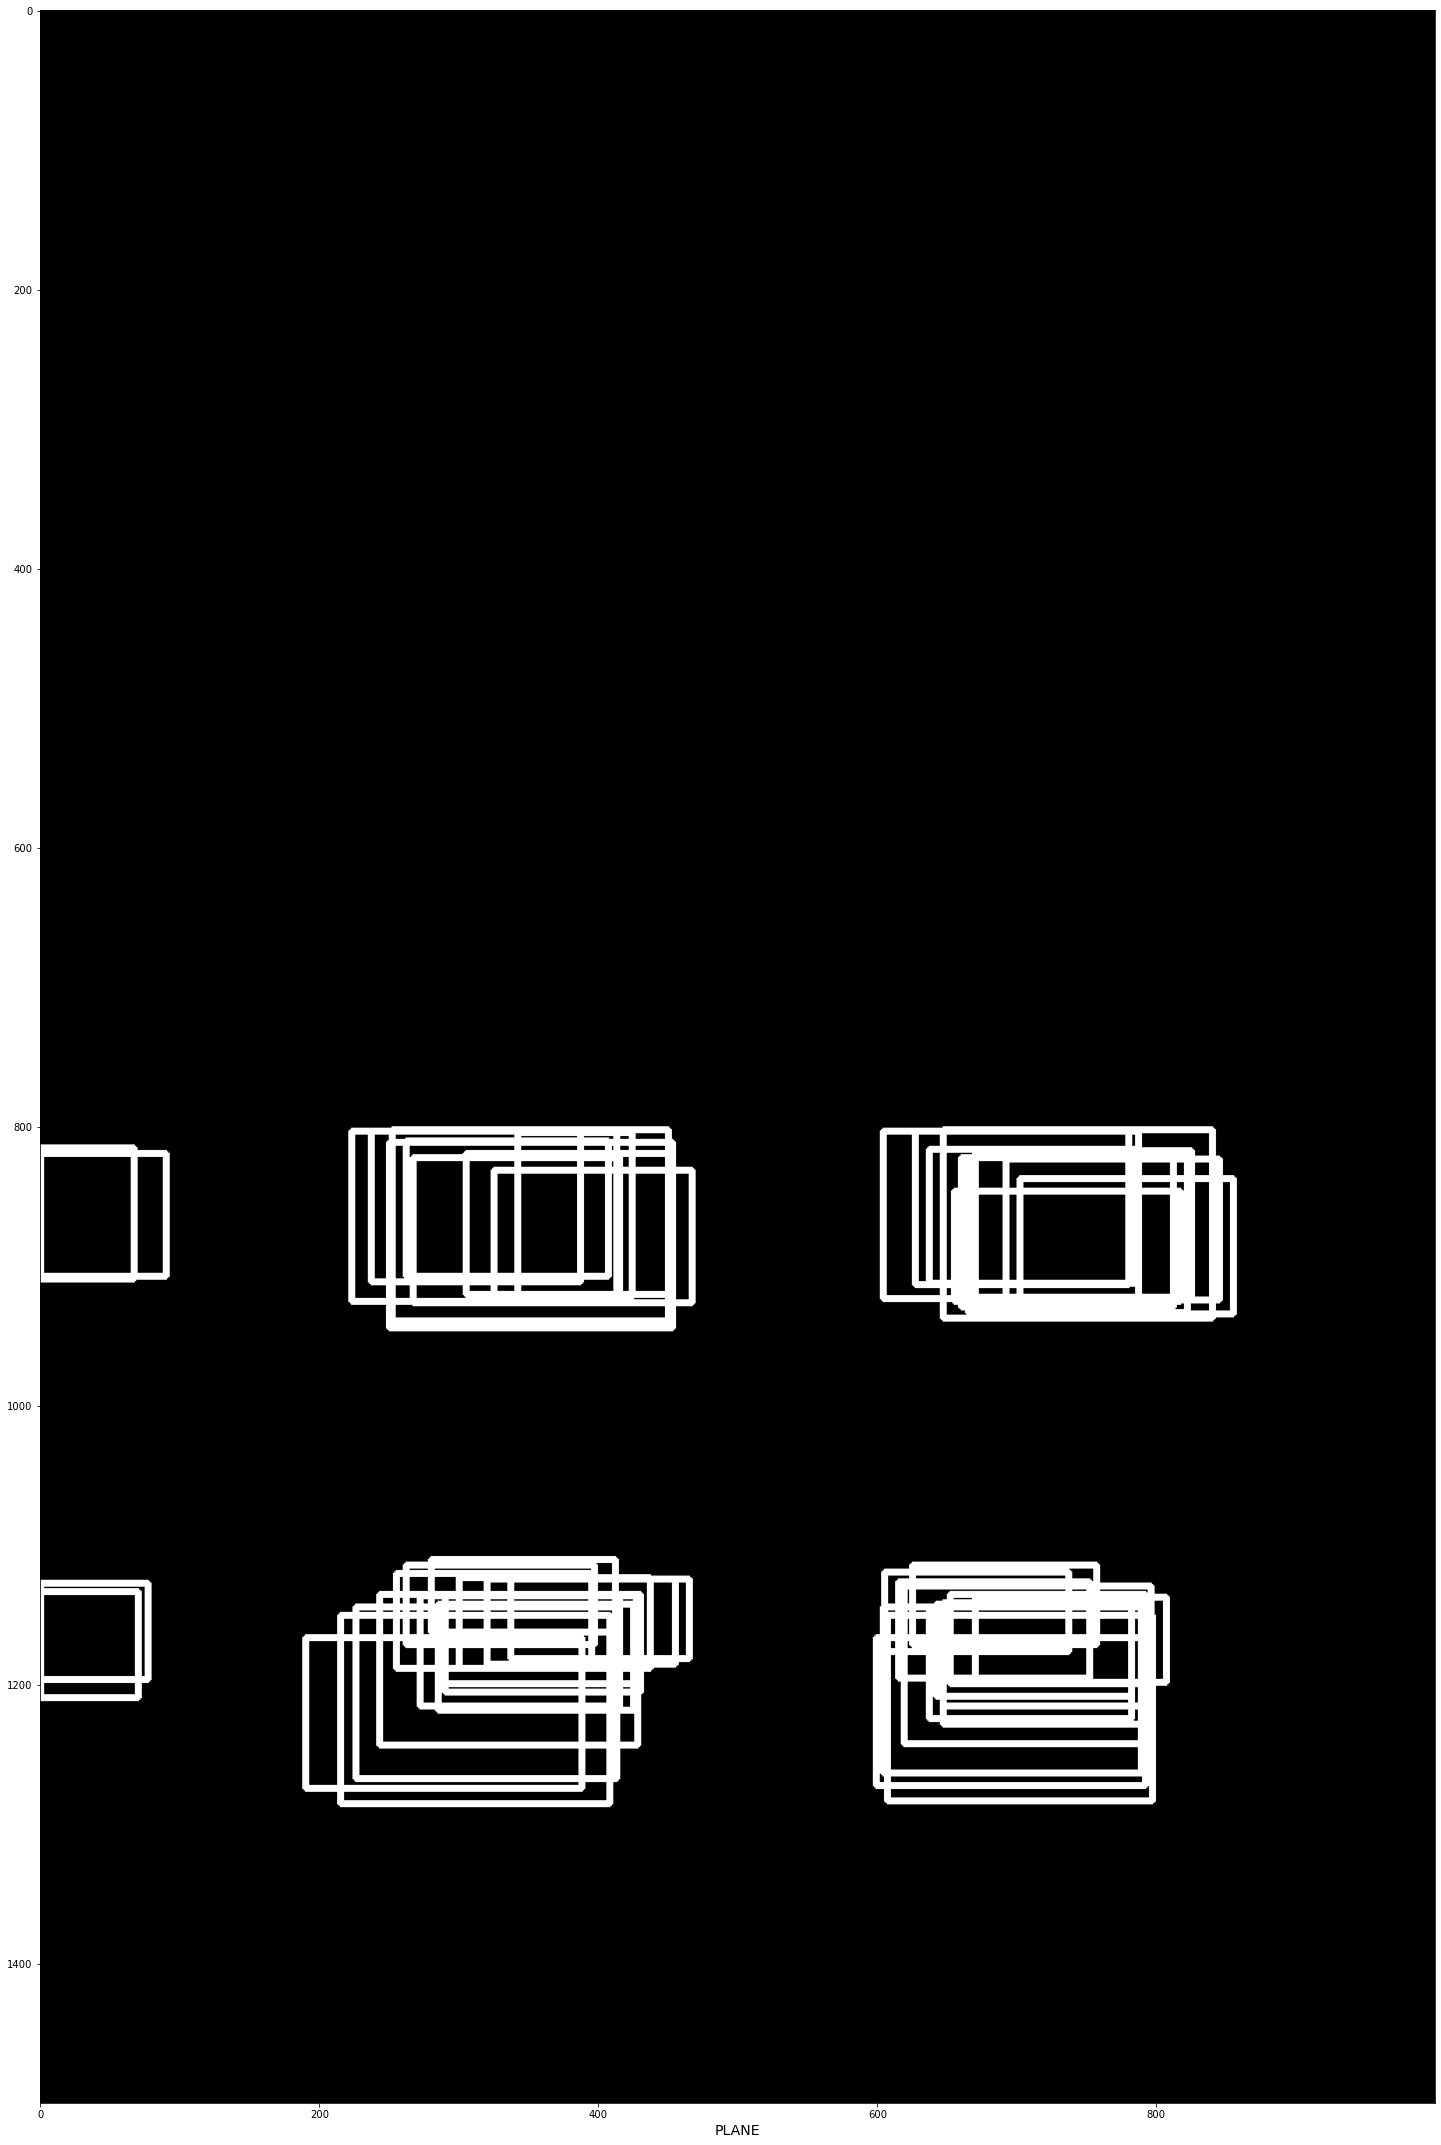

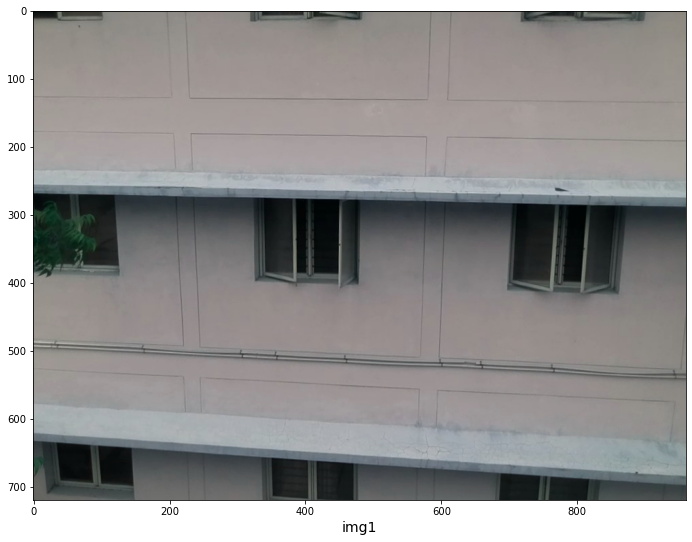

[30, 642, 145, 715]
mapped:30 1104 145 1160
[705, 290, 862, 417]
mapped:705 836 862 933
[330, 282, 475, 400]
mapped:330 830 475 920


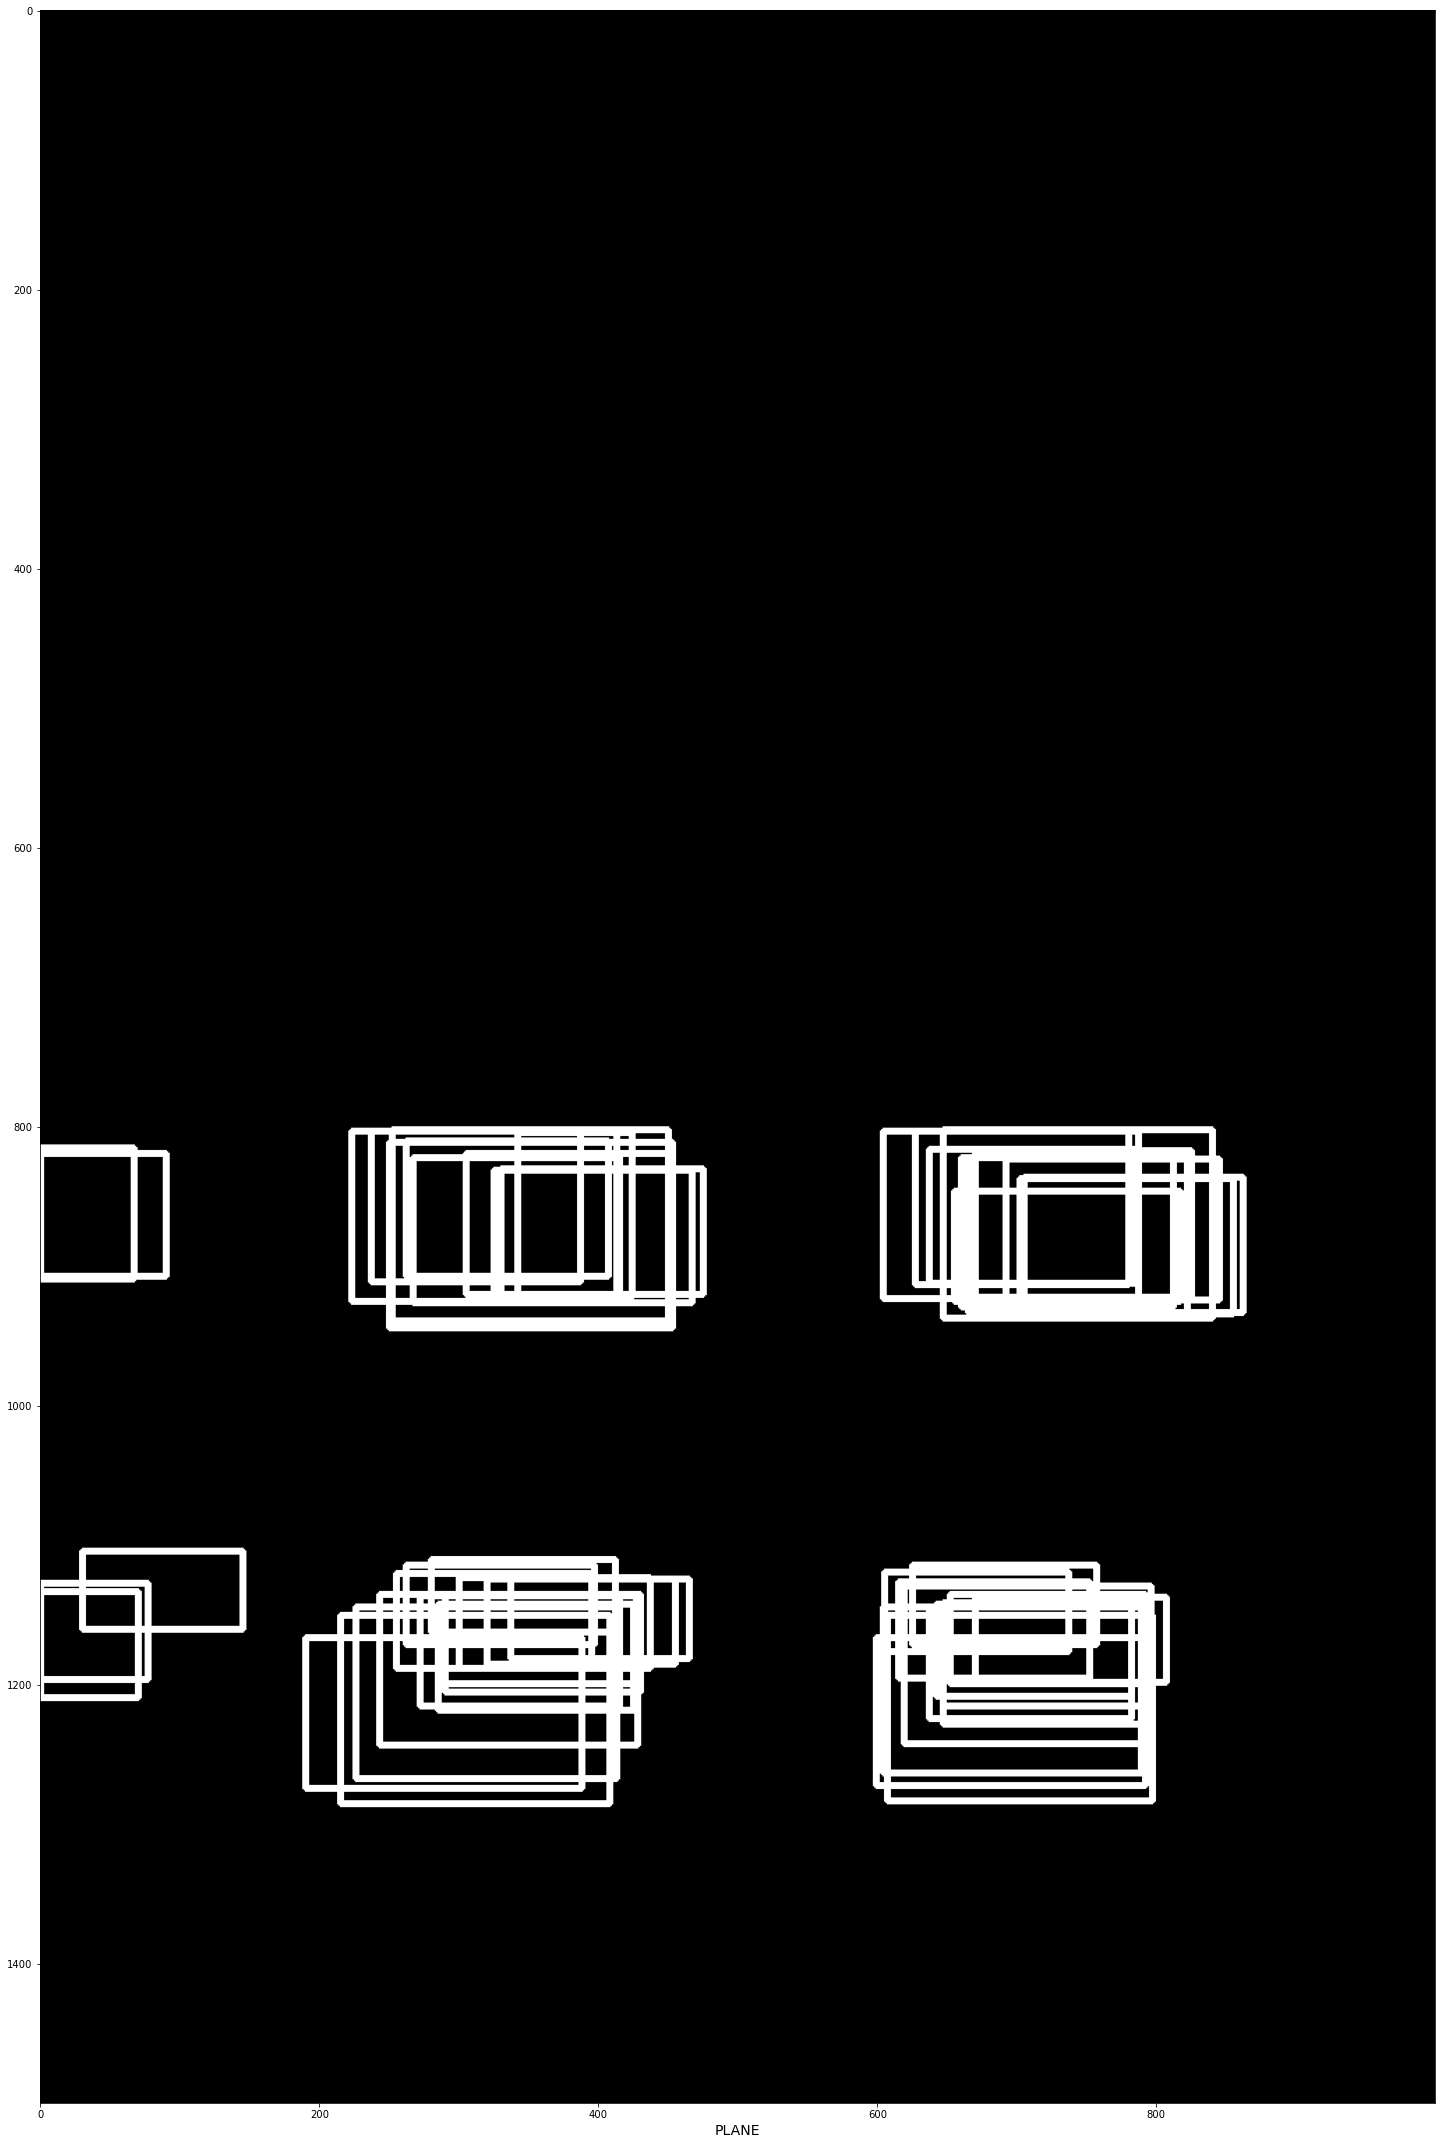

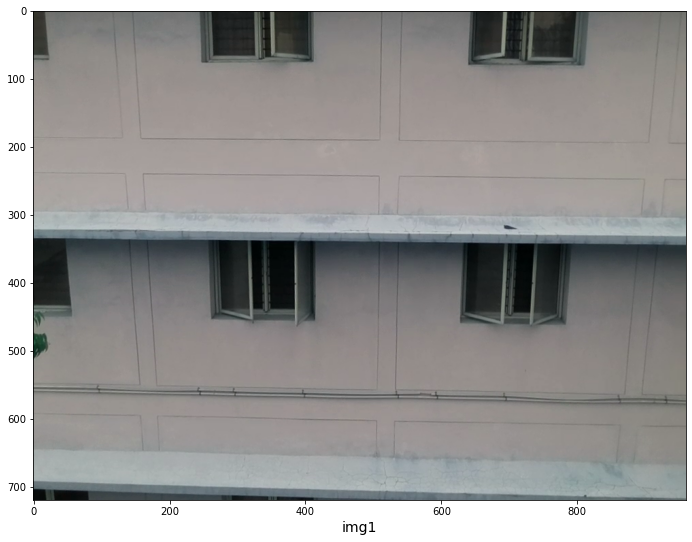

[265, 342, 407, 460]
mapped:265 816 407 906
[635, 347, 782, 460]
mapped:635 820 782 906


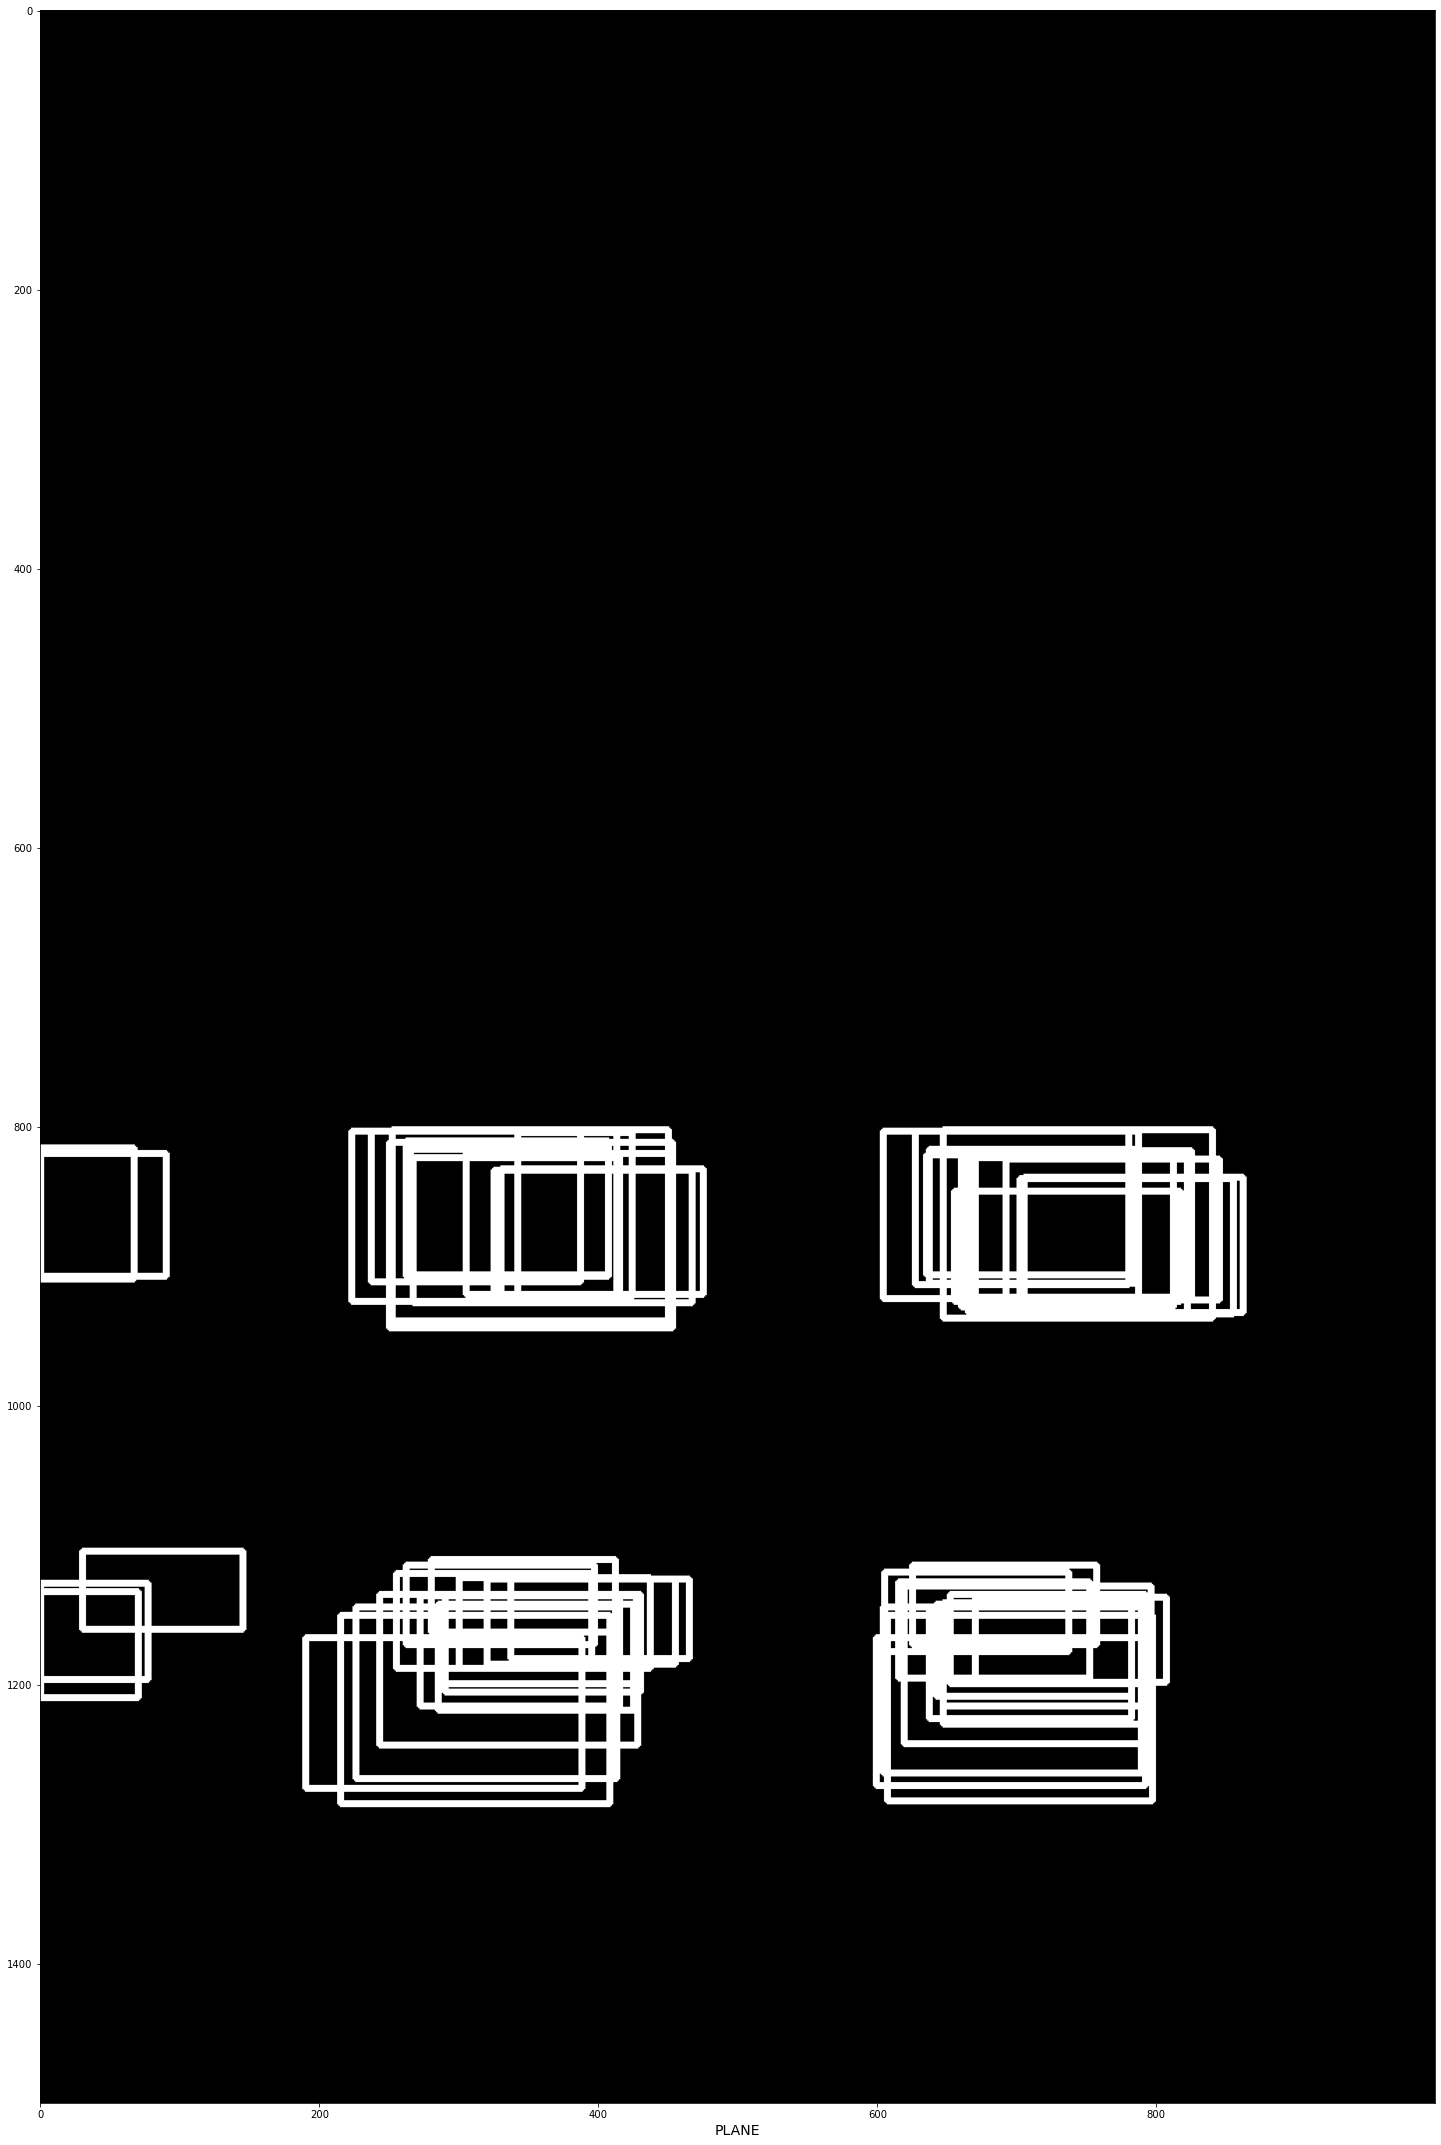

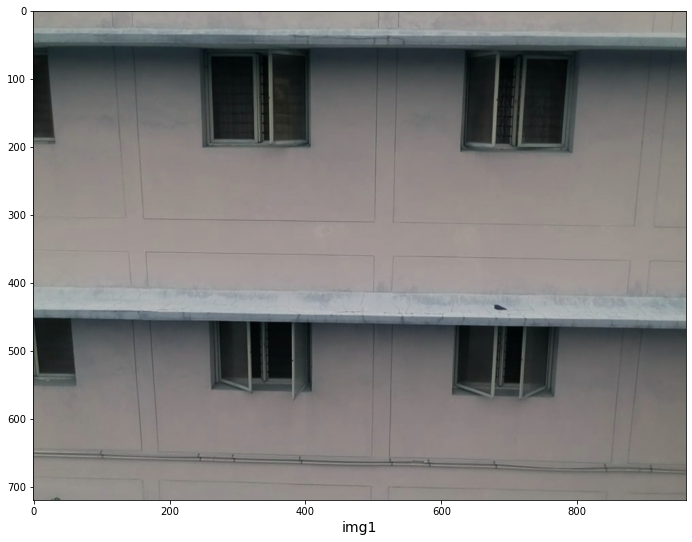

[622, 470, 767, 570]
mapped:622 833 767 909
[265, 462, 402, 562]
mapped:265 827 402 903
[637, 57, 785, 205]
mapped:637 519 785 632


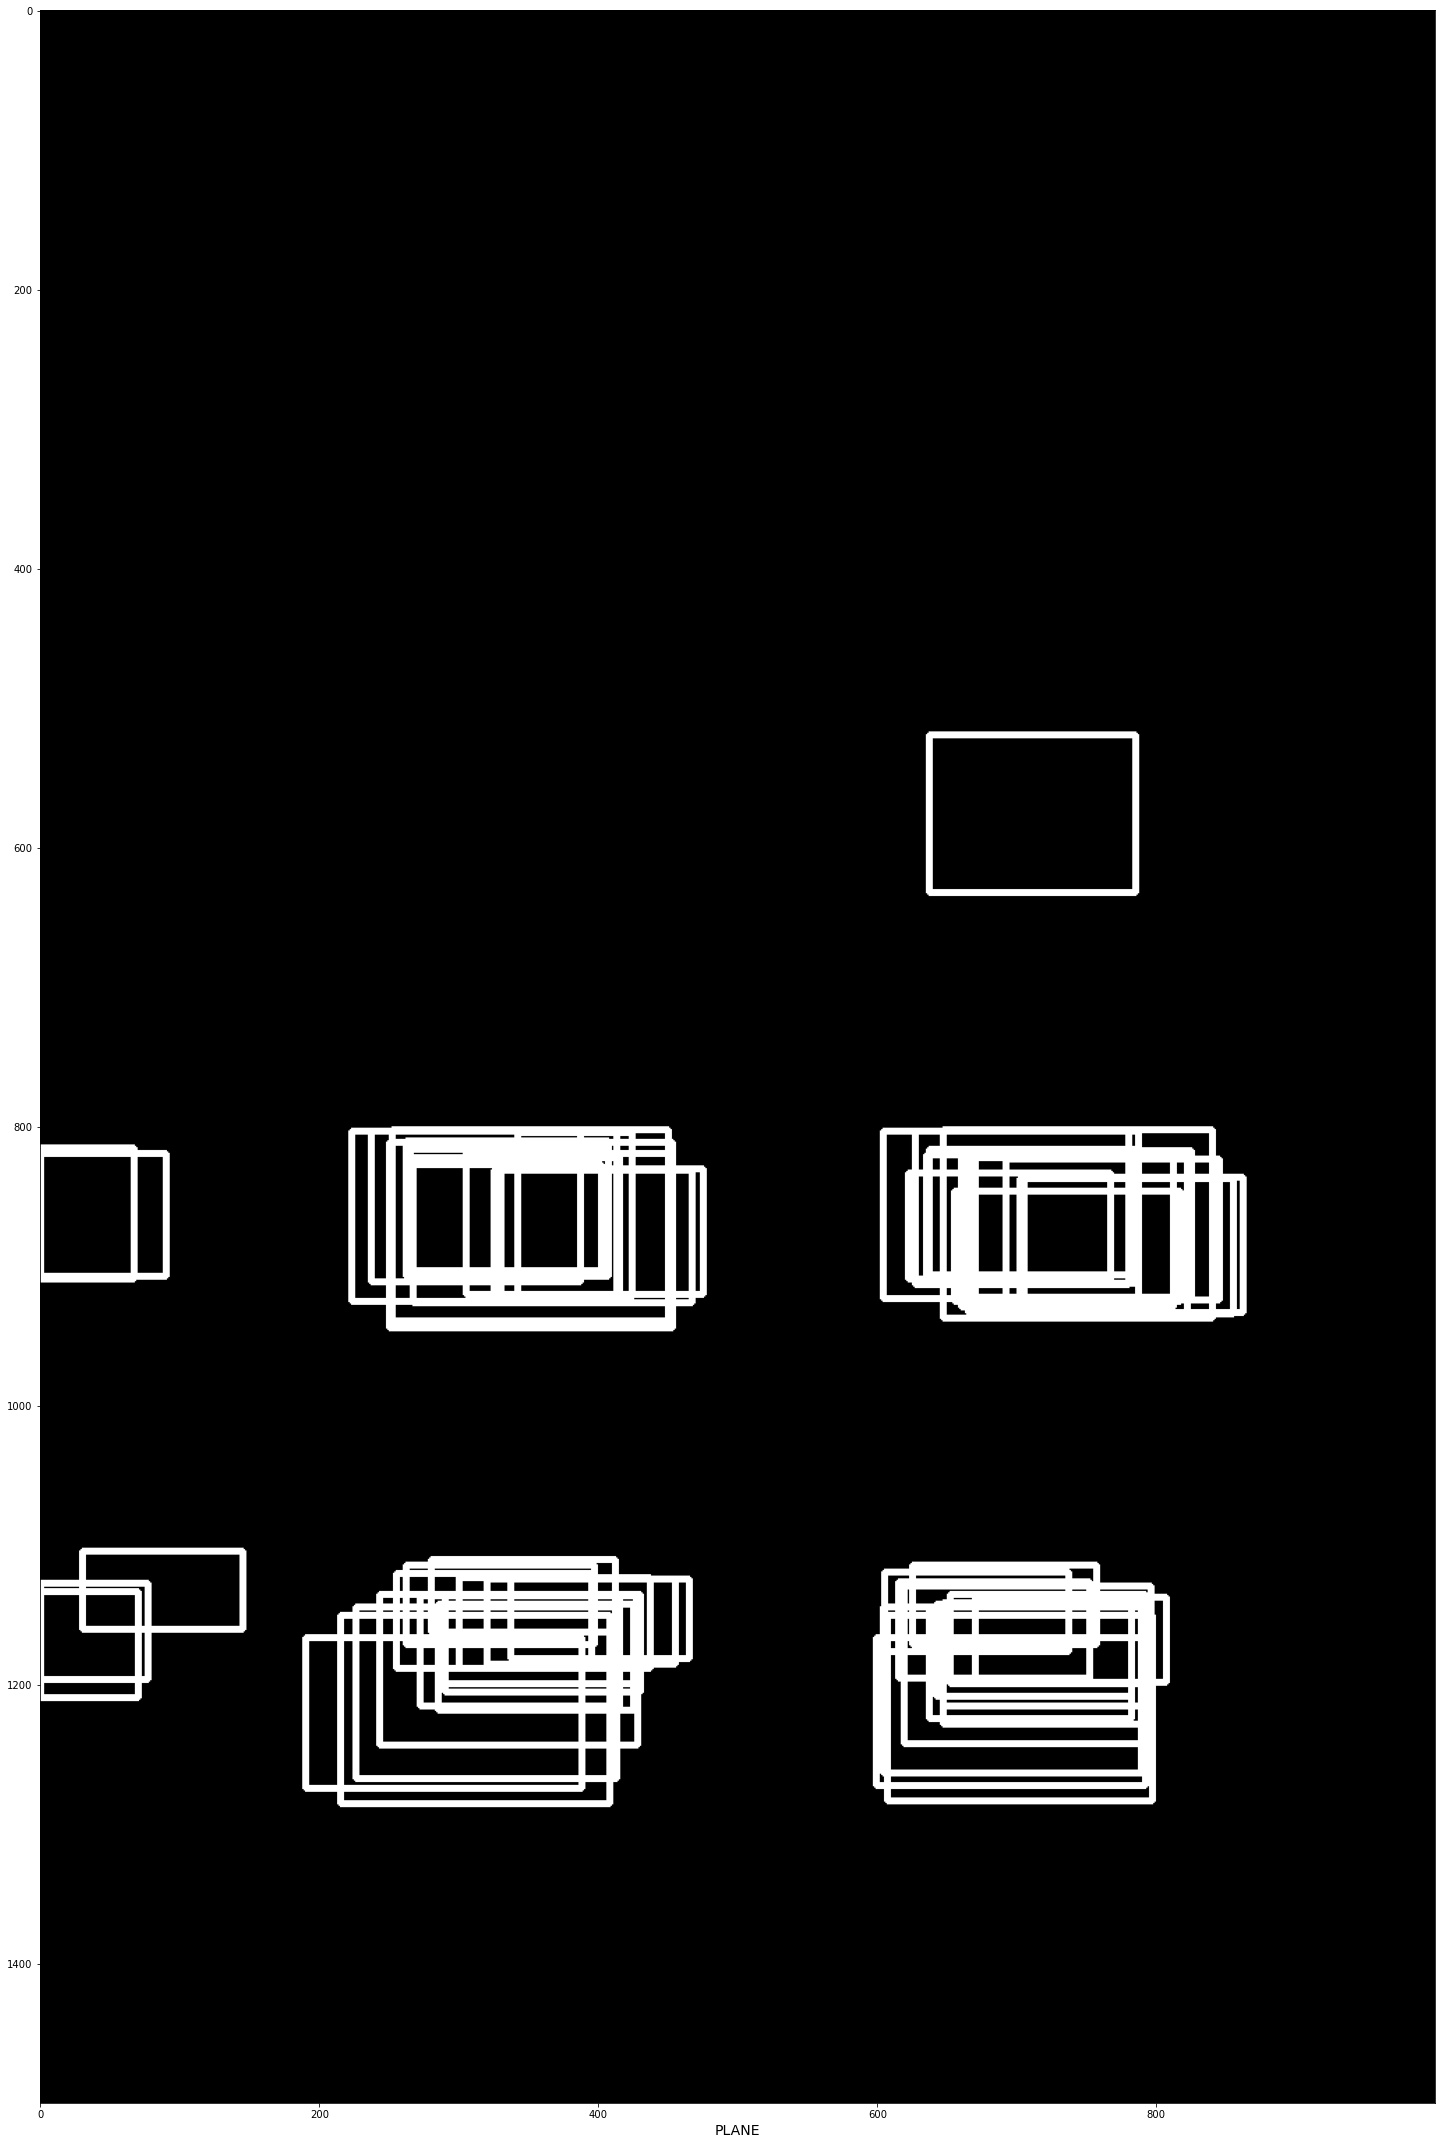

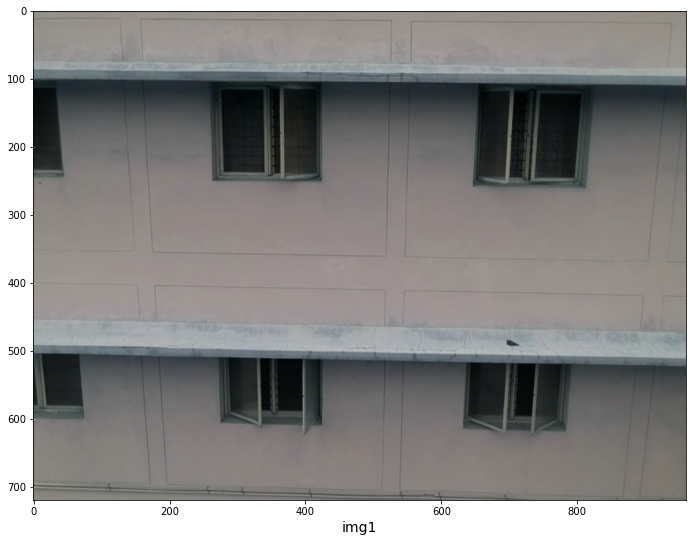

[637, 525, 782, 622]
mapped:637 845 782 919
[277, 515, 417, 612]
mapped:277 837 417 911


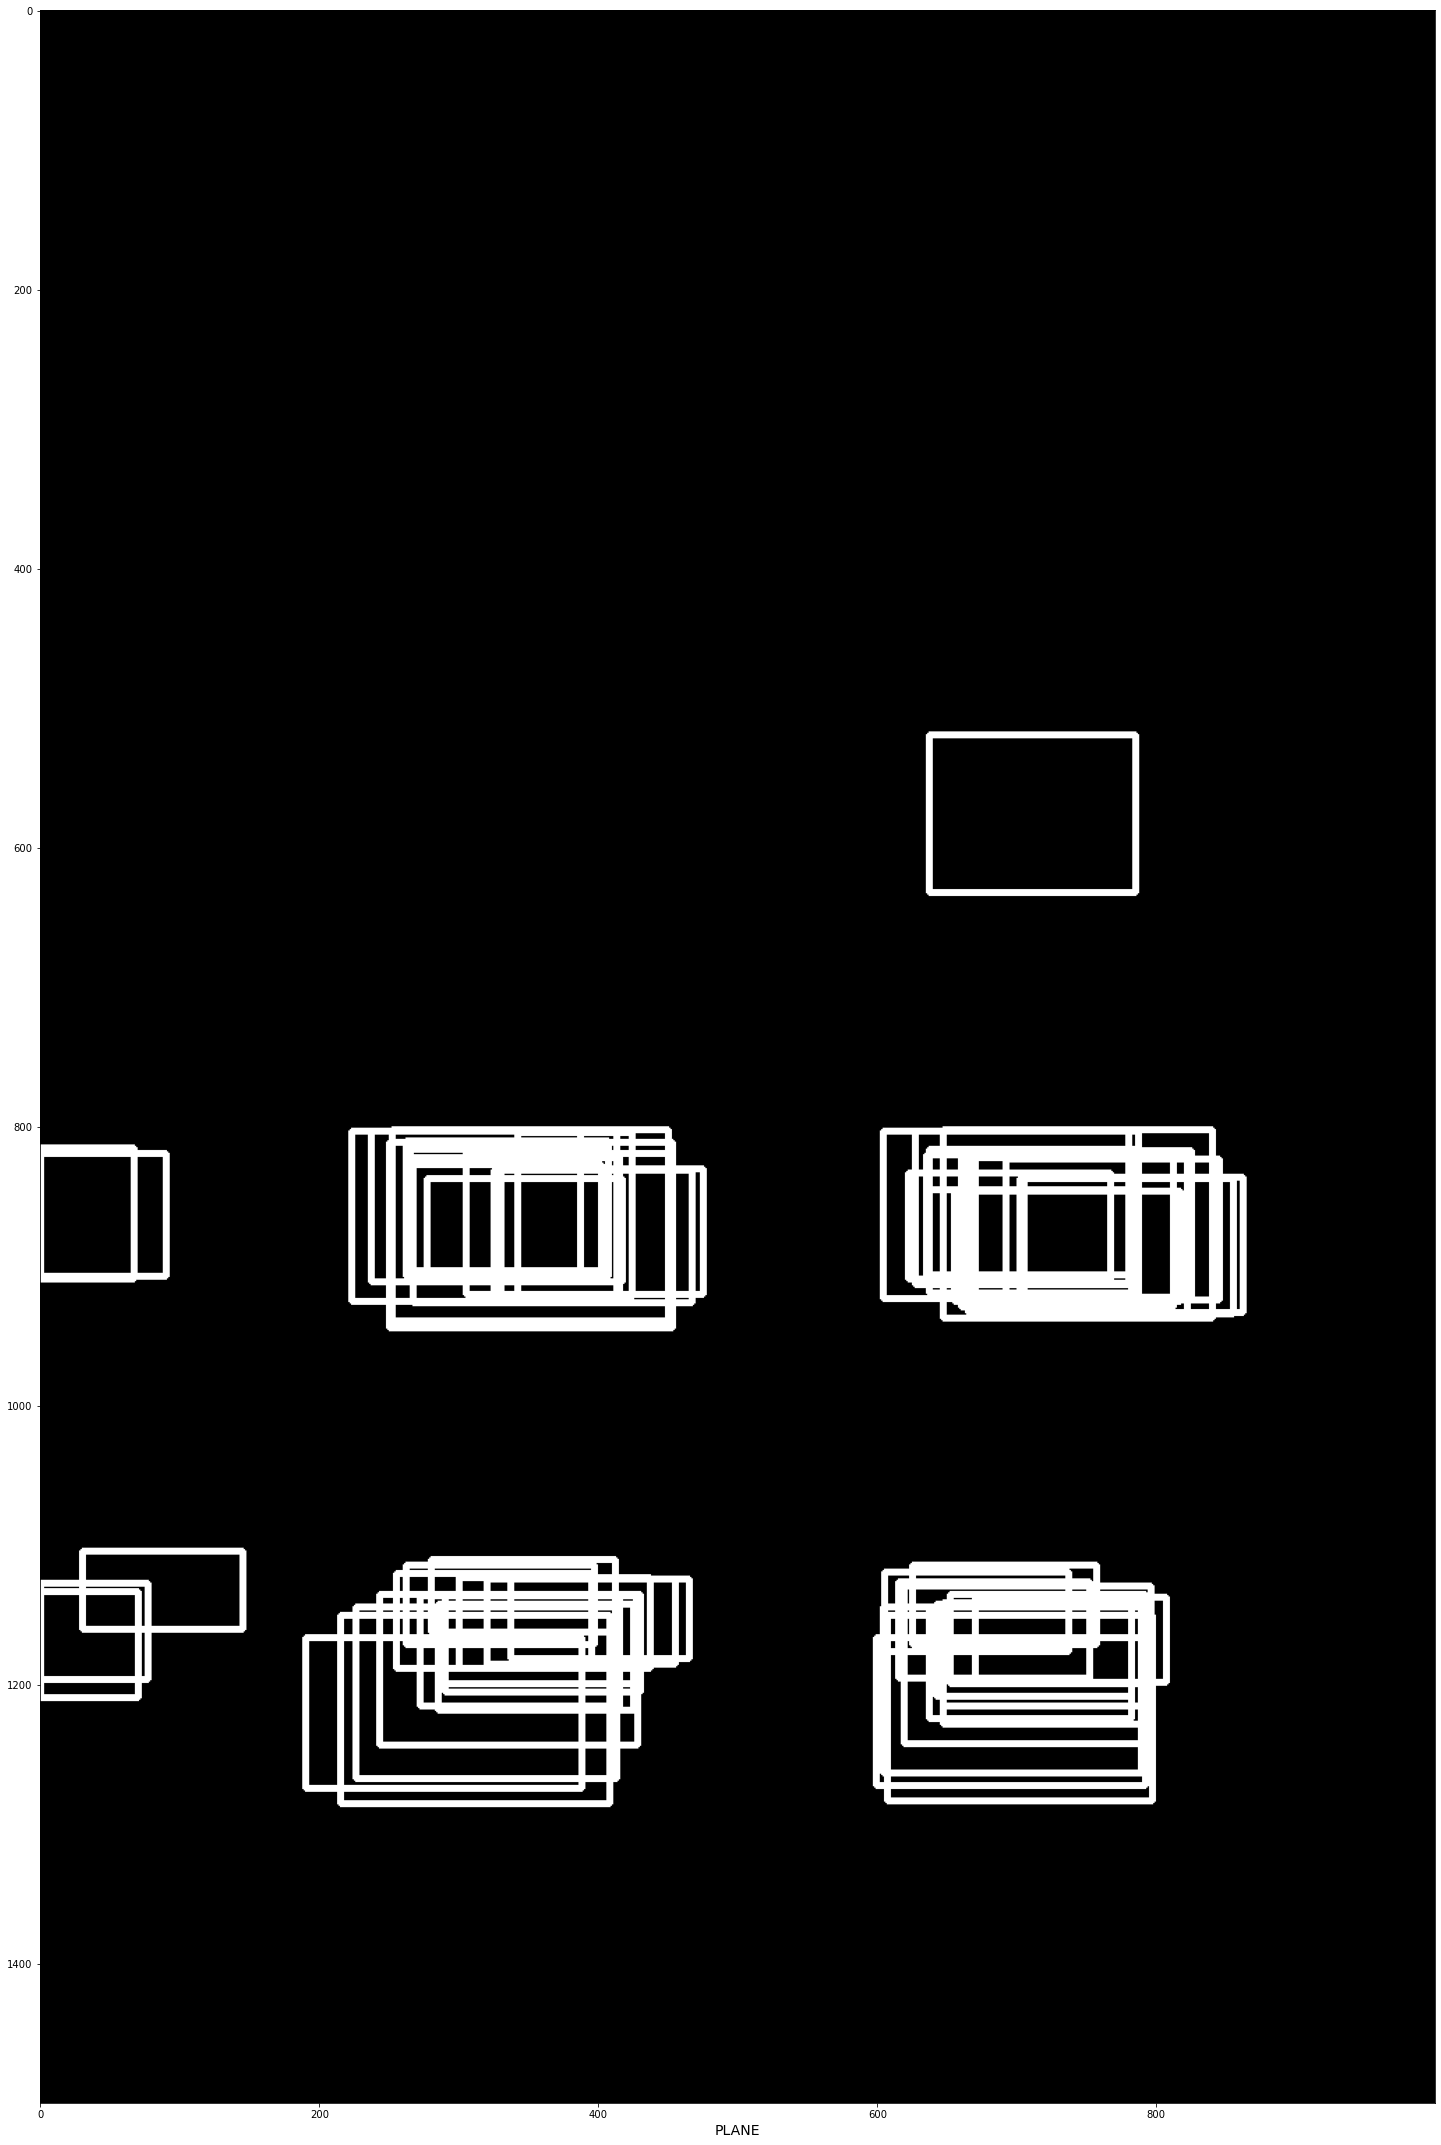

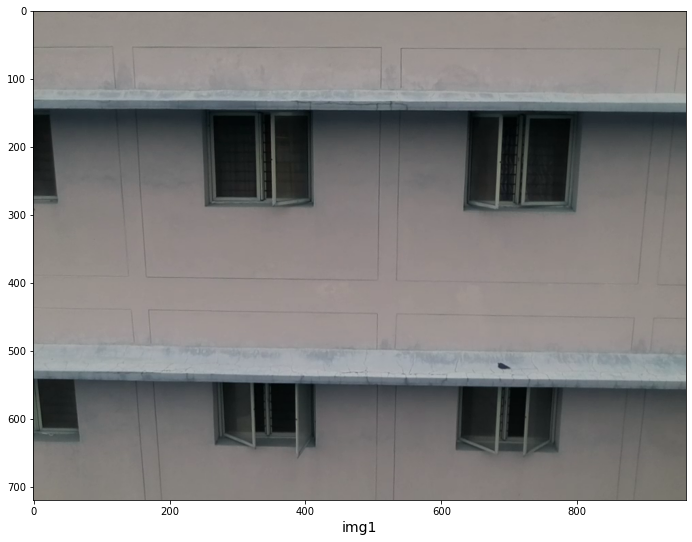

[625, 557, 772, 652]
mapped:625 849 772 922
[267, 552, 410, 647]
mapped:267 846 410 918


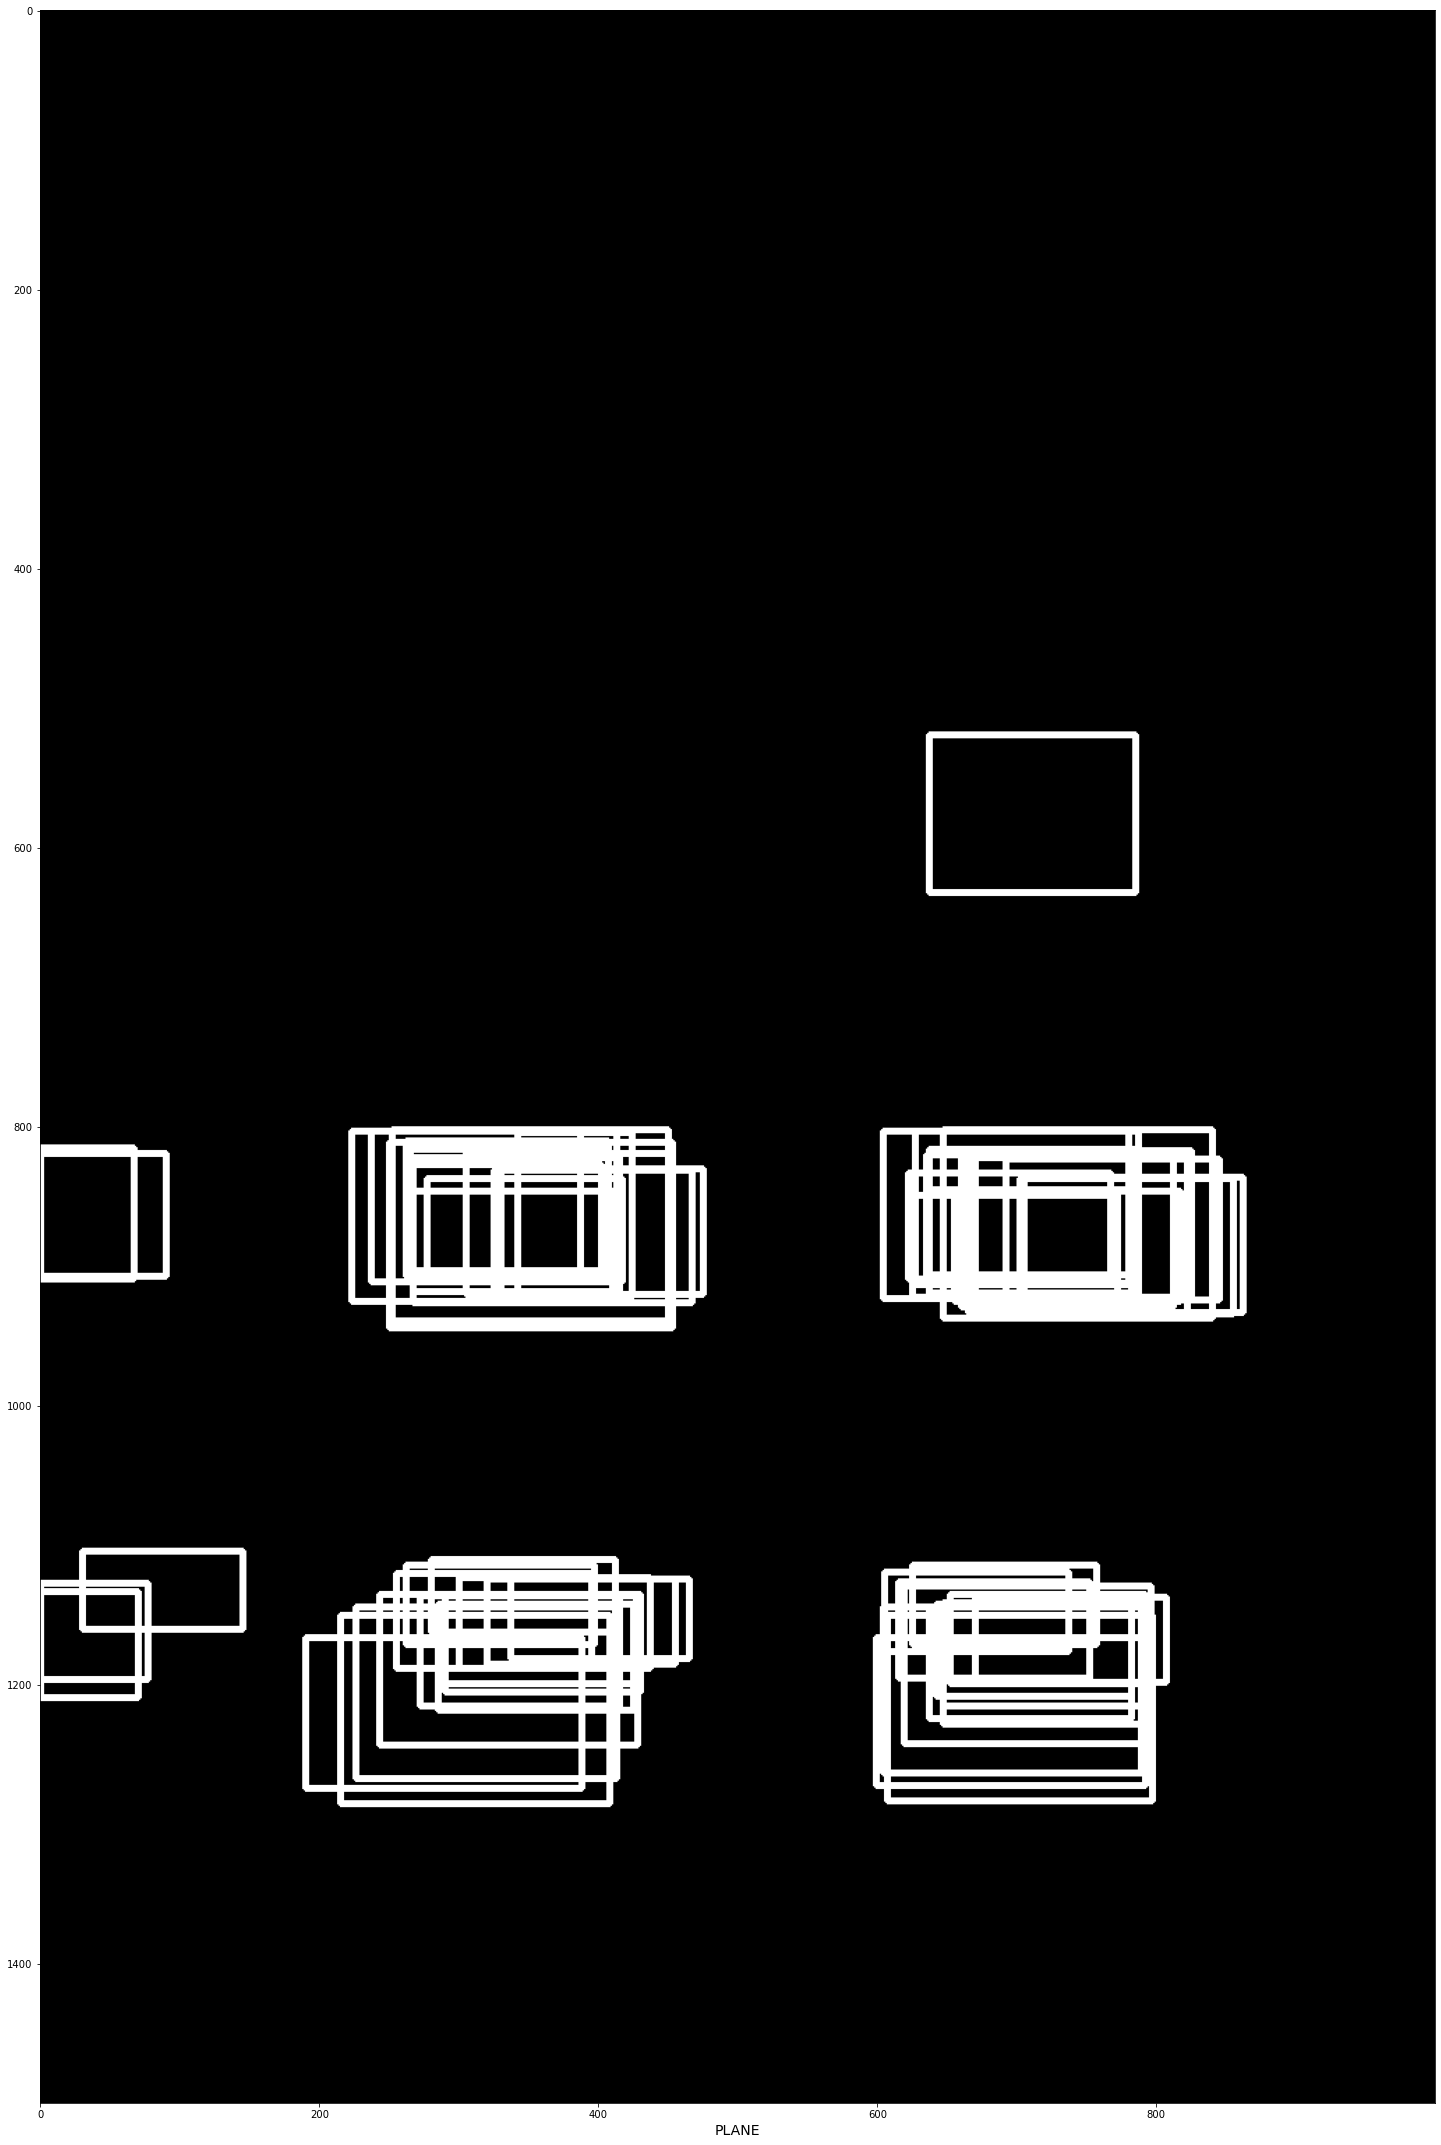

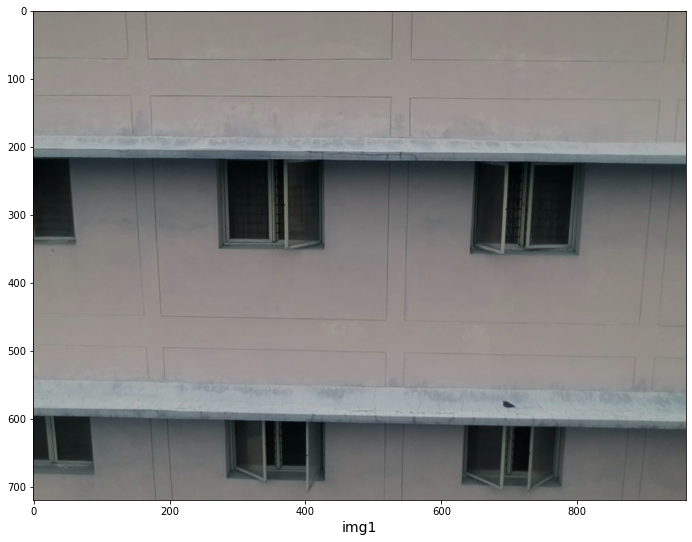

[632, 615, 770, 702]
mapped:632 844 770 910
[290, 605, 417, 690]
mapped:290 836 417 901
[0, 597, 80, 677]
mapped:0 830 80 891
[650, 225, 797, 355]
mapped:650 547 797 646
[272, 220, 422, 350]
mapped:272 543 422 642


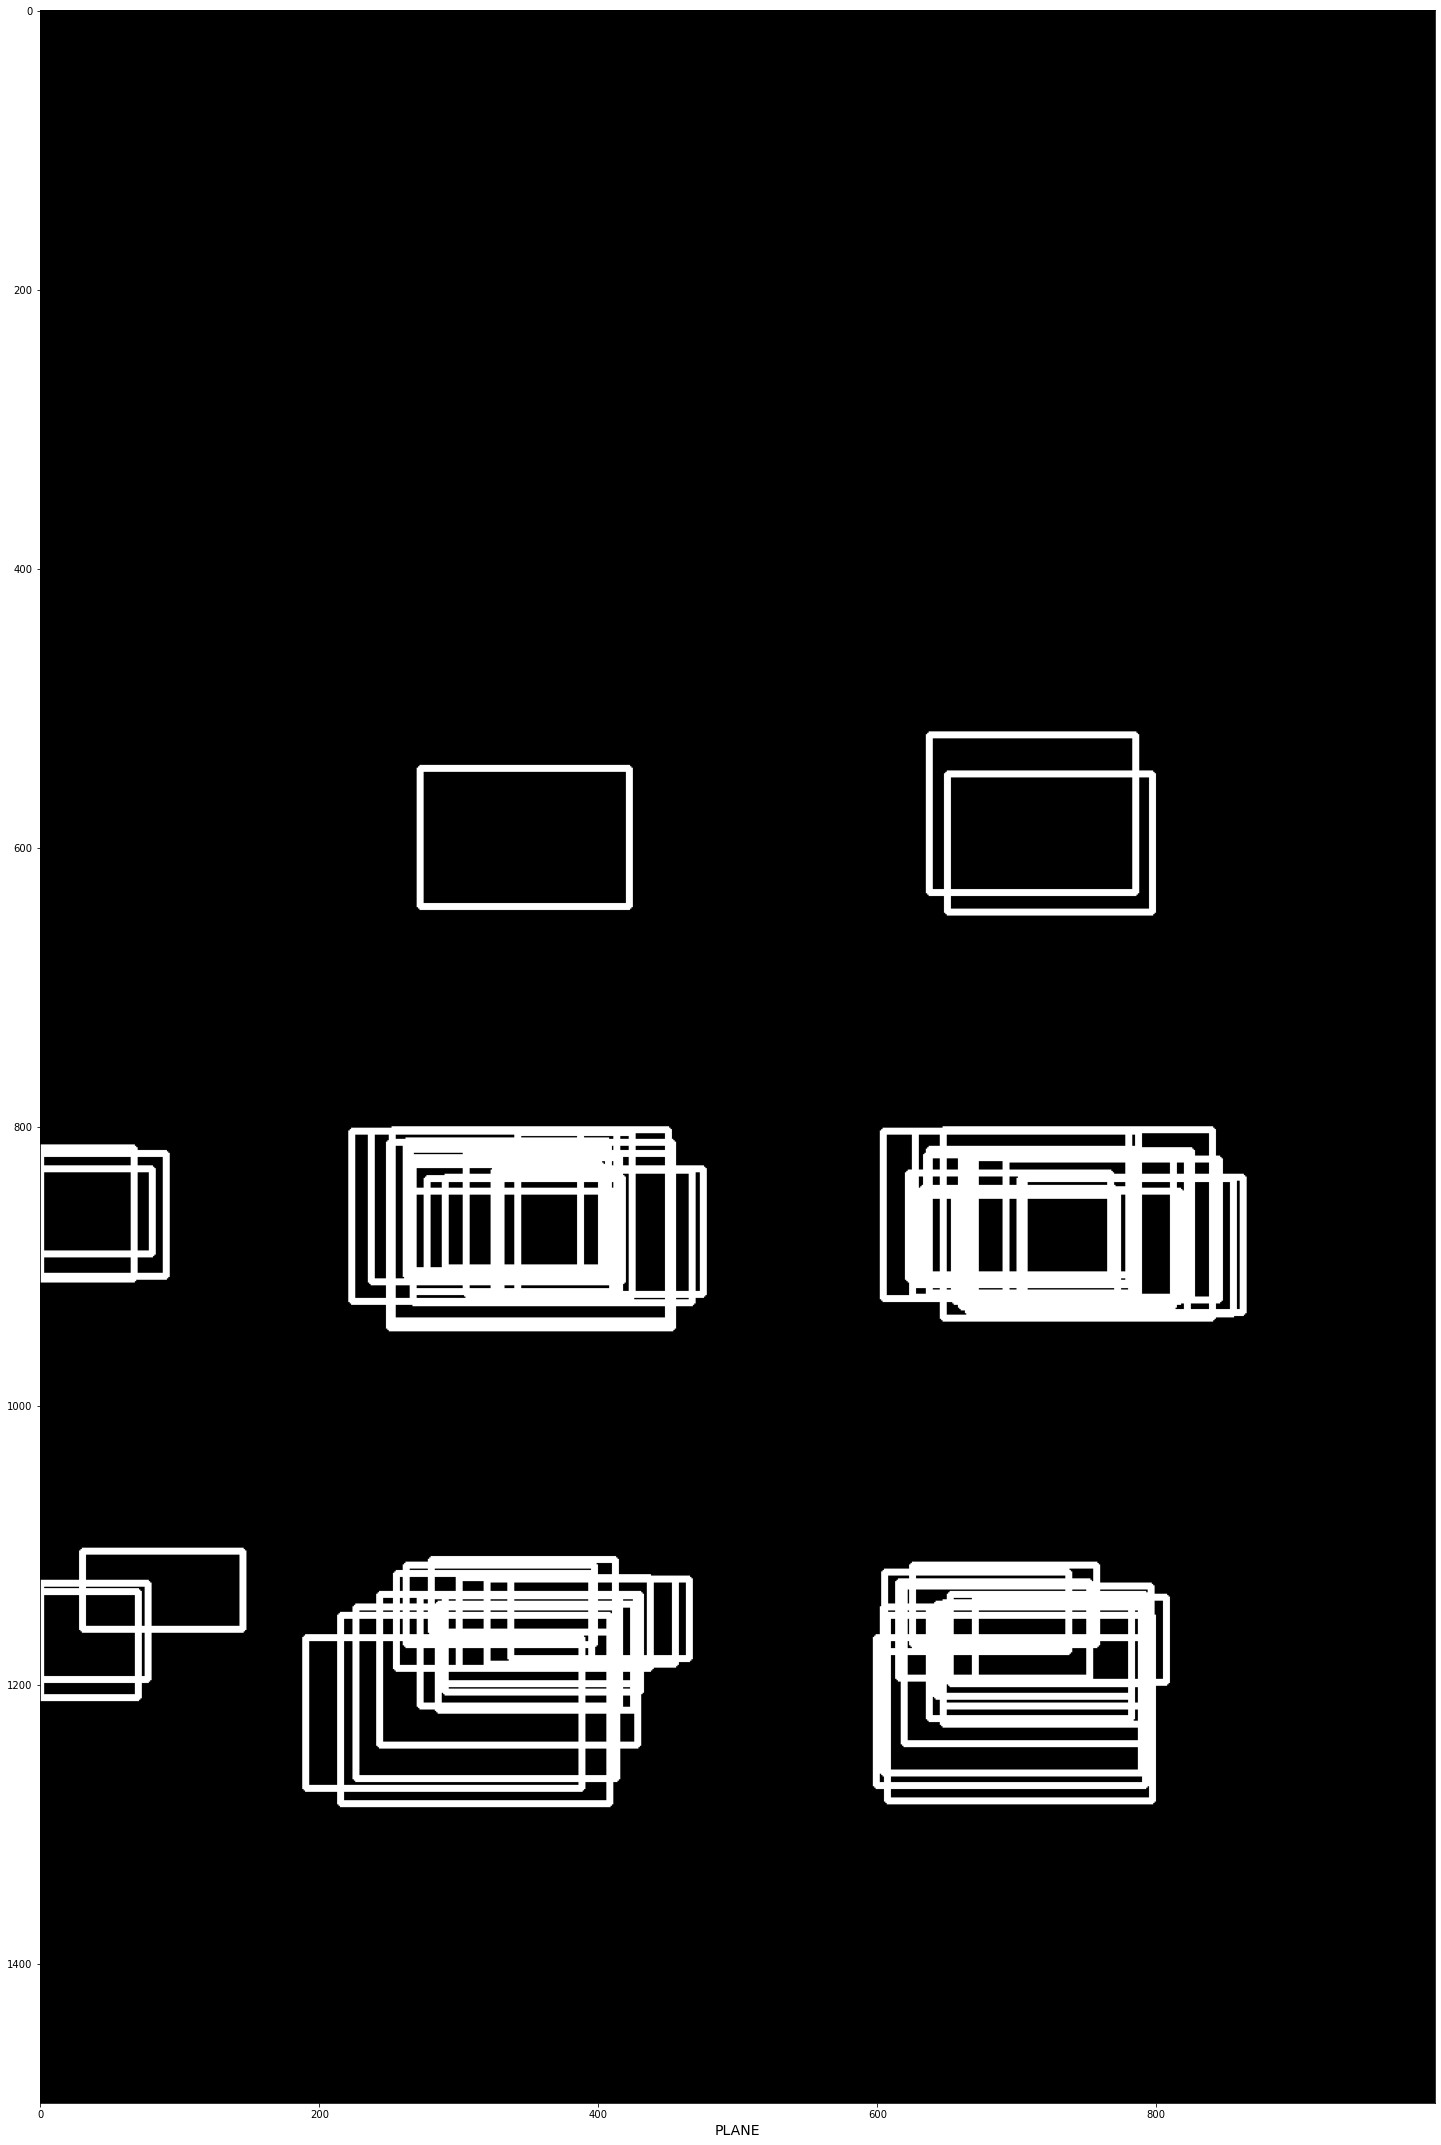

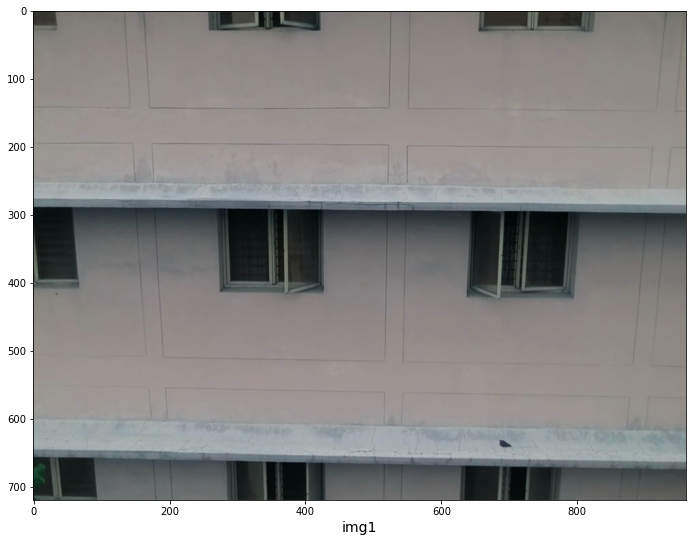

[645, 300, 790, 420]
mapped:645 544 790 635
[272, 295, 420, 412]
mapped:272 540 420 629


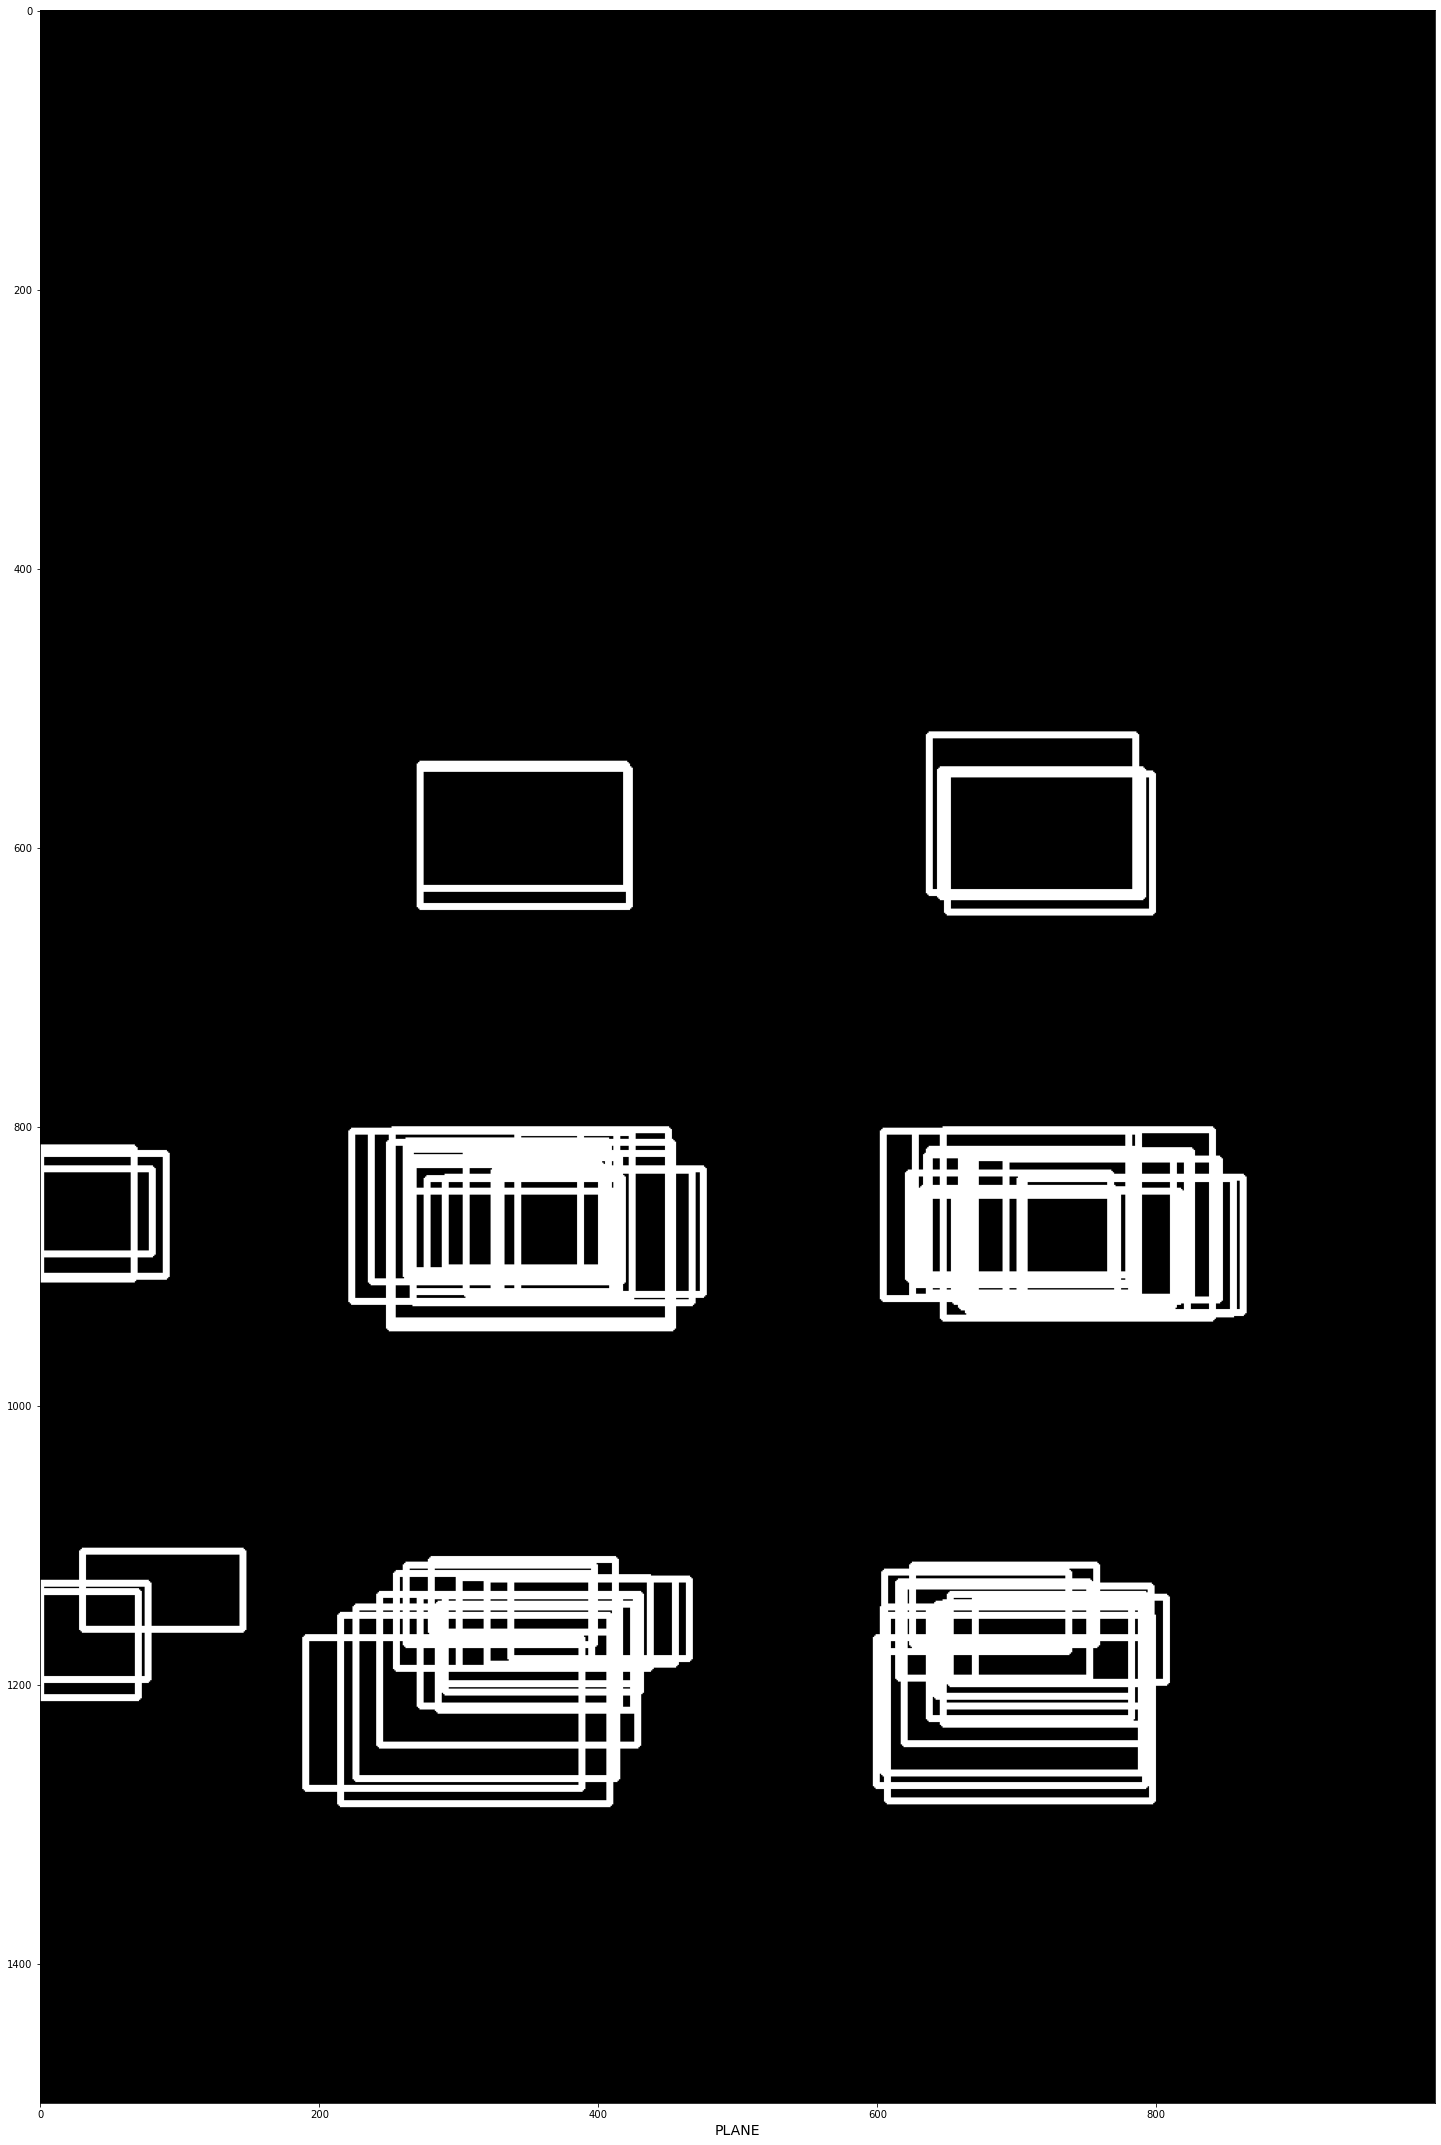

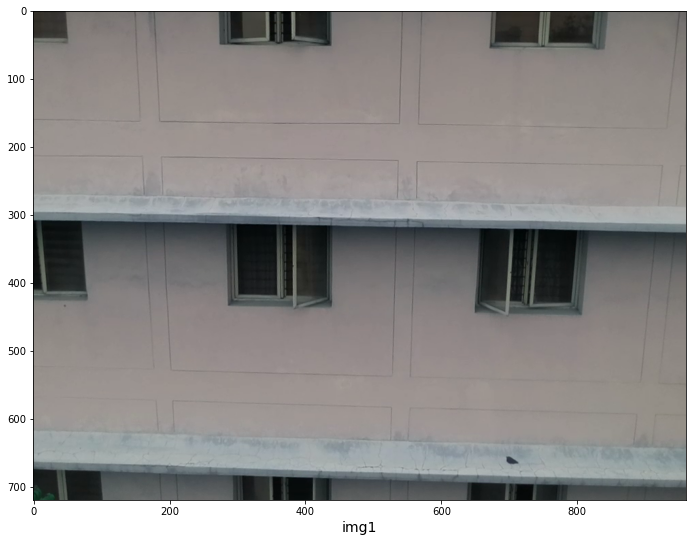

[657, 322, 802, 442]
mapped:657 521 802 612
[287, 320, 435, 432]
mapped:287 519 435 604


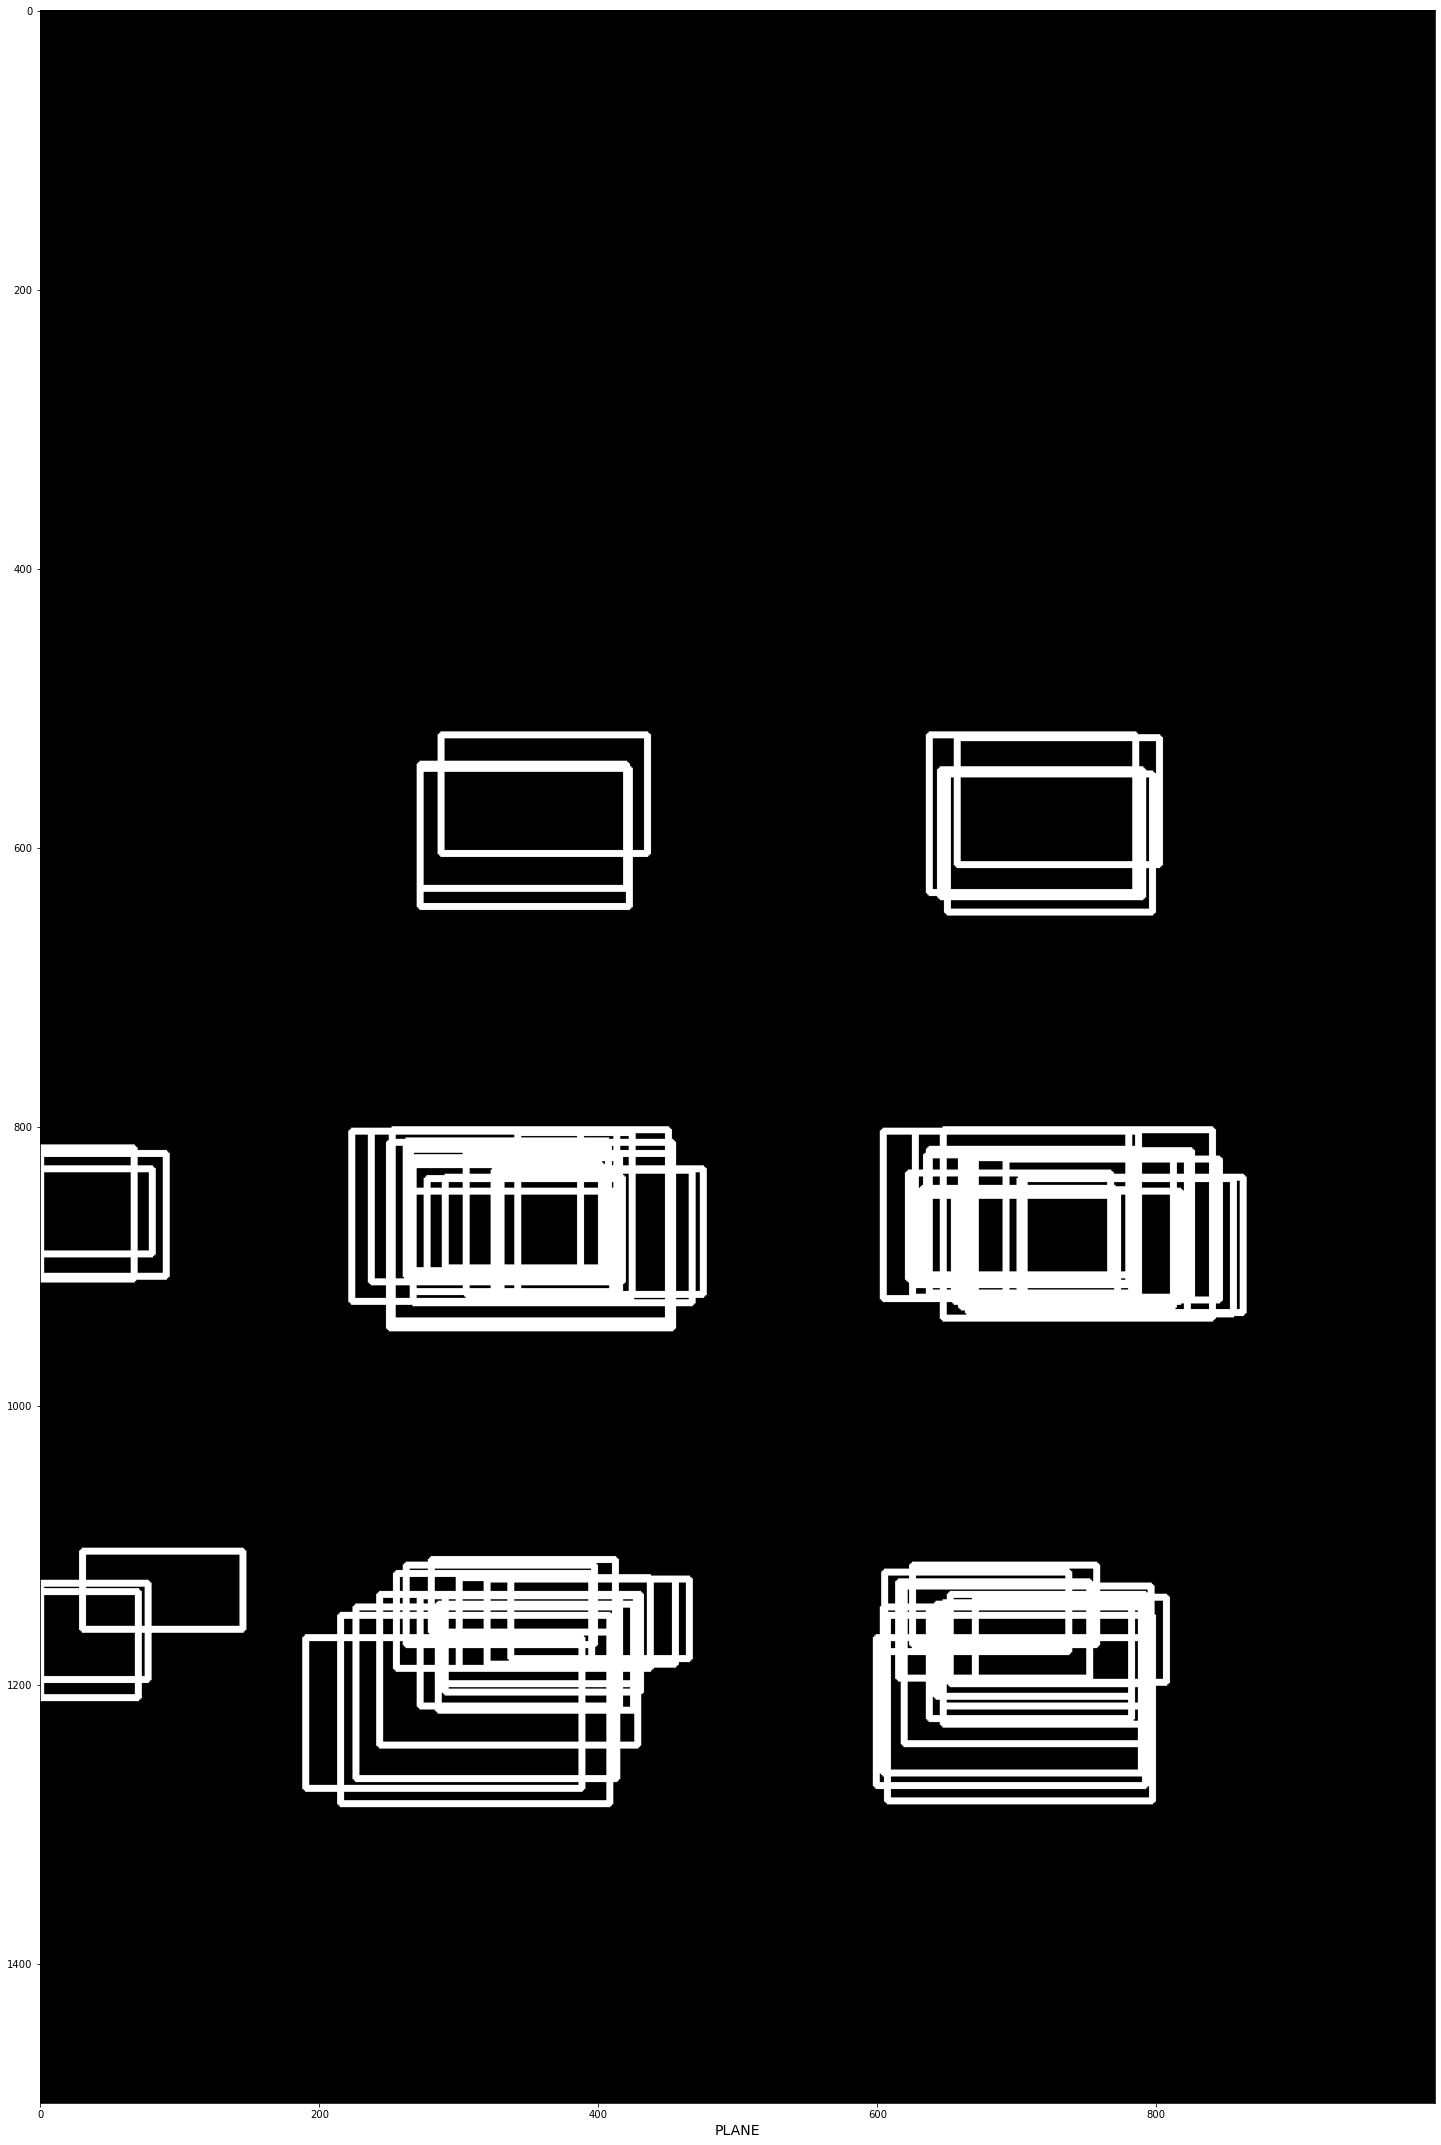

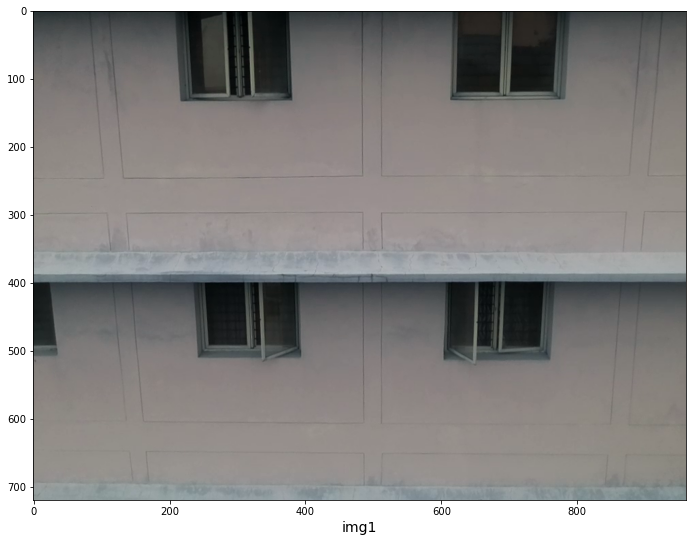

[222, 387, 407, 530]
mapped:222 520 407 629
[593, 387, 773, 525]
mapped:593 520 773 625
[625, 0, 777, 130]
mapped:625 226 777 325
[220, 2, 375, 130]
mapped:220 227 375 325


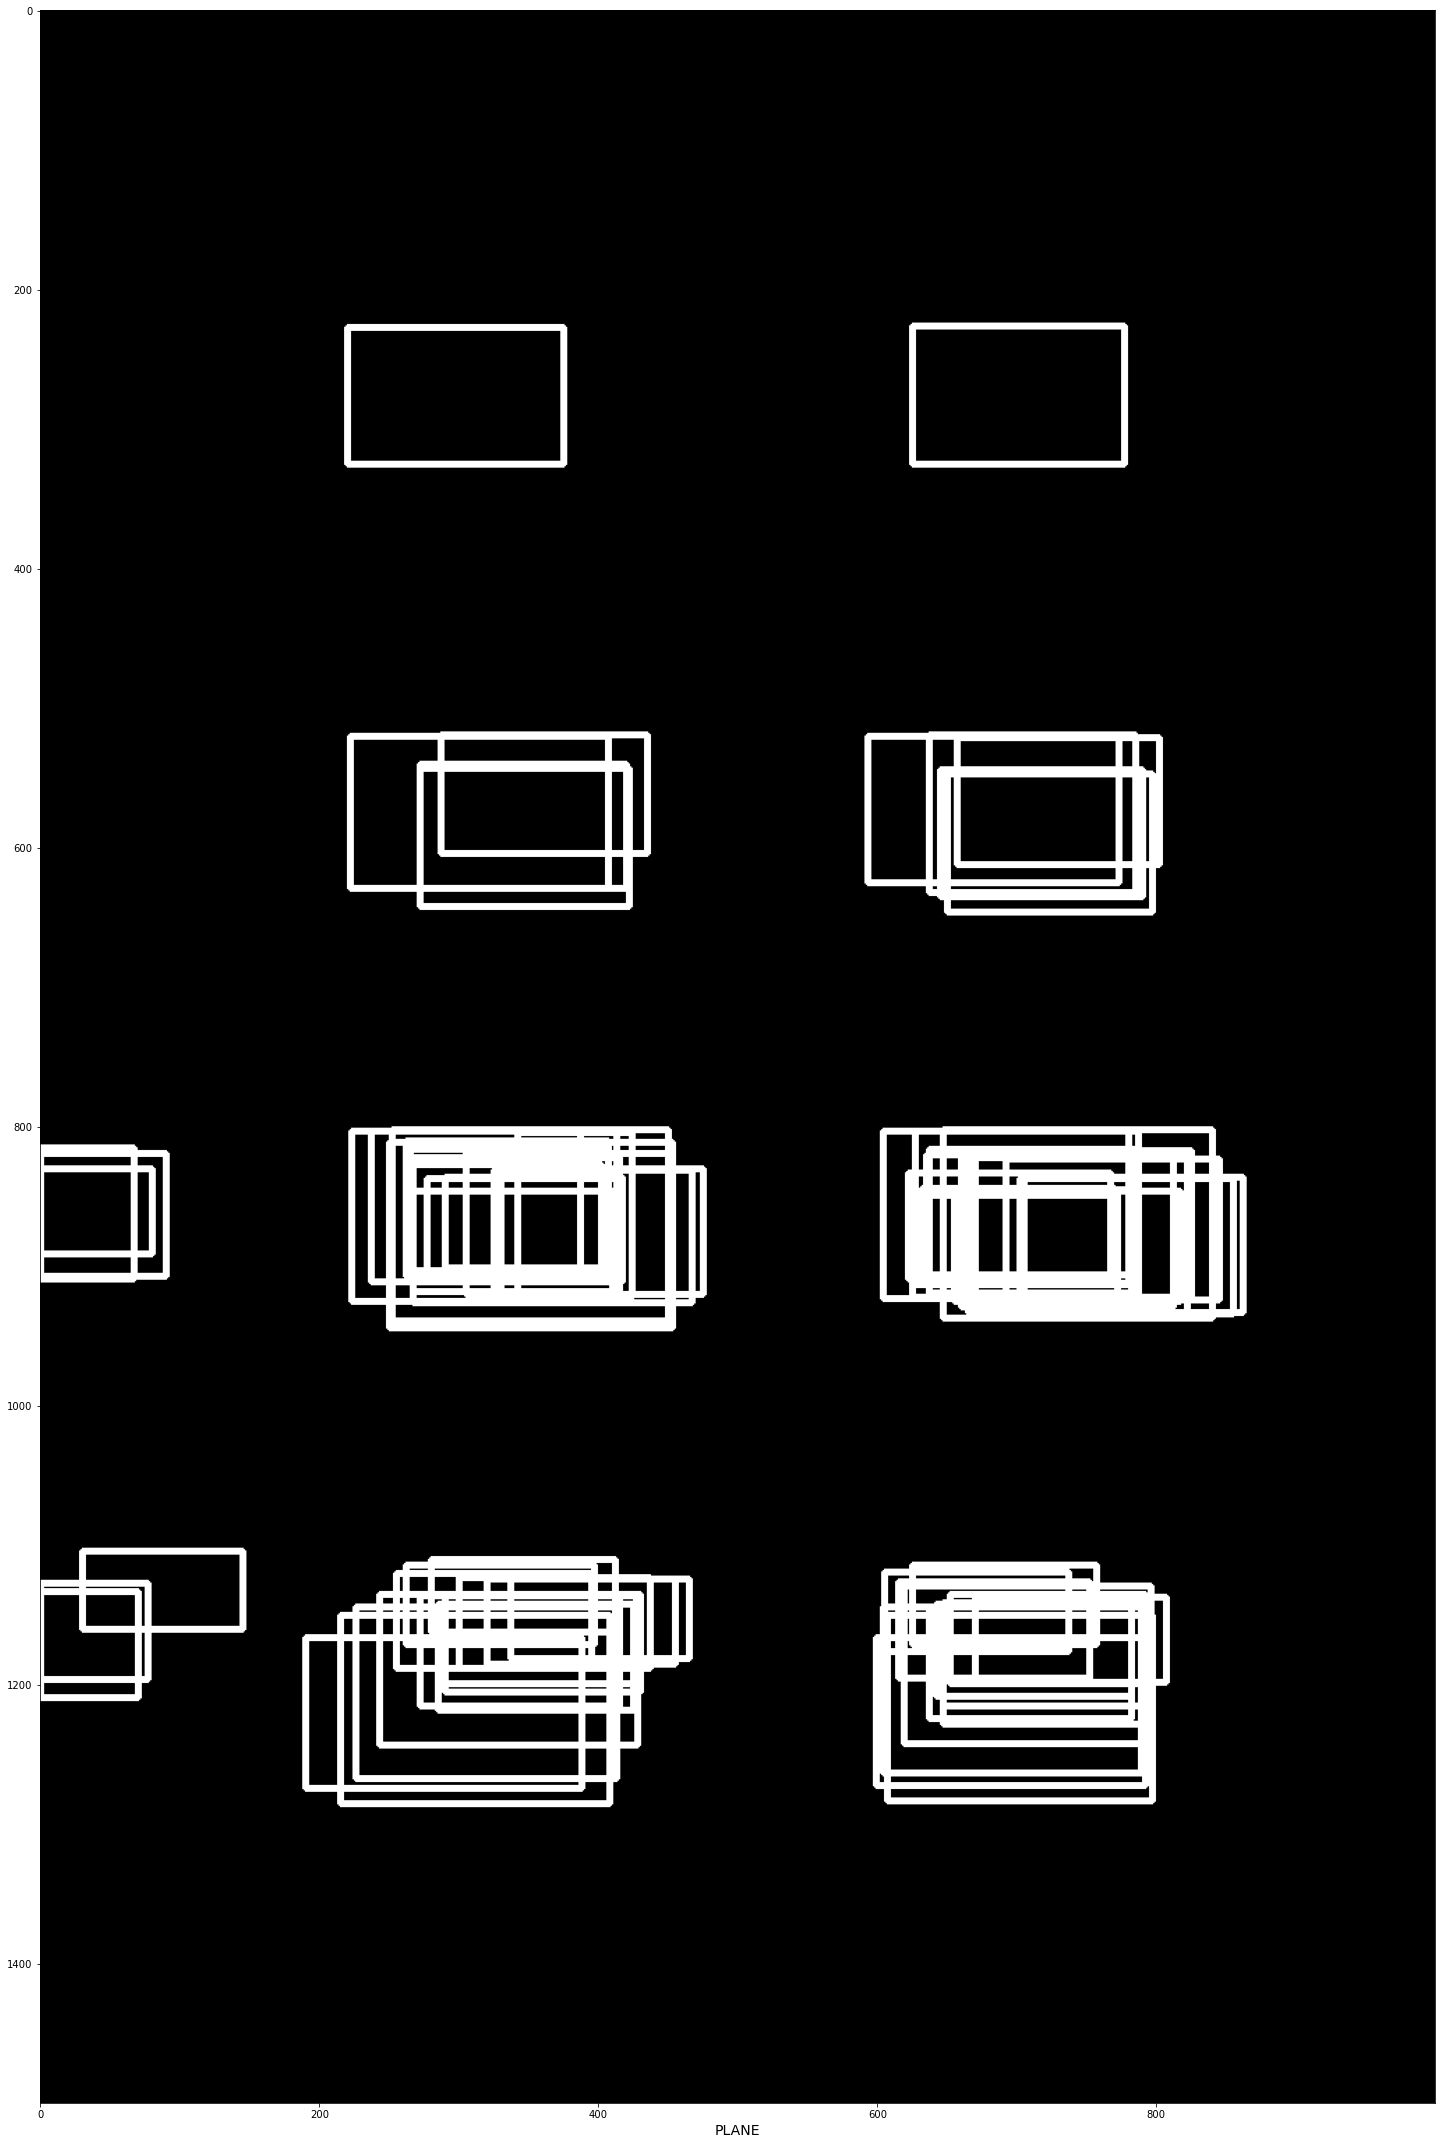

before NMS: [[ 190 1166  388 1274]
 [ 599 1166  792 1272]
 [ 215 1150  408 1285]
 [ 607 1150  797 1283]
 [ 226 1144  413 1267]
 [ 604 1144  789 1263]
 [ 243 1135  428 1243]
 [ 619 1129  796 1242]
 [ 637 1144  782 1224]
 [ 272 1136  415 1215]
 [ 655  846  817  925]
 [ 647 1150  790 1228]
 [ 285 1142  425 1218]
 [   0 1133   70 1209]
 [ 250  811  453  944]
 [ 665  822  822  933]
 [ 647 1141  790 1215]
 [ 290 1135  430 1205]
 [   0 1127   77 1196]
 [ 252  802  450  939]
 [ 647  802  840  937]
 [ 615 1126  752 1195]
 [ 255 1120  395 1188]
 [ 627  803  780  913]
 [ 237  803  387  911]
 [ 642 1142  782 1208]
 [ 290 1136  427 1199]
 [ 660  822  812  929]
 [ 267  822  415  926]
 [ 652 1135  792 1199]
 [ 300 1123  437 1188]
 [ 670  817  825  922]
 [ 342  804  424  922]
 [   0  815   67  909]
 [ 670 1137  807 1198]
 [ 320 1124  455 1185]
 [ 692  823  845  924]
 [ 305  819  452  920]
 [   0  819   90  907]
 [ 605 1119  737 1176]
 [ 262 1114  397 1171]
 [ 223  803  413  925]
 [ 604  803  787  923]

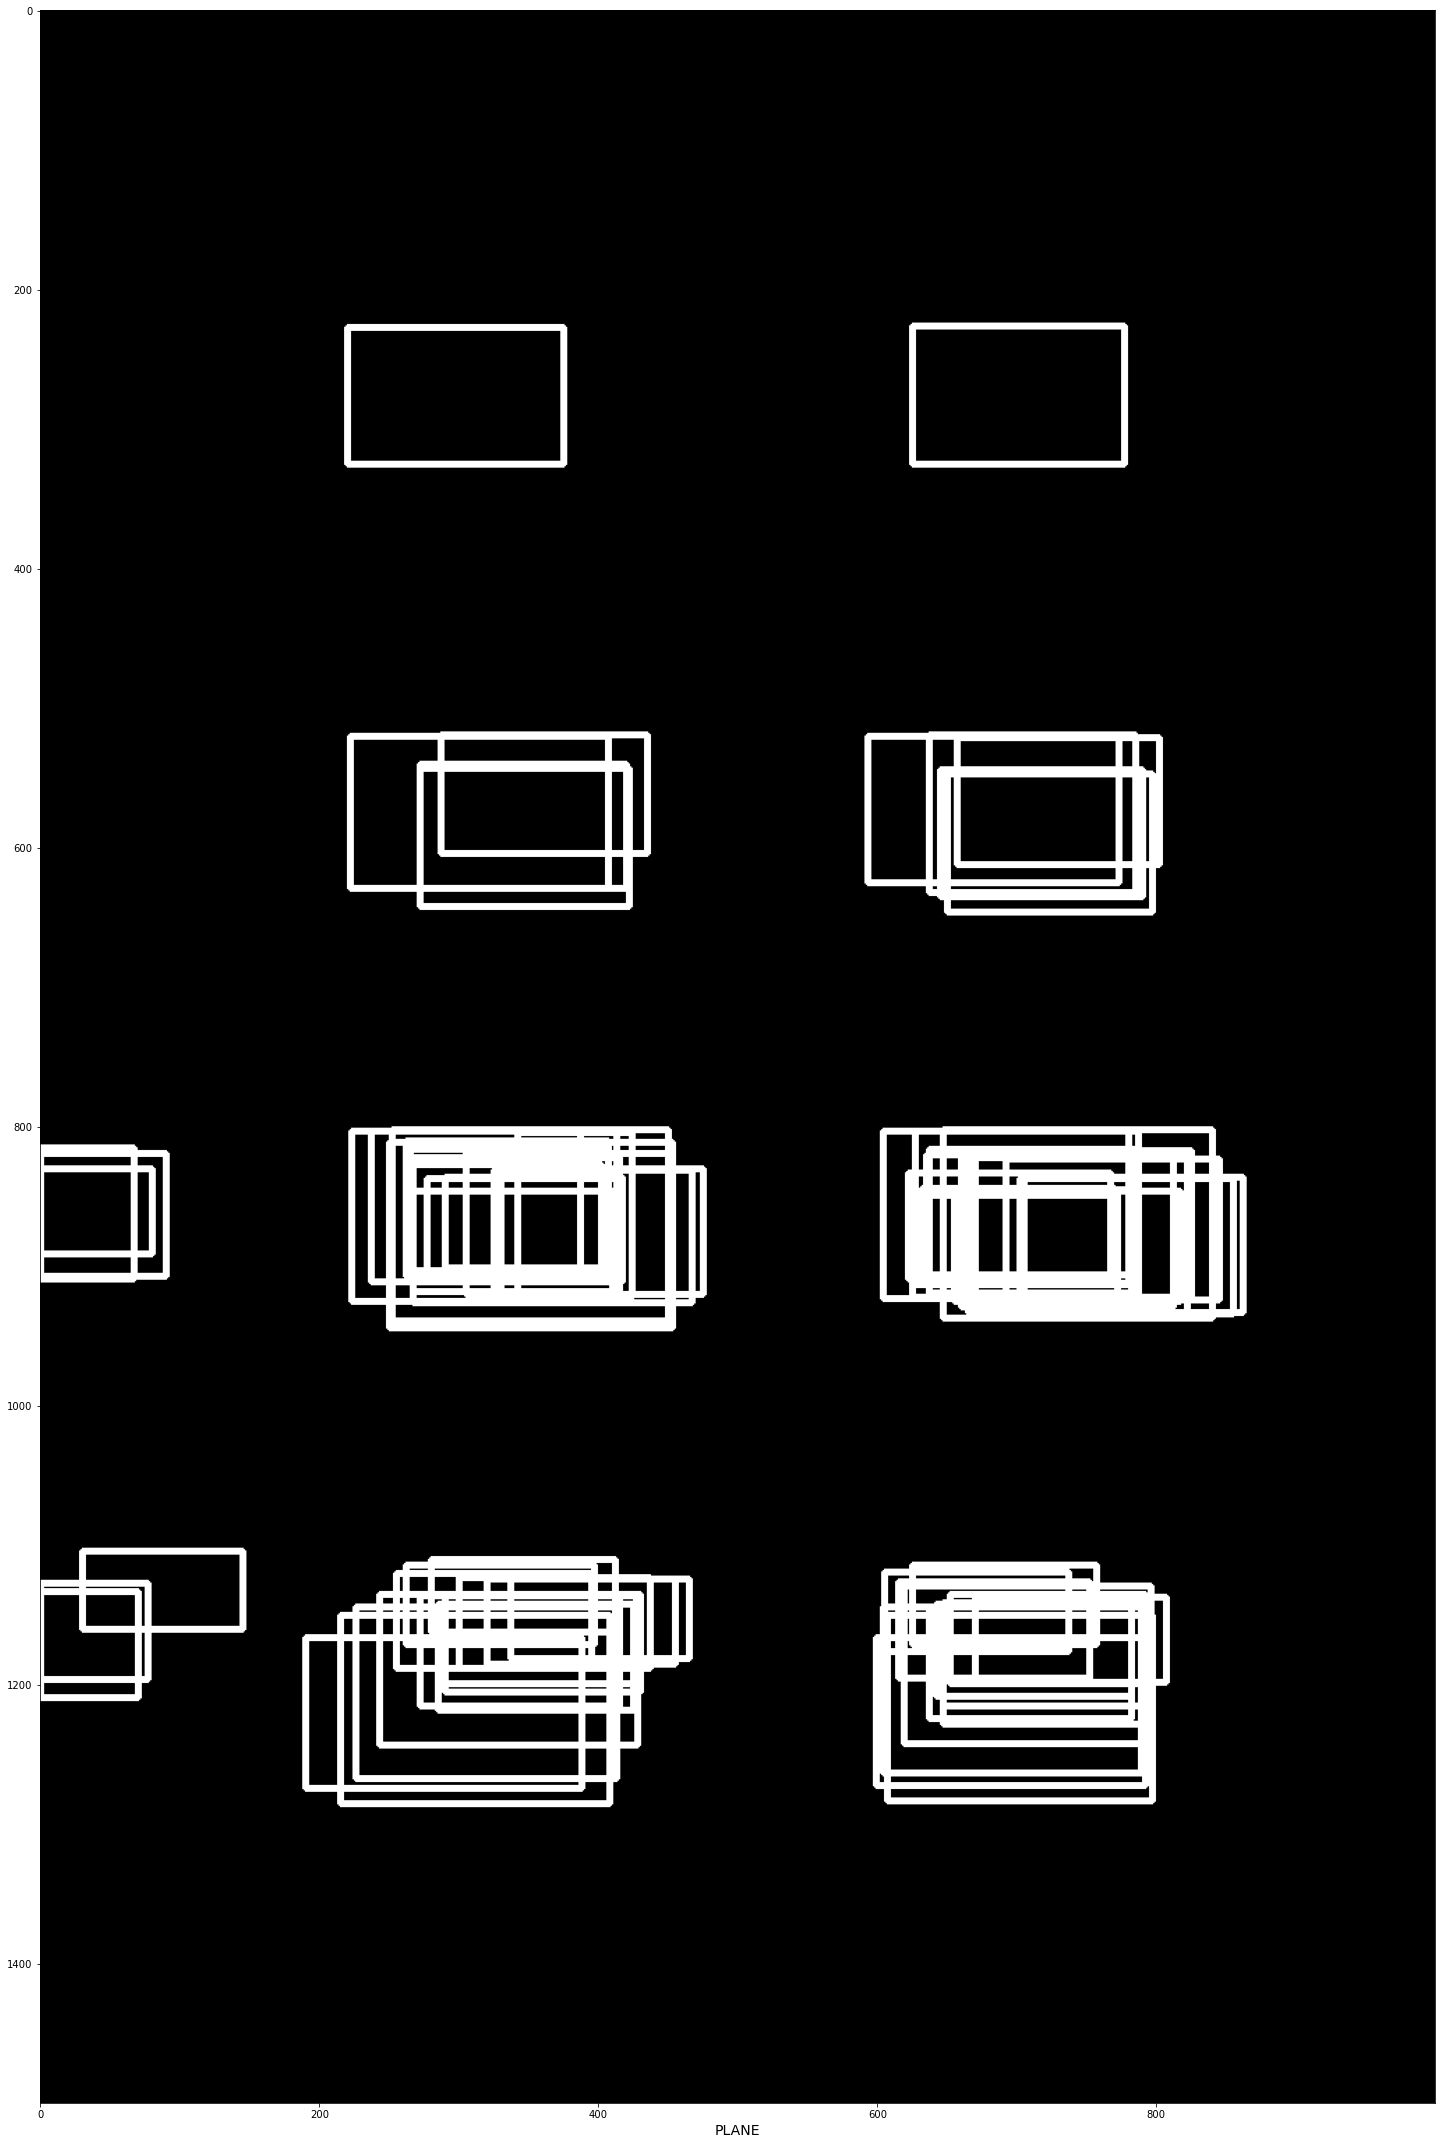

(75, 4)
after NMS: [[ 215 1150  408 1285]
 [ 607 1150  797 1283]
 [   0 1133   70 1209]
 [ 250  811  453  944]
 [ 647  802  840  937]
 [   0  815   67  909]
 [ 650  547  797  646]
 [ 272  543  422  642]
 [ 625  226  777  325]
 [ 220  227  375  325]]
(10, 4)


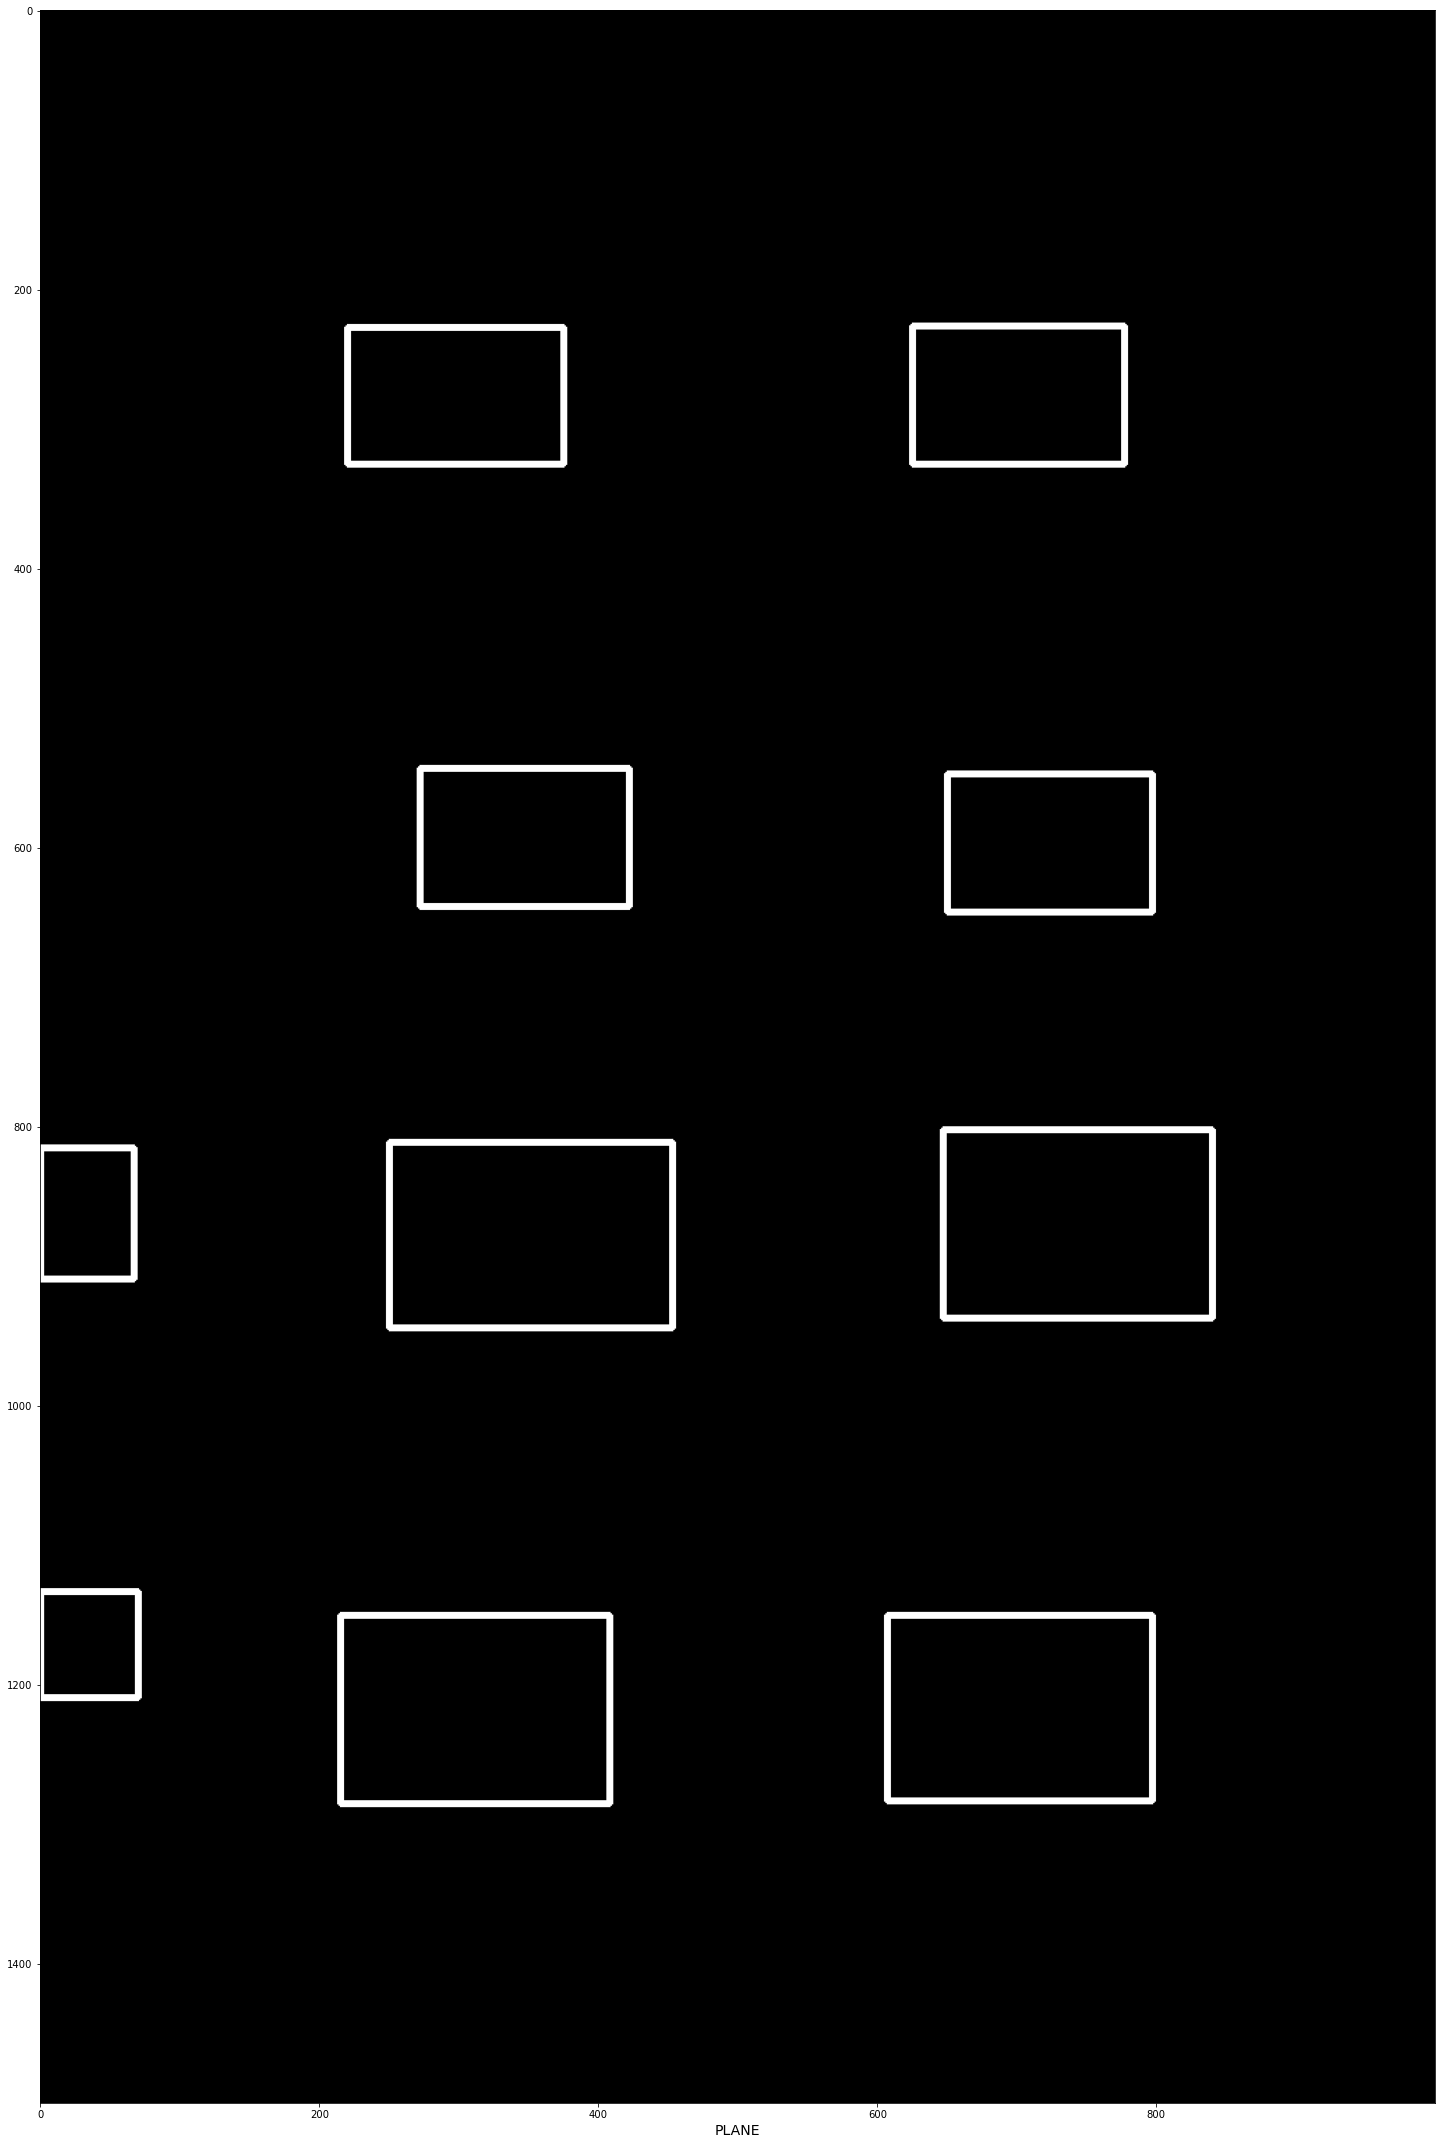

Total no. of windows in seq: 10
StoreyCount after running post processing module:  4
storeyHeights are: [282.5, 622.5, 903.5, 1224.5]


In [53]:
verticalPlane = np.zeros((1500,1000,3),np.uint8)
verticalPlaneCopy = np.copy(verticalPlane)
focalLength = 920 # in pixels
depth = 700 # in cm
nmsThresh = 0

# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(imgPath)))
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
#     print(image.shape)
    images.append(image)
    print(imagePath)

windowCount = len(FinalList[0])
print("startWindowCount:", windowCount)
allMappedBoxes = []
## MAIN LOOP ##
for i in range(len(images)):
    img1 = images[i]
    
#     print(img1.shape)
    # read images and transform them to grayscale
    # Make sure that the train image is the image that will be transformed
    # Opencv defines the color channel in the order BGR 
    # Transform it to RGB to be compatible to matplotlib
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
#     img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(16,9))
    ax1.imshow(img1, cmap="gray")
    ax1.set_xlabel("img1", fontsize=14)
    plt.show()
    
    ## Preparing Binary Mask and mapping bounding box coordinates
    ## COORDS1 and COORDS2 : WOULD COME FROM TEXT FILEW
    coords1 = FinalList[i]
#     coords2 = FinalList[i+1]
    
    padding = 0

    ## Commented as the coords would come from recorded text File.
    pick1 = mapToPickv1(coords1, padding)
#     pick2 = mapToPickv1(coords2, padding)
    
    mappedBoxes = mapToVerticalPlane(focalLength,depth,pick1,height_info[i], verticalPlaneCopy, img1)
    allMappedBoxes = allMappedBoxes + mappedBoxes
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlaneCopy, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    
## NMS
print("before NMS:", np.array(allMappedBoxes))
plotBoxes(np.copy(verticalPlane), allMappedBoxes)
print(np.array(allMappedBoxes).shape)

finalBoxes = non_max_suppression_fast(np.array(allMappedBoxes), nmsThresh)
print("after NMS:", finalBoxes)
print(finalBoxes.shape)
plotBoxes(np.copy(verticalPlane), finalBoxes)
print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
storeyCount, storeyHeights = calculateStoreys(finalBoxes)

In [54]:
print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
storeyCount, storeyHeights = calculateStoreys(finalBoxes)
print("StoreyCount:", storeyCount)
print("storeyHeights:", storeyHeights)

print("FinalBoxes:", finalBoxes)
print("FinalBoxes (in list):", list(finalBoxes))

Total no. of windows in seq: 10
StoreyCount after running post processing module:  4
storeyHeights are: [282.5, 622.5, 903.5, 1224.5]
StoreyCount: 4
storeyHeights: [282.5, 622.5, 903.5, 1224.5]
FinalBoxes: [[ 215 1150  408 1285]
 [ 607 1150  797 1283]
 [   0 1133   70 1209]
 [ 250  811  453  944]
 [ 647  802  840  937]
 [   0  815   67  909]
 [ 650  547  797  646]
 [ 272  543  422  642]
 [ 625  226  777  325]
 [ 220  227  375  325]]
FinalBoxes (in list): [array([ 215, 1150,  408, 1285]), array([ 607, 1150,  797, 1283]), array([   0, 1133,   70, 1209]), array([250, 811, 453, 944]), array([647, 802, 840, 937]), array([  0, 815,  67, 909]), array([650, 547, 797, 646]), array([272, 543, 422, 642]), array([625, 226, 777, 325]), array([220, 227, 375, 325])]
